In [4]:
# Import packages 
import corticalmapping.core.FileTools as ft
import corticalmapping.core.TimingAnalysis as ta
import corticalmapping.HighLevel as hl 
import corticalmapping.RetinotopicMapping as rm
import corticalmapping.core.PlottingTools as pt
import corticalmapping.core.ImageAnalysis as ia 
from toolbox.misc import BinarySlicer
from timing import SpatiotemporalTuningTrial as sm

# Import dependencies
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import tifffile as tiff
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, bessel, ellip, firwin, filtfilt, get_window
import tables as tb
from scipy import ndimage
from scipy import misc 
import cv2
from ipywidgets import interact

#%autoreload 2

sns.set(style = "ticks",palette = "muted", color_codes = True)

%matplotlib inline

#%load_ext autoreload
#autoreload 2


In [5]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

# get cux2 experiments in V1 
manifest_file_path = r"D:\platform_boc_2018_09_25\manifest.json"
ophys_experiment_path = r"D:\platform_boc_2018_09_25\ophys_experiment_data"
boc = BrainObservatoryCache(manifest_file= manifest_file_path)
#boc = BrainObservatoryCache()
cux2_ecs = boc.get_experiment_containers(cre_lines=['Cux2-CreERT2','Slc17a7-IRES2-Cre'], imaging_depths = [175, 195, 185, 200, 205, 225,250, 265, 276,275])


cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
cux2_ec_ids = [ ec['id'] for ec in cux2_ecs ]
cux2_cells = cells[cells['experiment_container_id'].isin(cux2_ec_ids)]


cell_exp = boc.get_ophys_experiments(cell_specimen_ids=cux2_cells['cell_specimen_id'].values,
                                     stimuli=[stim_info.DRIFTING_GRATINGS])


In [6]:
donor_name_df = pd.DataFrame(columns = ['donor_name'])

for exp in cell_exp: 
    to_append = pd.DataFrame(columns = ['donor_name'])
    to_append.loc[0] = exp['donor_name']
    donor_name_df  = donor_name_df.append(to_append)

In [5]:
def cross_validate_response(niter, numcells, n_trials):
    cell_trials = np.empty((8,5,14, numcells))
    cell_trials[:] = np.NaN
    
    response_events_first = np.empty((8, 5, numcells, niter))
    response_events_second = np.empty((8, 5, numcells, niter))
    response_events_first[:] = np.nan
    response_events_second[:] = np.NaN
    
    print cell_trials.shape
    for d,ori in enumerate(orivals):
        for t,tf in enumerate(tfvals):
            mse = mean_sweep_events[(stim_table.orientation==ori)&
                                    (stim_table.temporal_frequency==tf)].values[:14]
            cell_trials[d,t,:mse.shape[0],:mse.shape[1]] = mse 

    for i in range(niter):
        # calculate mean response across new sampling at each dir/tf combination
        for d in range(8): 
            for t in range(5): 

                # sample n_trials di x tf trials from mean_sweep_events
#                 n_trials = cell_trials.shape[2]
                idx_1 = np.random.choice(14, n_trials/2, replace=False)
#                 idx_2 = np.setdiff1d(range(n_trials), idx_1)
                idx_2 = np.random.choice(np.setdiff1d(range(14), idx_1), n_trials/2, replace=False)
                response_events_first[d,t,:,i] = np.mean(cell_trials[d,t,idx_1,:], axis=0)
                response_events_second[d,t,:,i] = np.mean(cell_trials[d,t,idx_2,:], axis=0)
    return response_events_first, response_events_second

In [80]:
#New selects one set of n_trials
def cross_validate_response(niter, numcells, n_trials):
    cell_trials = np.empty((8,5,14, numcells))
    cell_trials[:] = np.NaN
    
    response_events_first = np.empty((8, 5, numcells, niter))
    response_events_second = np.empty((8, 5, numcells, niter))
    response_all = np.empty((8,5,numcells))
    response_events_first[:] = np.nan
    response_events_second[:] = np.NaN
    response_all[:] = np.NaN
    
    
    idx = np.random.choice(14, n_trials, replace=False)
    combs = list(itertools.combinations(idx, n_trials/2))
    
    for d,ori in enumerate(orivals):
        for t,tf in enumerate(tfvals):
            mse = mean_sweep_events[(stim_table.orientation==ori)&
                                    (stim_table.temporal_frequency==tf)].values[:14]
            cell_trials[d,t,:mse.shape[0],:mse.shape[1]] = mse
            
            response_all[d,t,:] = np.mean(cell_trials[d,t,idx,:], axis=0)
    
    for i in range(niter):
        # calculate mean response across new sampling at each dir/tf combination
        for d in range(8): 
            for t in range(5): 

                idx_1 = combs[i]
                idx_2 = np.setdiff1d(idx, idx_1)
    
                response_events_first[d,t,:,i] = np.mean(cell_trials[d,t,idx_1,:], axis=0)
                response_events_second[d,t,:,i] = np.mean(cell_trials[d,t,idx_2,:], axis=0)
    return response_events_first, response_events_second, response_all

In [6]:
rel_vs_resp_all = pd.DataFrame(columns = ['cell_specimen_id',
                                          'id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'OSI',
                                          'TF',
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun'])

In [ ]:
mean_sweep_events[(stim_table.orientation==0)&
                                                     (stim_table.temporal_frequency==2)].values[:14].shape

In [472]:
rel_vs_resp_all = pd.DataFrame(columns = ['cell_specimen_id',
                                          'id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'DSI_nm',
                                          'DSI_trials',
                                          'DSI_trials_std',
                                          'OSI_trials',
                                          'OSI_trials_std',
                                          'TF_trials',
                                          'TF_trials_std',
                                          'OSI',
                                          'OSI_nm'
                                          'TF',
                                          'TF_nm',    
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun','mean_4', 'std_4','mean_6','std_6','mean_8','std_8','mean_10',
                                 'std_10','mean_12','std_12','mean_14','std_14', 'osi_4','dsi_4','tf_4',
                                'osi_6','dsi_6','tf_6','osi_8','dsi_8','tf_8','osi_10','dsi_10','tf_10',
                                 'osi_12', 'dsi_12','tf_12']) 

In [473]:

for ii, exp in enumerate(cell_exp):    
    print("Experiment with drifting gratings:")
    pprint.pprint(exp)
    rel_vs_resp = pd.DataFrame(columns = ['cell_specimen_id',
                                          'id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'DSI_nm',
                                          'DSI_trials',
                                          'DSI_trials_std',
                                          'OSI_trials',
                                          'OSI_trials_std',
                                          'TF_trials',
                                          'TF_trials_std',
                                          'OSI',
                                          'OSI_nm'
                                          'TF',
                                          'TF_nm',    
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun', 
                                         'mean_4', 'std_4','mean_6','std_6','mean_8','std_8','mean_10',
                                 'std_10','mean_12','std_12','mean_14','std_14', 'osi_4','dsi_4','tf_4',
                                'osi_6','dsi_6','tf_6','osi_8','dsi_8','tf_8','osi_10','dsi_10','tf_10',
                                 'osi_12', 'dsi_12','tf_12'])    
    #file_name = os.path.join(ophys_experiment_path, str(exp['id']))
    try: 
        data_set = boc.get_ophys_experiment_data(exp['id'])
        dg = DriftingGratings(data_set)
        save_path = r"E:/"

        cells = data_set.get_cell_specimen_ids()
        stim_table = data_set.get_stimulus_table(stim_info.DRIFTING_GRATINGS)

       # data_file_dg = os.path.join(save_path,'DriftingGratings', str(exp['id']) + "_dg_events_analysis.h5")


        mean_sweep_events = dg.mean_sweep_response.iloc[:,:-1]
        
        mean_sweep_events = mean_sweep_events.clip_lower(0)
       # peak = pd.read_hdf(data_file_dg, 'peak')
        numcells = dg.numbercells 
        orivals = np.array(range(0,360,45))
        orivals_rad = np.deg2rad(orivals)
        tfvals = np.array([1,2,4,8,15])

        #t0 = time.clock()
        osi_array = np.empty((numcells, 6, 2))
        dsi_array = np.empty((numcells, 6, 2))
        tf_array = np.empty((numcells, 6, 2))
        osi_std = np.empty((numcells,6, 2))
        dsi_std = np.empty((numcells,6, 2))
        tf_std = np.empty((numcells,6, 2))
        for j,n_trials in enumerate(range(4,15,2)):
            niter = (np.math.factorial(n_trials)/(np.math.factorial(n_trials/2))**2)
            if niter>50:
                niter = 50
            print niter
            DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(niter))
            OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(niter))
            TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(niter))
            response_array_first, response_array_second, response_all = cross_validate_response(niter, numcells, n_trials)
            resp = np.empty((numcells, niter))
            for ni in range(niter):
                m = np.max(response_array_first[:,:,:,ni], axis=(0,1)) 
            #print m.shape
                a = response_array_first[:,:,:,ni]==np.nanmax(response_array_first[:,:,:,ni], axis=(0,1))
                sortval = np.where(a)
                un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
                newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]
                pref_ori = newsortval[0]
                pref_tf = newsortval[1]
                TF.loc[ni] = pref_tf


                        #osi
                inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
                tuning = response_array_second[:, inds[1], inds[2],ni]
                tuning = np.where(tuning>0, tuning, 0)
                CV_top_os = np.empty((8, numcells), dtype=np.complex128)
                CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
                for i in range(8):
                    CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
                    CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

                OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



                #dsi
                null_ori= np.mod(pref_ori+4, 8)
                pref = response_array_second[inds[0], inds[1], inds[2], ni]
                null = response_array_second[null_ori, inds[1], inds[2], ni]
                null = np.where(null> 0, null, 0)

                DSI.loc[ni] = (pref-null)/(pref+null)

                resp[:,ni] = response_array_second[inds[0], inds[1], inds[2], ni]


            mean_name = 'mean_'+str(n_trials)
            std_name = 'std_'+str(n_trials)
            rel_vs_resp[mean_name] = resp.mean(axis=1)
            rel_vs_resp[std_name] = resp.std(axis=1)
            #old metrics

            #m = np.max(response_all[:,:,:], axis=(0,1)) 
            #print m.shape
            #a = response_all[:,:,:]==np.nanmax(response_all[:,:,:], axis=(0,1))
            #sortval = np.where(a)
            #un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
            #newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]
            #pref_ori = newsortval[0]
           # pref_tf = newsortval[1]

            sort = np.where(response_all[:,:,:]==np.nanmax(response_all[:,:,:], axis=(0,1)))
            sortind = np.argsort(sort[2])
            pref_ori = sort[0][sortind]
            pref_tf = sort[1][sortind]
            TF.loc[ni] = pref_tf

            TF.loc[ni] = pref_tf

            osi_name = 'osi_'+str(n_trials)
            dsi_name = 'dsi_'+str(n_trials)
            tf_name = 'tf_'+str(n_trials)
            rel_vs_resp[tf_name] = pref_tf



            inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
            tuning = response_all[:, inds[1], inds[2]]
            tuning = np.where(tuning>0, tuning, 0)
            CV_top_os = np.empty((8, numcells), dtype=np.complex128)
            CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
            for i in range(8):
                CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
                CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))
            rel_vs_resp[osi_name] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)


            null_ori= np.mod(pref_ori+4, 8)
            pref = response_all[inds[0], inds[1], inds[2]]
            null = response_all[null_ori, inds[1], inds[2]]
            null = np.where(null>0, null, 0)
            rel_vs_resp[dsi_name] = (pref-null)/(pref+null)

            osi_array[:,j,0] = OSI.mean().values
            osi_std[:,j,0] = OSI.std().values
            dsi_array[:,j,0] = DSI.mean().values
            dsi_std[:,j,0] = DSI.std().values
            tf_array[:,j,0] = TF.mean().values
            tf_std[:,j,0] = TF.std().values


        rel_vs_resp['DSI_nm'] = dsi_array[:,-1, 0]
        rel_vs_resp['OSI_nm'] = osi_array[:,-1, 0]
        rel_vs_resp['TF_nm'] = tf_array[:, -1, 0]



       # for jj in range(numcells):
        #    rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
        #    rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
        #    rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
        #    rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
        #3    rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
        #    rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]










        #dg = DriftingGratings(data_set)
       # s#tim_table = dg.stim_table

        #print rel_vs_resp.head()
        # create dataframe with reliability, peak dF/F, and whether they passed each criterion

        rel_vs_resp['DSI'] = dg.peak.dsi_dg
        rel_vs_resp['pref_ori'] = dg.peak.ori_dg
        rel_vs_resp['gOSI'] = dg.peak.cv_os_dg
        rel_vs_resp['OSI'] = dg.peak.osi_dg
        rel_vs_resp['cell_specimen_id'] = dg.cell_id
        rel_vs_resp['TF'] = dg.peak.tf_dg
        rel_vs_resp['reliability'] = dg.peak.reliability_dg
        rel_vs_resp['peak dF/F'] = dg.peak.peak_dff_dg
        rel_vs_resp['Sun'] = rel_vs_resp['peak dF/F']> 10
        rel_vs_resp['id'] = exp['id']
        rel_vs_resp['area'] = exp['targeted_structure']

        
        mean_sweep_response = dg.mean_sweep_response
        for cell in range(dg.numbercells):
            # Andermann
            pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[cell]]
            pref_ori = dg.orivals[dg.peak.ori_dg.iloc[cell]]
            resp_tf = mean_sweep_response[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)][str(cell)].values
            resp_blank = mean_sweep_response[stim_table['blank_sweep']==True][str(cell)].values
            t2, p2 = sc.stats.ttest_ind(resp_tf,resp_blank)
            rel_vs_resp['p_blank'] = p2
            rel_vs_resp['Andermann'].iloc[cell] = p2 < 0.05/40

            # Marshel 
            stdev_tf = sc.std(resp_tf)
            mean_tf = np.mean(resp_tf)
            stdev_blank = sc.std(resp_blank)
            mean_blank = np.mean(resp_blank)
            reliability = (mean_tf- mean_blank) / (stdev_tf + stdev_blank)
            rel_vs_resp['Marshel'].iloc[cell] = (reliability > 1) 
            rel_vs_resp['reliability_marshel'].iloc[cell] = reliability

            #Roth
            resp_baseline = dg.sweep_response[str(cell)].apply(lambda x : x[:30])
            resp = dg.sweep_response[str(cell)].apply(lambda x : x[30:90])
            resp_baseline_mean  = resp_baseline.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
            resp_baseline_std = resp_baseline.apply(np.std)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
            resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
            rel_vs_resp['Roth'].iloc[cell] = np.sum((resp_mean > (resp_baseline_mean + resp_baseline_std*3)))/np.float(resp_baseline_mean.shape[0])>0.5
            rel_vs_resp['reliability_percentage'] = np.sum(resp_mean > (resp_baseline_mean + resp_baseline_std*2))/np.float(resp_baseline_mean.shape[0])

            # Tohmi 
            sweep_resp_pref = dg.sweep_response[(stim_table.orientation==pref_ori) & (stim_table.temporal_frequency==pref_tf)][str(cell)]
            mean_sweep_resp_pref = sweep_resp_pref.mean()
            max_resp = mean_sweep_resp_pref[30:90].max()
            rel_vs_resp['Tohmi'].iloc[cell] = max_resp > 4

            # Reliability corr 
            rel_vs_resp['reliability_corr'].iloc[cell] = np.mean(np.corrcoef(np.array([a for a in sweep_resp_pref]))[np.triu_indices(sweep_resp_pref.shape[0],k=1)])
           #rel_vs_resp['reliability_percentage'].iloc[cell] = 


    except:
        continue
    rel_vs_resp_all = rel_vs_resp_all.append(rel_vs_resp)
   # n = n+ncells
    del rel_vs_resp



Experiment with drifting gratings:
{'acquisition_age_days': 111,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 701412138,
 'fail_eye_tracking': True,
 'id': 704298735,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISp'}
Experiment with drifting gratings:
{'acquisition_age_days': 110,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'324178',
 'experiment_container_id': 604576635,
 'fail_eye_tracking': True,
 'id': 605859367,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-324178',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355467',
 'experiment_container_id': 652736297,
 'fail_eye_tracking': True,
 'id': 653123929,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222426',
 'experiment_container_id': 511510640,
 'fail_eye_tracking': True,
 'id': 502793808,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 110,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'282817',
 'experiment_container_id': 565216521,
 'fail_eye_tracking': False,
 'id': 565216523,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225039',
 'experiment_container_id': 511510688,
 'fail_eye_tracking': True,
 'id': 501940850,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225039',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'228379',
 'experiment_container_id': 511510994,
 'fail_eye_tracking': True,
 'id': 506030579,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 145,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283278',
 'experiment_container_id': 570994450,
 'fail_eye_tracking': False,
 'id': 571177441,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283278',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 132,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382423',
 'experiment_container_id': 708949511,
 'fail_eye_tracking': True,
 'id': 712919665,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 99,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355536',
 'experiment_container_id': 653551963,
 'fail_eye_tracking': True,
 'id': 653551965,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355536',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 145,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'356797',
 'experiment_container_id': 657014785,
 'fail_eye_tracking': True,
 'id': 662359728,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355474',
 'experiment_container_id': 653126875,
 'fail_eye_tracking': True,
 'id': 653126877,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355474',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 101,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225036',
 'experiment_container_id': 511510779,
 'fail_eye_tracking': True,
 'id': 503109347,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'365255',
 'experiment_container_id': 661732156,
 'fail_eye_tracking': True,
 'id': 663485329,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365255',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 118,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 701048110,
 'fail_eye_tracking': True,
 'id': 707006626,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'243293',
 'experiment_container_id': 524691282,
 'fail_eye_tracking': True,
 'id': 524691284,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-243293',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 91,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'233215',
 'experiment_container_id': 511854338,
 'fail_eye_tracking': True,
 'id': 512326618,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 107,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'369311',
 'experiment_container_id': 672207945,
 'fail_eye_tracking': True,
 'id': 672207947,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-369311',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 103,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222420',
 'experiment_container_id': 511510667,
 'fail_eye_tracking': True,
 'id': 501574836,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 87,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229105',
 'experiment_container_id': 511510998,
 'fail_eye_tracking': False,
 'id': 506773892,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229105',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 123,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355537',
 'experiment_container_id': 656939125,
 'fail_eye_tracking': True,
 'id': 657080632,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 86,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'228379',
 'experiment_container_id': 511510867,
 'fail_eye_tracking': True,
 'id': 505407318,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 89,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'348262',
 'experiment_container_id': 645413757,
 'fail_eye_tracking': True,
 'id': 645413759,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 116,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'268773',
 'experiment_container_id': 556899621,
 'fail_eye_tracking': False,
 'id': 557304694,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-268773',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 88,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'231584',
 'experiment_container_id': 511510718,
 'fail_eye_tracking': True,
 'id': 510514474,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231584',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 149,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283278',
 'experiment_container_id': 571541563,
 'fail_eye_tracking': False,
 'id': 571541565,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283278',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382423',
 'experiment_container_id': 698260530,
 'fail_eye_tracking': True,
 'id': 698260532,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 124,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222424',
 'experiment_container_id': 511510817,
 'fail_eye_tracking': False,
 'id': 504115289,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 140,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283284',
 'experiment_container_id': 566759225,
 'fail_eye_tracking': False,
 'id': 570305847,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'339323',
 'experiment_container_id': 638056632,
 'fail_eye_tracking': True,
 'id': 627823344,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 104,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222426',
 'experiment_container_id': 511510736,
 'fail_eye_tracking': True,
 'id': 501704220,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 116,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'282817',
 'experiment_container_id': 566307034,
 'fail_eye_tracking': False,
 'id': 566307038,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 120,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'333422',
 'experiment_container_id': 614561352,
 'fail_eye_tracking': True,
 'id': 637154333,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-333422',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 93,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'377111',
 'experiment_container_id': 682734790,
 'fail_eye_tracking': True,
 'id': 683257169,
 'imaging_depth': 205,
 'reporter_line': u'Ai94(TITL-GCaMP6s)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 96,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225039',
 'experiment_container_id': 511510645,
 'fail_eye_tracking': True,
 'id': 502666254,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225039',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229106',
 'experiment_container_id': 511510940,
 'fail_eye_tracking': False,
 'id': 507691036,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 94,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225037',
 'experiment_container_id': 511510670,
 'fail_eye_tracking': True,
 'id': 502205092,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'347748',
 'experiment_container_id': 644013840,
 'fail_eye_tracking': True,
 'id': 645256361,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'354499',
 'experiment_container_id': 650389951,
 'fail_eye_tracking': True,
 'id': 651770794,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-354499',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 104,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'373869',
 'experiment_container_id': 679702882,
 'fail_eye_tracking': True,
 'id': 679702884,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-373869',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 84,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'389531',
 'experiment_container_id': 710502979,
 'fail_eye_tracking': True,
 'id': 710502981,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389531',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 125,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360566',
 'experiment_container_id': 662351162,
 'fail_eye_tracking': True,
 'id': 662351164,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 110,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360566',
 'experiment_container_id': 658854535,
 'fail_eye_tracking': True,
 'id': 658854537,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 88,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'389015',
 'experiment_container_id': 710469197,
 'fail_eye_tracking': True,
 'id': 710469199,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389015',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 141,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'356796',
 'experiment_container_id': 659746623,
 'fail_eye_tracking': True,
 'id': 661328410,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356796',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'365251',
 'experiment_container_id': 661437138,
 'fail_eye_tracking': True,
 'id': 661437140,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 142,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'356797',
 'experiment_container_id': 658854759,
 'fail_eye_tracking': True,
 'id': 662348804,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 100,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222420',
 'experiment_container_id': 511509529,
 'fail_eye_tracking': True,
 'id': 501271265,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382423',
 'experiment_container_id': 702208910,
 'fail_eye_tracking': True,
 'id': 706566686,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 105,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 702934962,
 'fail_eye_tracking': True,
 'id': 702934964,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 98,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'348262',
 'experiment_container_id': 647595663,
 'fail_eye_tracking': True,
 'id': 647595665,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 108,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222425',
 'experiment_container_id': 511510650,
 'fail_eye_tracking': True,
 'id': 501836392,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 89,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'340467',
 'experiment_container_id': 627823721,
 'fail_eye_tracking': True,
 'id': 637669284,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 138,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'371307',
 'experiment_container_id': 688678764,
 'fail_eye_tracking': True,
 'id': 688678766,
 'imaging_depth': 205,
 'reporter_line': u'Ai94(TITL-GCaMP6s)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-371307',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 101,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'273576',
 'experiment_container_id': 556936291,
 'fail_eye_tracking': True,
 'id': 558670888,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355470',
 'experiment_container_id': 653122665,
 'fail_eye_tracking': True,
 'id': 653122667,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355470',
 'experiment_container_id': 652842570,
 'fail_eye_tracking': True,
 'id': 652842572,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 97,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 699155263,
 'fail_eye_tracking': True,
 'id': 699155265,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 103,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'365255',
 'experiment_container_id': 662172425,
 'fail_eye_tracking': True,
 'id': 663876406,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365255',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 98,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'390323',
 'experiment_container_id': 716655272,
 'fail_eye_tracking': True,
 'id': 716956096,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 92,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'273576',
 'experiment_container_id': 555700037,
 'fail_eye_tracking': False,
 'id': 557225279,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 99,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'354498',
 'experiment_container_id': 653125128,
 'fail_eye_tracking': True,
 'id': 653125130,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-354498',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'340467',
 'experiment_container_id': 639253041,
 'fail_eye_tracking': True,
 'id': 639931541,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'347751',
 'experiment_container_id': 644061873,
 'fail_eye_tracking': True,
 'id': 645700487,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 103,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229106',
 'experiment_container_id': 511510855,
 'fail_eye_tracking': True,
 'id': 510517131,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 110,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'307419',
 'experiment_container_id': 591548031,
 'fail_eye_tracking': True,
 'id': 591548033,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-307419',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 88,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229109',
 'experiment_container_id': 511510848,
 'fail_eye_tracking': False,
 'id': 506823562,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 91,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'233214',
 'experiment_container_id': 511976252,
 'fail_eye_tracking': False,
 'id': 512311673,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233214',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 122,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222425',
 'experiment_container_id': 511510695,
 'fail_eye_tracking': False,
 'id': 503412730,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 125,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'308148',
 'experiment_container_id': 593902385,
 'fail_eye_tracking': True,
 'id': 595229536,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 98,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'384940',
 'experiment_container_id': 702956471,
 'fail_eye_tracking': True,
 'id': 704822876,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'231585',
 'experiment_container_id': 511510870,
 'fail_eye_tracking': False,
 'id': 509958730,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 119,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'361636',
 'experiment_container_id': 662358769,
 'fail_eye_tracking': True,
 'id': 662358771,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 130,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360565',
 'experiment_container_id': 658534530,
 'fail_eye_tracking': True,
 'id': 663866413,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'377111',
 'experiment_container_id': 680156909,
 'fail_eye_tracking': True,
 'id': 680156911,
 'imaging_depth': 175,
 'reporter_line': u'Ai94(TITL-GCaMP6s)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 127,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355537',
 'experiment_container_id': 657391035,
 'fail_eye_tracking': True,
 'id': 657391037,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 87,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229107',
 'experiment_container_id': 511510917,
 'fail_eye_tracking': False,
 'id': 506809539,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 94,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'228378',
 'experiment_container_id': 511511052,
 'fail_eye_tracking': True,
 'id': 507464107,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228378',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 114,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222420',
 'experiment_container_id': 511510664,
 'fail_eye_tracking': False,
 'id': 502199136,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 109,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222426',
 'experiment_container_id': 511510715,
 'fail_eye_tracking': True,
 'id': 501876401,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 130,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283284',
 'experiment_container_id': 569645688,
 'fail_eye_tracking': False,
 'id': 569645690,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 87,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'385254',
 'experiment_container_id': 701046698,
 'fail_eye_tracking': True,
 'id': 701046700,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-385254',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360565',
 'experiment_container_id': 659767480,
 'fail_eye_tracking': True,
 'id': 660513003,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 82,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'233215',
 'experiment_container_id': 511511083,
 'fail_eye_tracking': True,
 'id': 510859641,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225037',
 'experiment_container_id': 511510822,
 'fail_eye_tracking': True,
 'id': 503324629,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 89,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'268773',
 'experiment_container_id': 551657958,
 'fail_eye_tracking': True,
 'id': 552410386,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-268773',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 99,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'231585',
 'experiment_container_id': 511856567,
 'fail_eye_tracking': False,
 'id': 512164988,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 115,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'365250',
 'experiment_container_id': 666589599,
 'fail_eye_tracking': True,
 'id': 667364442,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365250',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 97,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'339323',
 'experiment_container_id': 698102441,
 'fail_eye_tracking': True,
 'id': 638056634,
 'imaging_depth': 276,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'390323',
 'experiment_container_id': 712178509,
 'fail_eye_tracking': True,
 'id': 712178511,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 114,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'372079',
 'experiment_container_id': 679700455,
 'fail_eye_tracking': True,
 'id': 679700458,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-372079',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 91,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'334309',
 'experiment_container_id': 612555401,
 'fail_eye_tracking': True,
 'id': 613599811,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-334309',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 136,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'282820',
 'experiment_container_id': 569287964,
 'fail_eye_tracking': False,
 'id': 569739027,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282820',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 96,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'340467',
 'experiment_container_id': 638753614,
 'fail_eye_tracking': True,
 'id': 639117826,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 132,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'325932',
 'experiment_container_id': 612536909,
 'fail_eye_tracking': True,
 'id': 612536911,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-325932',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 104,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'361636',
 'experiment_container_id': 658536109,
 'fail_eye_tracking': True,
 'id': 658536111,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'347751',
 'experiment_container_id': 647155120,
 'fail_eye_tracking': True,
 'id': 647155122,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 94,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'354074',
 'experiment_container_id': 652094915,
 'fail_eye_tracking': True,
 'id': 652094917,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-354074',
 'targeted_structure': u'VISam'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 91,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229107',
 'experiment_container_id': 511510945,
 'fail_eye_tracking': False,
 'id': 507990552,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225036',
 'experiment_container_id': 511510797,
 'fail_eye_tracking': True,
 'id': 501933264,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036',
 'targeted_structure': u'VISal'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 104,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360565',
 'experiment_container_id': 657470854,
 'fail_eye_tracking': True,
 'id': 657914280,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 89,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355468',
 'experiment_container_id': 651366508,
 'fail_eye_tracking': True,
 'id': 652737867,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 86,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355467',
 'experiment_container_id': 650885966,
 'fail_eye_tracking': True,
 'id': 651770186,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 114,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'308148',
 'experiment_container_id': 591392164,
 'fail_eye_tracking': True,
 'id': 592657427,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225036',
 'experiment_container_id': 511510753,
 'fail_eye_tracking': True,
 'id': 502376461,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360566',
 'experiment_container_id': 660510591,
 'fail_eye_tracking': True,
 'id': 660510593,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229109',
 'experiment_container_id': 511510836,
 'fail_eye_tracking': False,
 'id': 505845219,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 108,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'384940',
 'experiment_container_id': 707923643,
 'fail_eye_tracking': True,
 'id': 707923645,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229470',
 'experiment_container_id': 511510893,
 'fail_eye_tracking': True,
 'id': 506773185,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229470',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 122,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'244898',
 'experiment_container_id': 529487170,
 'fail_eye_tracking': True,
 'id': 529688779,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898',
 'targeted_structure': u'VISl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 111,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222424',
 'experiment_container_id': 511507650,
 'fail_eye_tracking': True,
 'id': 502115959,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 136,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283284',
 'experiment_container_id': 570008442,
 'fail_eye_tracking': False,
 'id': 570008444,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 120,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'308148',
 'experiment_container_id': 592349242,
 'fail_eye_tracking': True,
 'id': 593552712,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148',
 'targeted_structure': u'VISrl'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 87,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'347748',
 'experiment_container_id': 644947714,
 'fail_eye_tracking': True,
 'id': 644947716,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748',
 'targeted_structure': u'VISpm'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 87,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355468',
 'experiment_container_id': 650389885,
 'fail_eye_tracking': True,
 'id': 652094901,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl
Experiment with drifting gratings:
{'acquisition_age_days': 96,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225037',
 'experiment_container_id': 511510699,
 'fail_eye_tracking': True,
 'id': 502608215,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037',
 'targeted_structure': u'VISp'}
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

run
6
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
20
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
wack
word
while
wacky
50
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
y

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


worl


In [45]:
donor = cell_exp[ii]['donor_name']
donor

u'225037'

In [48]:
sexes = list()
animals = list()
for ii, exp in enumerate(cell_exp):
    donor = cell_exp[ii]['donor_name']
   # if donor not in animals:
    try:
        data_set = boc.get_ophys_experiment_data(exp['id'])
        animals.append(donor)

        sexes.append(data_set.get_metadata()['sex'])
    except: 
        continue

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

In [50]:
len(np.unique(animals))


66

In [34]:
sexes = list()
animals = list()
for ii, exp in enumerate(cell_exp):
    donor = cell_exp[ii]['donor_name']
    if donor not in animals:
        try:
            data_set = boc.get_ophys_experiment_data(exp['id'])
            animals.append(donor)

            sexes.append(data_set.get_metadata()['sex'])
        except: 
            continue

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

In [38]:
count = 0
count = [count+ 1 for x in sexes if x == 'male']


In [53]:
[sexes == 'female']

[False]

In [39]:
sum(count)

42

In [46]:
len(animals)



66

In [41]:
66-42

24

In [467]:
mean_sweep_events = dg.mean_sweep_response.iloc[:,:-1]
mean_sweep_events.clip_lower(0)

#mean_sweep_events

0          1          2          3          4           5  \
0    0.000000   0.000000   0.000000   0.000000   0.085637   43.055954   
1    0.000000   1.142013   0.000000   3.529784   0.000000    0.000000   
2    2.917132   3.765460   3.896679   0.000000   4.250034    3.114940   
3    0.473224   0.000000   0.000000   0.799388   1.921999    0.000000   
4    1.717535   2.940351   2.621484   0.508028   0.000000    2.804507   
5    1.099228   0.000000   0.000000   0.883850   0.578894   15.838885   
6    0.235731   0.967156   0.000000   1.634104   6.805171    0.000000   
7    2.750747   3.277276   0.000000   0.000000   3.126814    0.351928   
8    0.000000   0.000000   3.457903   2.625388   2.662683   30.442726   
9    3.823801   0.883510   0.539156   0.000000   0.000000    0.000000   
10   0.000000   0.000000   0.079399  11.298632   0.000000    0.000000   
11   0.000000   0.000000   0.000000   0.000000  57.718807    0.000000   
12   1.945741   2.088899   4.281147   1.019522   0.000000    2.523365   
13   0.000000   0.618633   0.000000   1.025634   1.713563    2.023637   
14   0.824019   2.320326   3.390563   0.000000   0.000000    1.596128   
15   2.717215   5.476104   4.367190   1.588325   0.000000    1.132620   
16   0.657005   0.000000   5.292006   2.277333   0.000000    0.372467   
17   0.029216   5.027069   6.799118   2.269209   0.888154    0.220317   
18   0.000000   0.022357   1.502657   0.000000   0.000000    0.526799   
19   0.000000   0.000000   1.545786  20.561769  19.079559    0.000000   
20   0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
21   2.042711   4.039056   3.252032   8.538393  18.602743    3.033284   
22   0.000000   3.085970   4.757718   0.000000   0.000000    1.926940   
23   0.000000   0.000000   0.901790   0.000000   0.000000    1.835367   
24   2.680035   1.163154   2.644909   0.000000   0.000000    0.000000   
25   2.792356   0.000000   0.000000   1.360959   0.000000    0.889176   
26   0.829510   2.961194   5.344137   2.800133   0.988413    0.000000   
27   0.000000   0.000000   0.000000   0.421419   0.000000    0.578188   
28   0.000000   3.527786   3.078548   3.121345   0.000000    0.000000   
29   0.000000   7.193471   3.759324   0.000000   0.321354    2.835081   
..        ...        ...        ...        ...        ...         ...   
598  1.616055   0.000000   0.000000  13.438023   4.040606    0.000000   
599  0.000000   1.361287   0.000000   0.000000   0.000000   92.958992   
600  0.305270   0.000000   0.000000  14.070655   0.000000    0.000000   
601  0.044455   1.421706   0.372885   0.000000   1.582326    0.000000   
602  0.000000   0.000000   4.052480   0.253792   0.000000   14.852161   
603  1.010800   0.000000   1.328345   0.000000   0.000000    0.000000   
604  3.297057   7.695854   5.907353   0.000000   0.000000  159.458282   
605  0.093723   0.000000   0.000000  19.379095  35.894100    0.000000   
606  0.000000   2.070658  13.535006   0.000000   0.000000    0.000000   
607  0.693598   0.850640   0.000000   0.000000   0.598661    6.169897   
608  0.593478   0.000000   4.080373   2.208239   0.363229    0.000000   
609  0.000000   7.779827   0.000000   0.000000   0.415970    7.153771   
610  0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
611  0.251665   0.774431   4.753966   3.344005   4.163302   43.702114   
612  0.568558   1.583374   1.261895   3.229908   1.658816    0.000000   
613  2.444559   1.523863   0.000000   2.118983   0.821411    2.803282   
614  3.362720   1.001773   4.373482   2.509475   1.241727  117.457222   
615  0.000000   0.000000   0.000000   3.612923   0.616964    0.000000   
616  0.974126   4.186007   4.554149   5.031805   2.765484   50.015957   
617  0.951626   0.367104   0.000000   0.000000   0.000000    0.000000   
618  0.569275   0.000000   0.000000   0.298785   0.000000    0.000000   
619  0.436912   1.180995   0.000000   0.000000   0.000000    0.000000   
620  0.000000   1.956365  16.650255   0.000000   5.604886   11.871750 

In [ ]:
plt.plot(rel_vs_resp_all['DSI_trials'].iloc[3250])

In [ ]:
for jj in range(numcells):
            rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
            rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
            rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
            rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]                                                                                                                                                                                                                                                                         
            rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
            rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]

In [31]:
import itertools

In [133]:

for ii, exp in enumerate(cell_exp[6:7]):  
    data_set = boc.get_ophys_experiment_data(exp['id'])

    save_path = r"E:/"

    cells = data_set.get_cell_specimen_ids()
    stim_table = data_set.get_stimulus_table(stim_info.DRIFTING_GRATINGS)
    print "spot"
    data_file_dg = os.path.join(save_path,'DriftingGratings', str(exp['id']) + "_dg_events_analysis.h5")



    mean_sweep_events = pd.read_hdf(data_file_dg, 'mean_sweep_events')
    peak = pd.read_hdf(data_file_dg, 'peak')
    numcells = peak.shape[0]
    orivals = np.array(range(0,360,45))
    orivals_rad = np.deg2rad(orivals)
    tfvals = np.array([1,2,4,8,15])

    rel_vs_resp = pd.DataFrame(columns=('mean_4', 'std_4','mean_6','std_6','mean_8','std_8','mean_10',
                                 'std_10','mean_12','std_12','mean_14','std_14', 'osi_4','dsi_4','tf_4',
                                'osi_6','dsi_6','tf_6','osi_8','dsi_8','tf_8','osi_10','dsi_10','tf_10',
                                 'osi_12', 'dsi_12','tf_12'), index=range(numcells))

    osi_array = np.empty((numcells, 6, 2))
    dsi_array = np.empty((numcells, 6, 2))
    tf_array = np.empty((numcells, 6, 2))
    osi_std = np.empty((numcells,6, 2))
    dsi_std = np.empty((numcells,6, 2))
    tf_std = np.empty((numcells,6, 2))

    for j,n_trials in enumerate(range(4,15,2)):
        niter = (np.math.factorial(n_trials)/(np.math.factorial(n_trials/2))**2)
        if niter>50:
            niter = 50
        print niter
        DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(niter))
        OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(niter))
        TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(niter))
        response_array_first, response_array_second, response_all = cross_validate_response(niter, numcells, n_trials)
        resp = np.empty((numcells, niter))
        for ni in range(niter):
            m = np.max(response_array_first[:,:,:,ni], axis=(0,1)) 
        #print m.shape
            a = response_array_first[:,:,:,ni]==np.nanmax(response_array_first[:,:,:,ni], axis=(0,1))
            sortval = np.where(a)
            un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
            newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]
            pref_ori = newsortval[0]
            pref_tf = newsortval[1]


            TF.loc[ni] = pref_tf


                    #osi
            inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
            tuning = response_array_second[:, inds[1], inds[2],ni]
            tuning = np.where(tuning>0, tuning, 0)
            CV_top_os = np.empty((8, numcells), dtype=np.complex128)
            CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
            for i in range(8):
                CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
                CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

            OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



            #dsi
            null_ori= np.mod(pref_ori+4, 8)
            pref = response_array_second[inds[0], inds[1], inds[2], ni]
            null = response_array_second[null_ori, inds[1], inds[2], ni]
            null = np.where(null> 0, null, 0)

            DSI.loc[ni] = (pref-null)/(pref+null)

            resp[:,ni] = response_array_second[inds[0], inds[1], inds[2], ni]


        mean_name = 'mean_'+str(n_trials)
        std_name = 'std_'+str(n_trials)
        rel_vs_resp[mean_name] = resp.mean(axis=1)
        rel_vs_resp[std_name] = resp.std(axis=1)
        #old metrics

        #m = np.max(response_all[:,:,:], axis=(0,1)) 
        #print m.shape
        #a = response_all[:,:,:]==np.nanmax(response_all[:,:,:], axis=(0,1))
        #sortval = np.where(a)
        #un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
        #newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]
        #pref_ori = newsortval[0]
       # pref_tf = newsortval[1]

        sort = np.where(response_all[:,:,:]==np.nanmax(response_all[:,:,:], axis=(0,1)))
        sortind = np.argsort(sort[2])
        pref_ori = sort[0][sortind]
        pref_tf = sort[1][sortind]
        TF.loc[ni] = pref_tf

        TF.loc[ni] = pref_tf

        osi_name = 'osi_'+str(n_trials)
        dsi_name = 'dsi_'+str(n_trials)
        tf_name = 'tf_'+str(n_trials)
        rel_vs_resp[tf_name] = pref_tf

        inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
        tuning = response_all[:, inds[1], inds[2]]
        tuning = np.where(tuning>0, tuning, 0)
        CV_top_os = np.empty((8, numcells), dtype=np.complex128)
        CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
        for i in range(8):
            CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
            CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))
        rel_vs_resp[osi_name] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)

        null_ori= np.mod(pref_ori+4, 8)
        pref = response_all[inds[0], inds[1], inds[2]]
        null = response_all[null_ori, inds[1], inds[2]]
        null = np.where(null>0, null, 0)
        rel_vs_resp[dsi_name] = (pref-null)/(pref+null)

        osi_array[:,j,0] = OSI.mean().values
        osi_std[:,j,0] = OSI.std().values
        dsi_array[:,j,0] = DSI.mean().values
        dsi_std[:,j,0] = DSI.std().values
        tf_array[:,j,0] = TF.mean().values
        tf_std[:,j,0] = TF.std().values
    #for jj in range(numcells):
      #  rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
       # rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
      #  rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
       # rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
       # rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
       # rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

spot
6
20
50
50
50
50


In [476]:
rel_vs_resp_all['cv_4'] = rel_vs_resp_all.std_4/rel_vs_resp_all.mean_4
rel_vs_resp_all['cv_6'] = rel_vs_resp_all.std_6/rel_vs_resp_all.mean_6
rel_vs_resp_all['cv_8'] = rel_vs_resp_all.std_8/rel_vs_resp_all.mean_8
rel_vs_resp_all['cv_10'] = rel_vs_resp_all.std_10/rel_vs_resp_all.mean_10
rel_vs_resp_all['cv_12'] = rel_vs_resp_all.std_12/rel_vs_resp_all.mean_12
rel_vs_resp_all['cv_14'] = rel_vs_resp_all.std_14/rel_vs_resp_all.mean_14

In [428]:
cv_mean = np.empty((6))
for i,nt in enumerate([4,6,8,10,12,14]):
    cv_name = 'cv_'+str(nt)
    cv_mean[i] = np.nanmean(rel_vs_resp_all[cv_name])

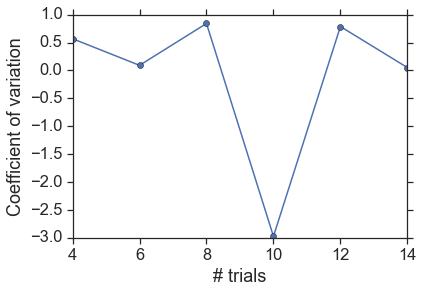

In [429]:
plt.plot(range(4,15,2), cv_mean, 'o-')
plt.ylabel("Coefficient of variation")
plt.xlabel("# trials")

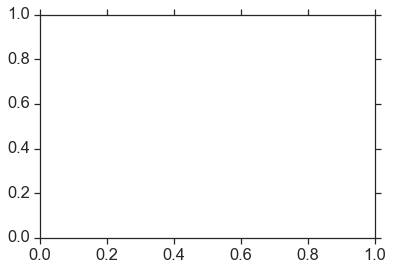

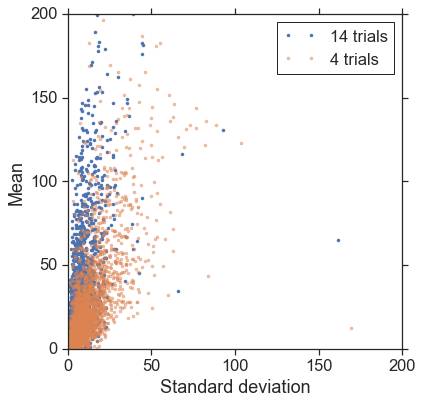

In [432]:
fig, ax = plt.subplots()
plt.figure(figsize=(6,6))
plt.plot(rel_vs_resp_all.std_14, rel_vs_resp_all.mean_14, '.', label='14 trials')
plt.plot(rel_vs_resp_all.std_4, rel_vs_resp_all.mean_4, '.', alpha=0.5, label='4 trials')
plt.xlim(0,200)
plt.ylim(0,200)
plt.xlabel("Standard deviation")
plt.ylabel("Mean")
plt.legend()

In [205]:
def plot_density(x_name, y_name, data, ax = None):
    
    x = data[x_name]
    y = data[y_name]
    xy = np.vstack([x,y])
    z = st.gaussian_kde(xy)
    positions = np.vstack([x.ravel(), y.ravel()])
    
    Z = np.reshape(z(positions).T, x.shape)
    #print z.max()
    if ax == None:
        plt.scatter(x, y, c=z, s=10, edgecolor='', cmap='hot',label = '_nolegend_')

    else:
        ax.scatter(x, y, c=Z, s=20, edgecolor='', cmap='plasma')
        
        
    #plt.colorbar()


In [454]:
rel_vs_resp_all

Empty DataFrame
Columns: [Andermann, DSI, DSI_nm, DSI_trials, DSI_trials_std, Marshel, OSI, OSI_nm, OSI_nmTF, OSI_trials, OSI_trials_std, Roth, Sun, TF, TF_nm, TF_trials, TF_trials_std, Tohmi, area, cell_specimen_id, dsi_10, dsi_12, dsi_14, dsi_4, dsi_6, dsi_8, gOSI, id, mean_10, mean_12, mean_14, mean_4, mean_6, mean_8, osi_10, osi_12, osi_14, osi_4, osi_6, osi_8, p_blank, peak dF/F, pref_ori, reliability, reliability_corr, reliability_marshel, reliability_percentage, std_10, std_12, std_14, std_4, std_6, std_8, tf_10, tf_12, tf_14, tf_4, tf_6, tf_8, cv_4, cv_6, cv_8, cv_10, cv_12, cv_14]
Index: []

[0 rows x 65 columns]

In [449]:
rel_vs_resp_all = rel_vs_resp_all[~np.isnan(rel_vs_resp_all['mean_14'])]
rel_vs_resp_all = rel_vs_resp_all[~np.isnan(rel_vs_resp_all['mean_4'])]
rel_vs_resp_all = rel_vs_resp_all[~np.isnan(rel_vs_resp_all['std_14'])]
rel_vs_resp_all = rel_vs_resp_all[~np.isnan(rel_vs_resp_all['std_4'])]

In [450]:
rel_vs_resp_all = rel_vs_resp_all[rel_vs_resp_all['std_4'] < 0.03]
rel_vs_resp_all = rel_vs_resp_all[rel_vs_resp_all['mean_4'] < 0.03]

rel_vs_resp_all = rel_vs_resp_all[rel_vs_resp_all['std_14'] < 0.03]
rel_vs_resp_all = rel_vs_resp_all[rel_vs_resp_all['mean_14'] < 0.03]

In [451]:
cv_mean = np.empty((6))
for i,nt in enumerate([4,6,8,10,12,14]):
    cv_name = 'cv_'+str(nt)
    cv_mean[i] = np.nanmean(rel_vs_resp_all[cv_name])

In [452]:
cv_mean

array([nan, nan, nan, nan, nan, nan])

ValueError: `dataset` input should have multiple elements.

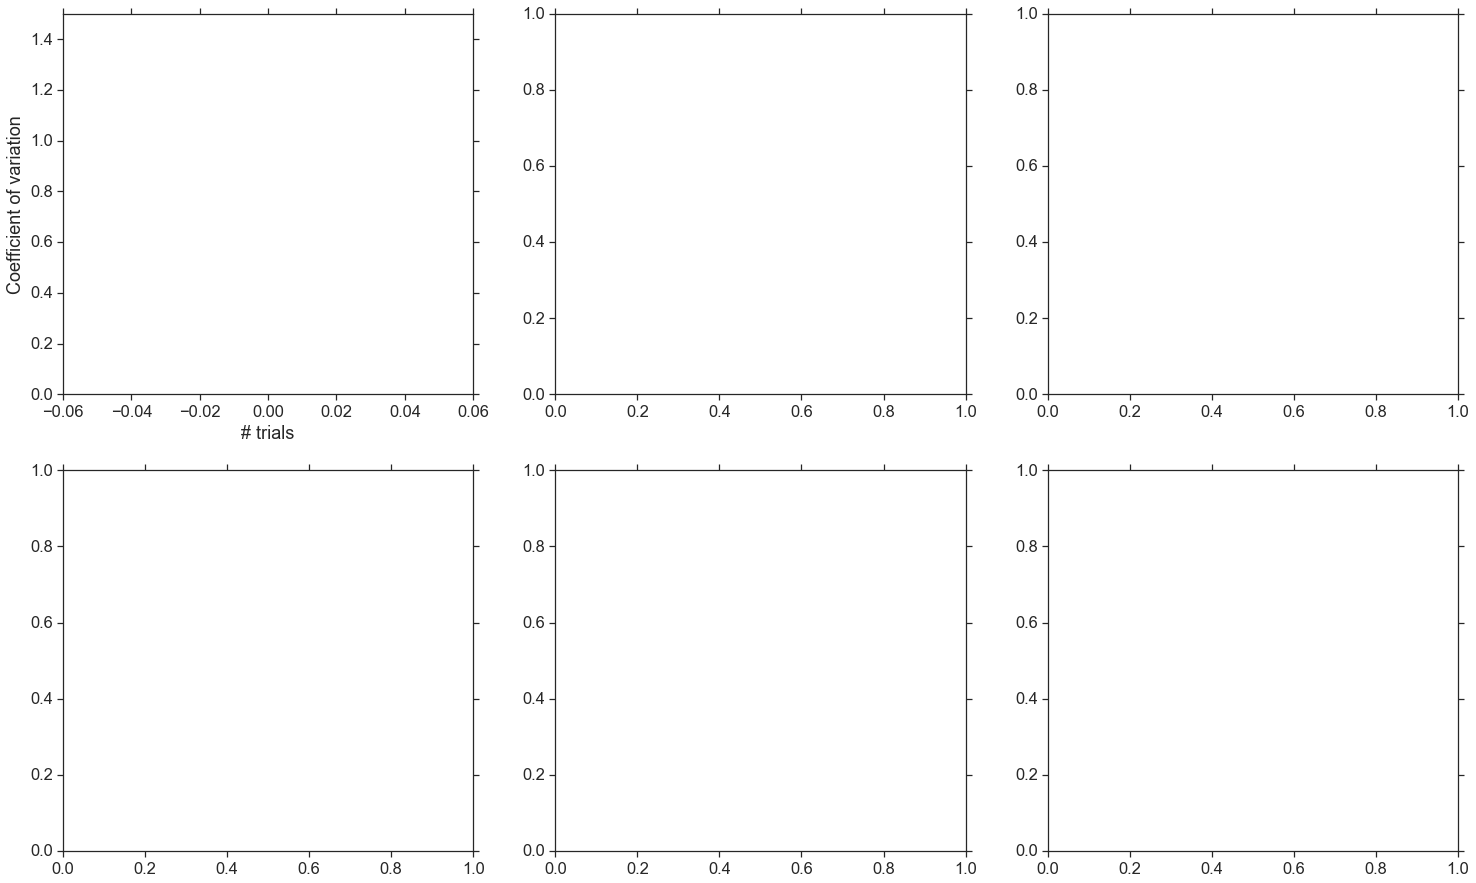

In [453]:
import scipy.stats as st
sns.set(font_scale = 1.5, style = 'white')
#plt.tight_layout()
fig02, axs = plt.subplots(2,3, figsize = (25,15))



ax0 = axs[0,0]

ax1 = axs[0,1]

ax2 = axs[0, 2]

ax3 = axs[1,0]
ax5 = axs[1, 1]
ax4 = axs[1, 2]

ax0.plot(range(4,15,2), cv_mean, 'o-')
ax0.set_ylabel("Coefficient of variation")
ax0.set_xlabel("# trials")


ax0.set_ylim(0,1.5)

plot_density('std_14','mean_14', rel_vs_resp_all, ax1)
plot_density('std_4','mean_4', rel_vs_resp_all, ax2)
ax1.set_ylim(0,0.015)
ax1.set_xlim(0,0.015)

ax2.set_ylim(0,0.015)
ax2.set_xlim(0,0.015)
#ax1.set_title('All cells')
ax0.tick_params(direction = 'in', length = 5, top="off", right="off")

ax1.tick_params(direction = 'in', length = 5, top="off", right="off")
ax2.tick_params(direction = 'in', length = 5, top="off", right="off")

#ax1.plot(np.arange(100), color = 'k', lw = 2, label = 'unity line')
#ax1.set_ylabel('')
ax1.set_xlabel('Standard deviation')
ax1.set_ylabel('Mean')

ax2.set_xlabel('Standard deviation')
ax2.set_ylabel('Mean')

ax1.plot(0.25*np.arange(10), color = 'k', zorder = 0)

ax1.plot(0.5*np.arange(10), color = 'k', zorder = 0)
ax1.plot(np.arange(10), color = 'k', zorder = 0)
ax1.plot(2*np.arange(10), color = 'k', zorder = 0)
ax1.plot(4*np.arange(10), color = 'k', zorder = 0)

ax2.plot(0.25*np.arange(10), color = 'k', zorder = 0)

ax2.plot(0.5*np.arange(10), color = 'k', zorder = 0)
ax2.plot(np.arange(10), color = 'k', zorder = 0)
ax2.plot(2*np.arange(10), color = 'k', zorder = 0)
ax2.plot(4*np.arange(10), color = 'k', zorder = 0)

ax1.annotate('cv = 1', xy = (10,10))
ax1.set_xticks(np.arange(0, 0.015, 0.003))
ax2.set_yticks(np.arange(0, 0.015, 0.003))
ax1.set_yticks(np.arange(0, 0.015, 0.003))
ax2.set_xticks(np.arange(0, 0.015, 0.003))


#ax1.set_xticklabels([])
#ax1.set_yticklabels([])



sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
#fig, ax = plt.subplots(1,3, figsize = (21,7))


color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['osi_12'].values.mean()
    
    ax3.scatter(np.arange(3), [a['osi_4'].values.mean(), a['osi_8'].values.mean(), a['osi_12'].values.mean()], color = color[aa], label = area, s = 40)
    ax5.scatter(np.arange(3), [a['dsi_4'].values.mean(), a['dsi_8'].values.mean(), a['dsi_12'].values.mean()], color = color[aa], label = area, s = 40)
    ax4.scatter(np.arange(3), [a['tf_4'].values.mean(), a['tf_8'].values.mean(), a['tf_12'].values.mean()], color = color[aa], label = area, s = 40)
    
ax3.set_ylabel('OSI')
ax3.set_xlabel('# of trials')
ax4.set_ylabel('DSI')
ax4.set_xlabel('# of trials')
ax5.set_ylabel('TF')
ax5.set_xlabel('# of trials')

ax3.set_xticks(np.arange(3))

ax5.set_xticks(np.arange(3))
ax4.set_xticks(np.arange(3))
ax3.set_xticklabels([4,8,12])

ax5.set_xticklabels([4,8,12])

ax4.set_xticklabels([4,8,12])

ax4.legend(bbox_to_anchor=(1.25, 1.01), fontsize = 'xx-small')
ax3.set_ylim(0,1)
ax5.set_ylim(0,1)
ax4.set_ylim(0,3)

ax3.tick_params(direction = 'in', length = 5, top="off", right="off")
ax5.tick_params(direction = 'in', length = 5, top="off", right="off")
ax4.tick_params(direction = 'in', length = 5, top="off", right="off")
plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6.pdf")

In [ ]:
ax1.annotate('cv = 1', xy = (2,1), xycoords = 'data', fontsize = 100)

In [366]:
ax1.annotate('axes fraction',
            xy=(3, 1), xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')


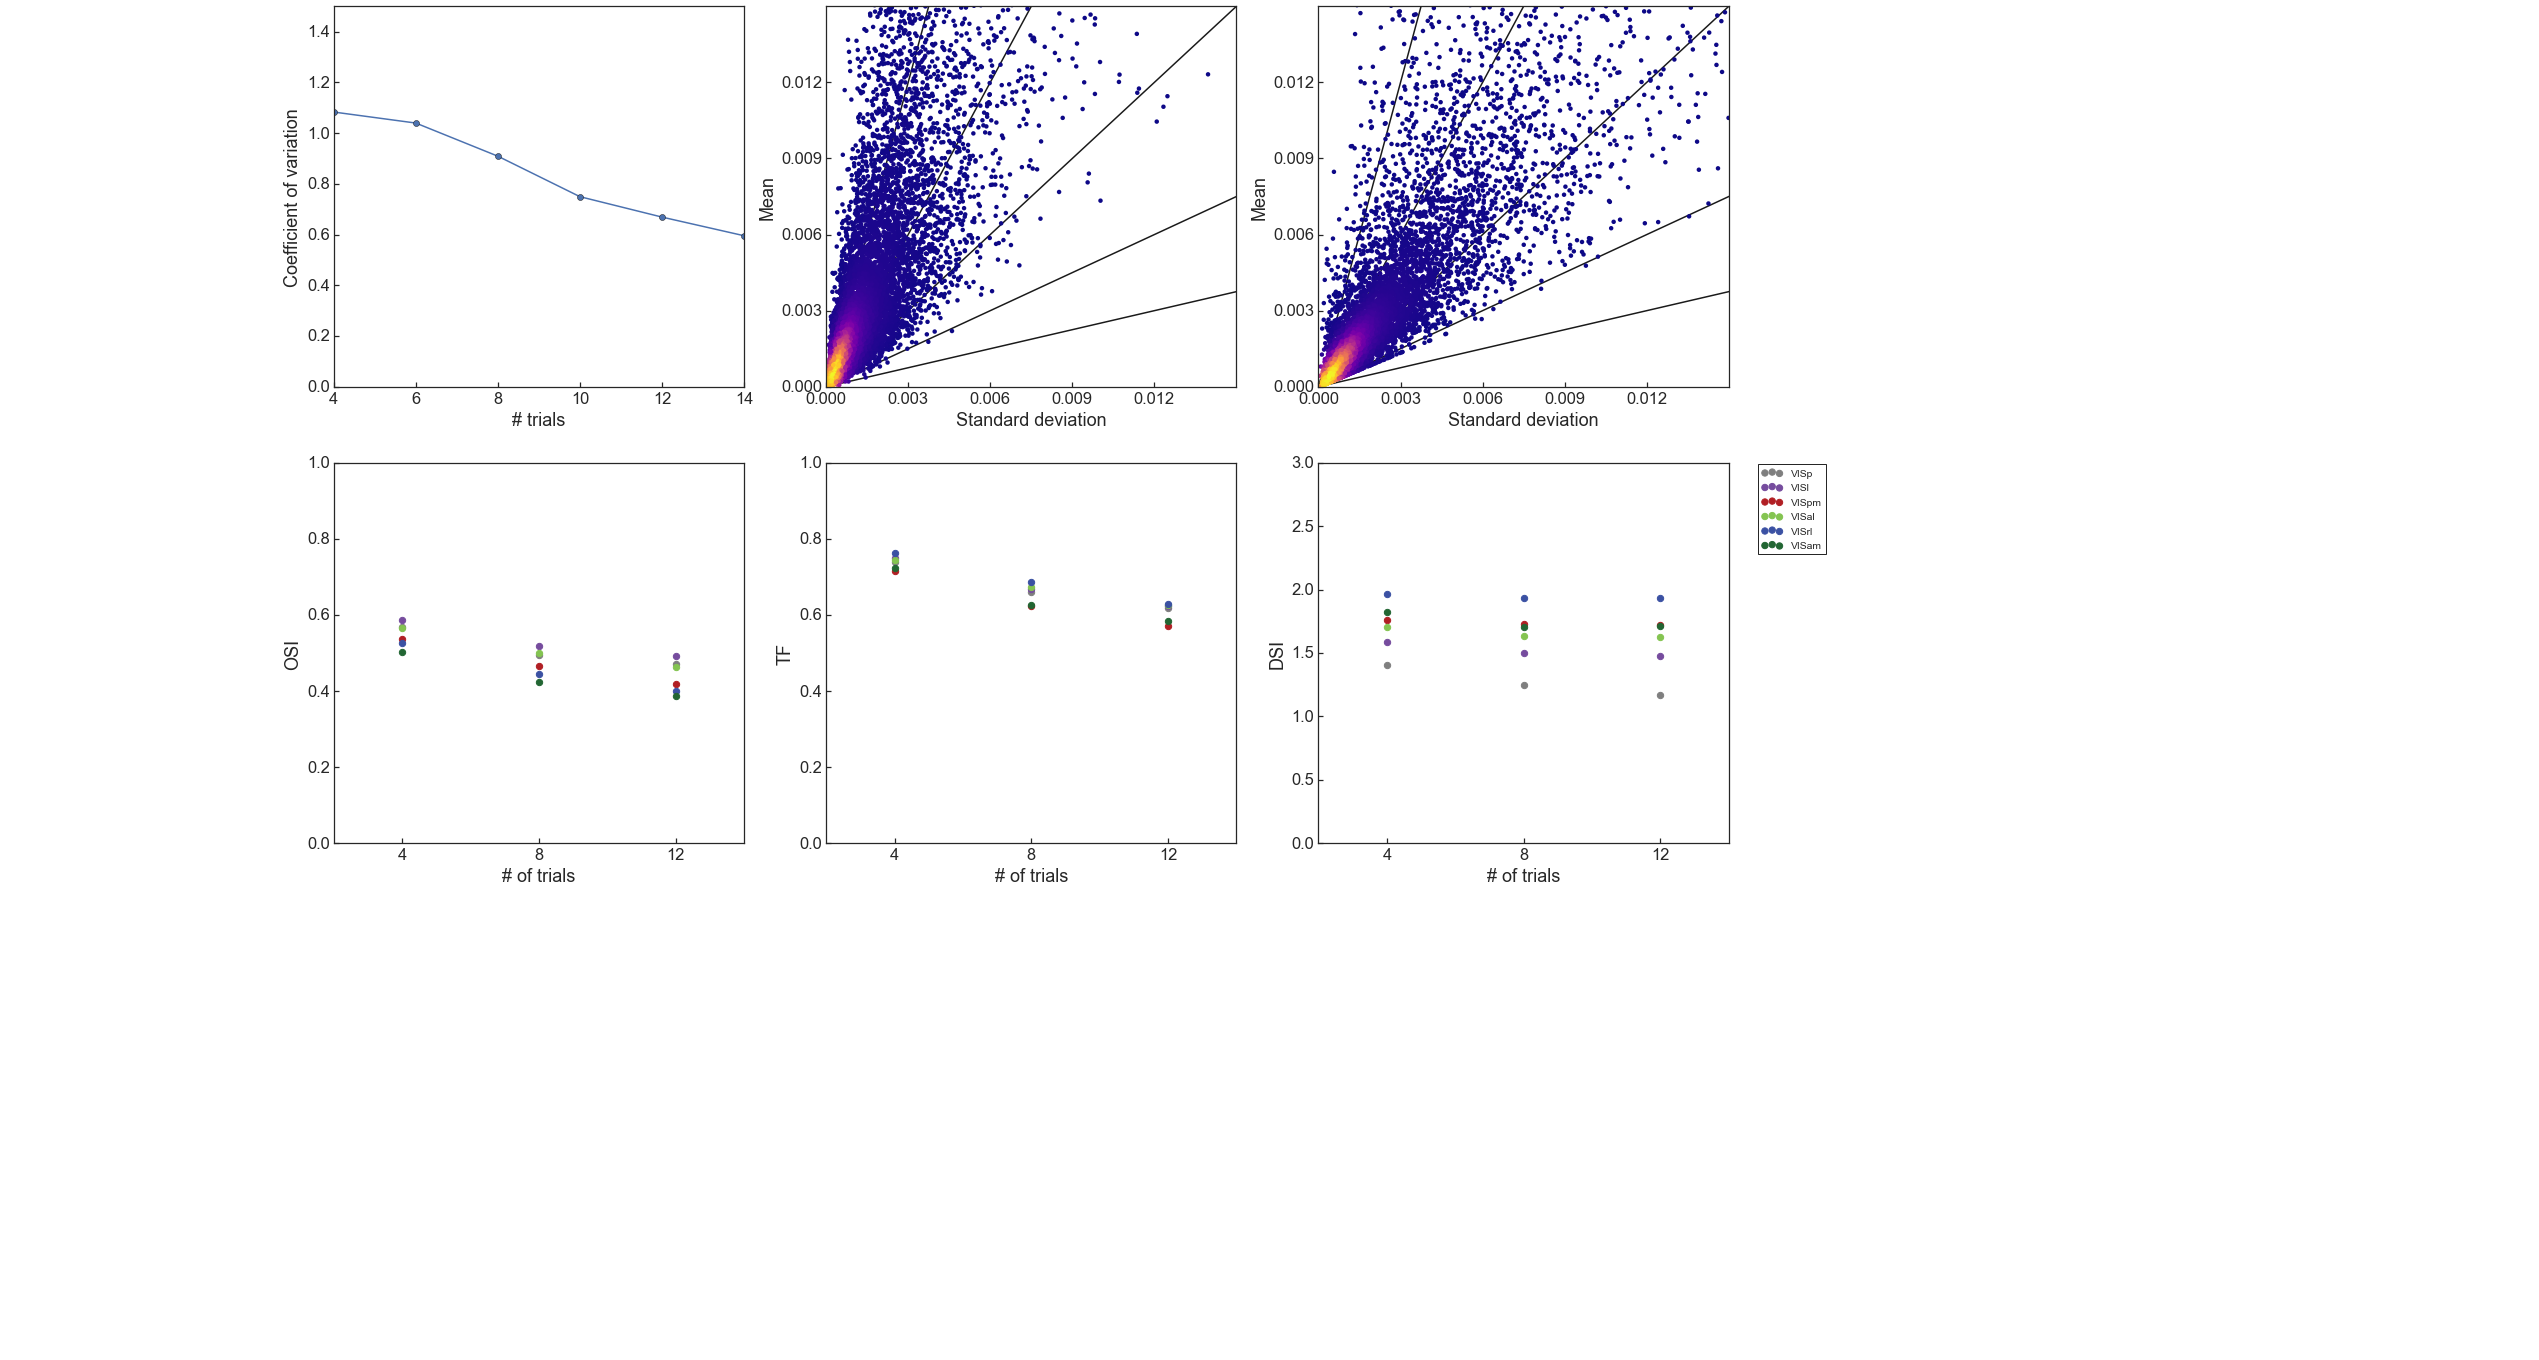

In [367]:
fig02

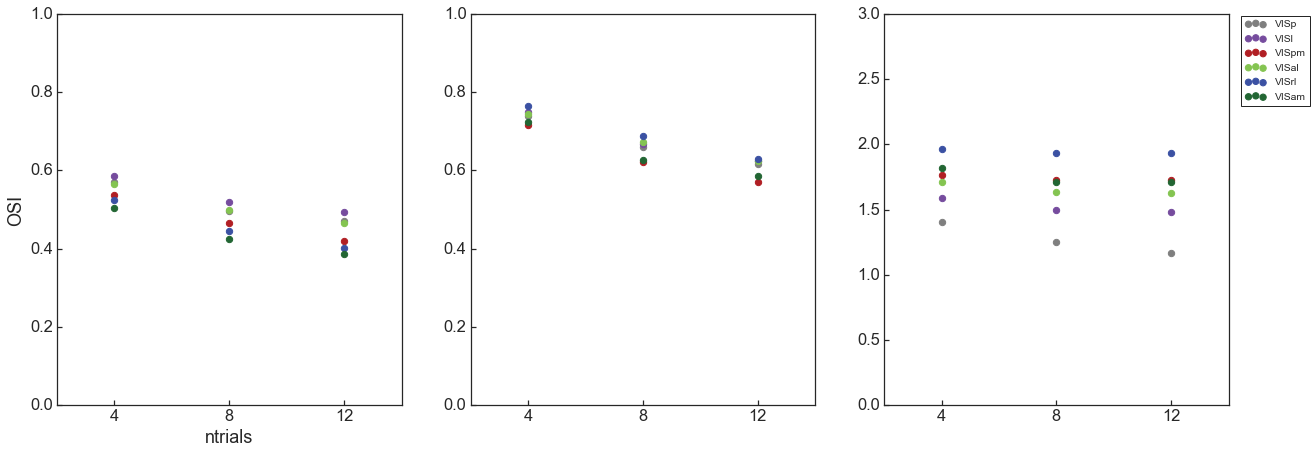

In [277]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,3, figsize = (21,7))

ax3 = ax[0]
ax5 = ax[1]
ax4 = ax[2]
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['osi_12'].values.mean()
    
    ax3.scatter(np.arange(3), [a['osi_4'].values.mean(), a['osi_8'].values.mean(), a['osi_12'].values.mean()], color = color[aa], label = area, s = 40)
    ax5.scatter(np.arange(3), [a['dsi_4'].values.mean(), a['dsi_8'].values.mean(), a['dsi_12'].values.mean()], color = color[aa], label = area, s = 40)
    ax4.scatter(np.arange(3), [a['tf_4'].values.mean(), a['tf_8'].values.mean(), a['tf_12'].values.mean()], color = color[aa], label = area, s = 40)
    
ax3.set_ylabel('OSI')
ax3.set_xlabel('ntrials')
ax3.set_xticks(np.arange(3))

ax5.set_xticks(np.arange(3))
ax4.set_xticks(np.arange(3))
ax3.set_xticklabels([4,8,12])

ax5.set_xticklabels([4,8,12])

ax4.set_xticklabels([4,8,12])

ax4.legend(bbox_to_anchor=(1.25, 1.01), fontsize = 'xx-small')
ax3.set_ylim(0,1)
ax5.set_ylim(0,1)
ax4.set_ylim(0,3)

ax3.tick_params(direction = 'in', length = 5, top="off", right="off")
ax5.tick_params(direction = 'in', length = 5, top="off", right="off")
ax4.tick_params(direction = 'in', length = 5, top="off", right="off")
plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-5_OSI_trials.pdf")

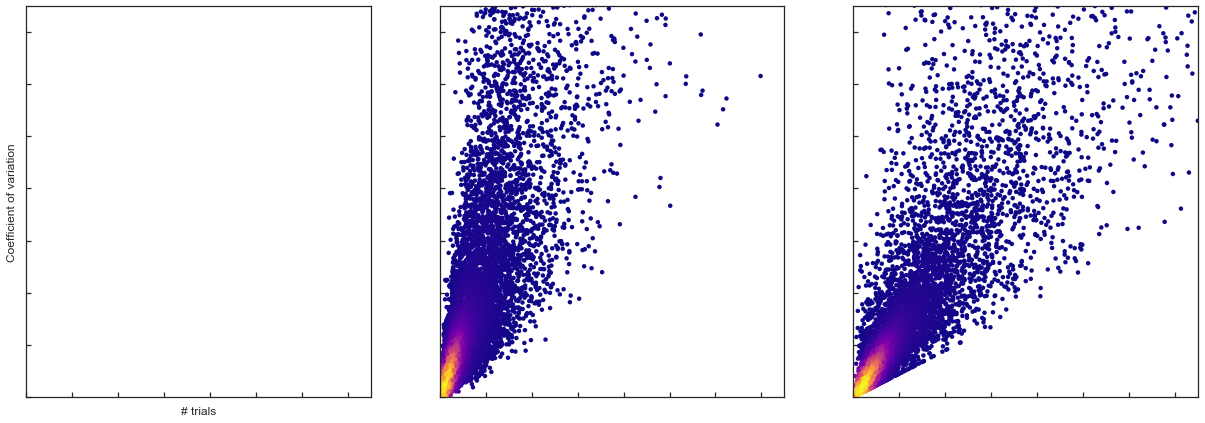

In [232]:
fig02

In [128]:
for ii, exp in enumerate(cell_exp):     
    print("Experiment with drifting gratings:")
    pprint.pprint(exp)
    rel_vs_resp = pd.DataFrame(columns = ['cell_specimen_id',
                                          'id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'DSI_nm',
                                          'DSI_trials',
                                          'DSI_trials_std',
                                          'OSI_trials',
                                          'OSI_trials_std',
                                          'TF_trials',
                                          'TF_trials_std',
                                          'OSI',
                                          'OSI_nm',
                                          'TF',
                                          'TF_nm',    
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun'])    
    #file_name = os.path.join(ophys_experiment_path, str(exp['id']))

    data_set = boc.get_ophys_experiment_data(exp['id'])

    save_path = r"E:/"

    cells = data_set.get_cell_specimen_ids()
    stim_table = data_set.get_stimulus_table(stim_info.DRIFTING_GRATINGS)
    print "spot"
    data_file_dg = os.path.join(save_path,'DriftingGratings', str(exp['id']) + "_dg_events_analysis.h5")


    mean_sweep_events = pd.read_hdf(data_file_dg, 'mean_sweep_events')
    peak = pd.read_hdf(data_file_dg, 'peak')
    numcells = peak.shape[0]
    orivals = np.array(range(0,360,45))
    orivals_rad = np.deg2rad(orivals)
    tfvals = np.array([1,2,4,8,15])
    print "run"

    osi_array = np.empty((numcells, 11))
    dsi_array = np.empty((numcells, 11))
    tf_array = np.empty((numcells, 11))
    osi_std = np.empty((numcells,11))
    dsi_std = np.empty((numcells,11))
    tf_std = np.empty((numcells,11))
    for j,n_trials in enumerate(range(4,15)):
        DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
        OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
        TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
        #print 'j'
        response_array_first, response_array_second = cross_validate_response(50, numcells, n_trials)
        print j
        for ni in range(50):
            m = np.max(response_array_first[:,:,:,ni], axis=(0,1)) 
#print m.shape
            a = response_array_first[:,:,:,ni]==np.nanmax(response_array_first[:,:,:,ni], axis=(0,1))
            sortval = np.where(a)
            un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
            newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]
            pref_ori = newsortval[0]
            pref_tf = newsortval[1]

            TF.loc[ni] = pref_tf


            #osi
            inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
            tuning = response_array_second[:, inds[1], inds[2],ni]
            tuning = np.where(tuning>0, tuning, 0)
            CV_top_os = np.empty((8, numcells), dtype=np.complex128)
            CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
            for i in range(8):
                CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
                CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

            OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



            #dsi
            null_ori= np.mod(pref_ori+4, 8)
            pref = response_array_second[inds[0], inds[1], inds[2], ni]
            null = response_array_second[null_ori, inds[1], inds[2], ni]
            null = np.where(null>0, null, 0)

            DSI.loc[ni] = (pref-null)/(pref+null)

        osi_array[:,j] = OSI.mean().values
        osi_std[:,j] = OSI.std().values
        dsi_array[:,j] = DSI.mean().values
        dsi_std[:,j] = DSI.std().values
        tf_array[:,j] = TF.mean().values
        tf_std[:,j] = TF.std().values

        print 'yay' 

    rel_vs_resp['DSI_nm'] = dsi_array[:,10]
    rel_vs_resp['OSI_nm'] = osi_array[:,10]
    rel_vs_resp['TF_nm'] = tf_array[:,10]


    for jj in range(numcells):
        rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
        rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
        rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
        rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
        rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
        rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]










    dg = DriftingGratings(data_set)
    stim_table = dg.stim_table

    print rel_vs_resp.head()
    # create dataframe with reliability, peak dF/F, and whether they passed each criterion

    rel_vs_resp['DSI'] = dg.peak.dsi_dg
    rel_vs_resp['pref_ori'] = dg.peak.ori_dg
    rel_vs_resp['gOSI'] = dg.peak.cv_os_dg
    rel_vs_resp['OSI'] = dg.peak.osi_dg
    rel_vs_resp['cell_specimen_id'] = dg.cell_id
    rel_vs_resp['TF'] = dg.peak.tf_dg
    rel_vs_resp['reliability'] = dg.peak.reliability_dg
    rel_vs_resp['peak dF/F'] = dg.peak.peak_dff_dg
    rel_vs_resp['Sun'] = rel_vs_resp['peak dF/F']> 10
    rel_vs_resp['id'] = exp['id']
    rel_vs_resp['area'] = exp['targeted_structure']

    mean_sweep_response = dg.mean_sweep_response
    for cell in range(dg.numbercells):
        # Andermann
        pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[cell]]
        pref_ori = dg.orivals[dg.peak.ori_dg.iloc[cell]]
        resp_tf = mean_sweep_response[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)][str(cell)].values
        resp_blank = mean_sweep_response[stim_table['blank_sweep']==True][str(cell)].values
        t2, p2 = sc.stats.ttest_ind(resp_tf,resp_blank)
        rel_vs_resp['p_blank'] = p2
        rel_vs_resp['Andermann'].iloc[cell] = p2 < 0.05/40

        # Marshel 
        stdev_tf = sc.std(resp_tf)
        mean_tf = np.mean(resp_tf)
        stdev_blank = sc.std(resp_blank)
        mean_blank = np.mean(resp_blank)
        reliability = (mean_tf- mean_blank) / (stdev_tf + stdev_blank)
        rel_vs_resp['Marshel'].iloc[cell] = (reliability > 1) 
        rel_vs_resp['reliability_marshel'].iloc[cell] = reliability

        #Roth
        resp_baseline = dg.sweep_response[str(cell)].apply(lambda x : x[:30])
        resp = dg.sweep_response[str(cell)].apply(lambda x : x[30:90])
        resp_baseline_mean  = resp_baseline.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_std = resp_baseline.apply(np.std)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        rel_vs_resp['Roth'].iloc[cell] = np.sum((resp_mean > (resp_baseline_mean + resp_baseline_std*3)))/np.float(resp_baseline_mean.shape[0])>0.5
        rel_vs_resp['reliability_percentage'] = np.sum(resp_mean > (resp_baseline_mean + resp_baseline_std*2))/np.float(resp_baseline_mean.shape[0])

        # Tohmi 
        sweep_resp_pref = dg.sweep_response[(stim_table.orientation==pref_ori) & (stim_table.temporal_frequency==pref_tf)][str(cell)]
        mean_sweep_resp_pref = sweep_resp_pref.mean()
        max_resp = mean_sweep_resp_pref[30:90].max()
        rel_vs_resp['Tohmi'].iloc[cell] = max_resp > 4

        # Reliability corr 
        rel_vs_resp['reliability_corr'].iloc[cell] = np.mean(np.corrcoef(np.array([a for a in sweep_resp_pref]))[np.triu_indices(sweep_resp_pref.shape[0],k=1)])
       #rel_vs_resp['reliability_percentage'].iloc[cell] = 

    rel_vs_resp_all = rel_vs_resp_all.append(rel_vs_resp)

Experiment with drifting gratings:
{'acquisition_age_days': 111,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 701412138,
 'fail_eye_tracking': True,
 'id': 704298735,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISp'}


IOError: Unable to open file (truncated file: eof = 387435008, sblock->base_addr = 0, stored_eof = 392976950)

In [87]:
np.unique(rel_vs_resp_all['area'].values)

array([u'VISal', u'VISam', u'VISl', u'VISp', u'VISpm'], dtype=object)

In [106]:
rel_vs_resp_all = rel_vs_resp_all.append(rel_vs_resp)


In [133]:
rel_vs_resp_all['DSI_trials']

0      [0.26598511783269285, -0.04716541044473907, 0....
1      [-0.07861720489157226, -0.06140487673439876, 0...
2      [0.03339520560139325, 0.039148355695330275, -0...
3      [-0.2426496798486787, 0.1291957551768117, 0.07...
4      [-0.0035243960407298314, -0.007628373555184165...
5      [0.12216310513356525, 0.06180196409575733, 0.0...
6      [0.26671297335828015, 0.18477251902122835, 0.3...
7      [0.0891129643963754, 0.19315317485721503, 0.14...
8      [-0.011335181391274742, 0.18141082921028095, 0...
9      [0.25337802241346963, -0.14954172010740585, -0...
10     [0.5087415512215617, 0.31108314686869326, 0.62...
11     [-0.09347240664093975, 0.11532801121152057, 0....
12     [0.3650927870012211, 0.4168814543826126, 0.571...
13     [-0.06574400827876432, -0.1344222209688763, -0...
14     [0.4434765551745948, 0.5430673443887564, 0.547...
15     [-0.10361841199598351, 0.1631423766825075, 0.0...
16     [-0.18813784817870174, 0.003533060508921307, -...
17     [-0.30887985240240884, -

In [196]:
np.nansum(np.stack([tp, val]), axis = 0)


array([0.17609888, 0.29733573, 0.62093866, 0.35266625, 0.44642197,
       0.06946047, 0.0648005 , 0.31336693, 0.1480737 , 0.25937869,
       0.16265067])

In [232]:
import seaborn as sns
sns.set_style("white")

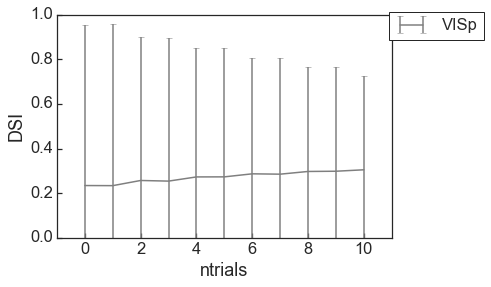

In [234]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F']#,'#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp']#, 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['DSI_trials'].values
    c = a['DSI_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b):
        if type(b) != float: 
            #print b
            
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
    sd = sd/len(b)
            
    #ax.scatter(np.arange(11), tp, color = color[aa], label = area)
    ax.errorbar(np.arange(11), tp, yerr = sd, color = color[aa], label = area)
ax.set_ylabel('DSI')
ax.set_xlabel('ntrials')
ax.set_xlim(-1, 11)
#ax.set_xticklabels([4,8,14])

ax.tick_params(direction = 'in', length = 5, top="off", right="off")

plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylim(0,1)


plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-1_DSI_trials.pdf")


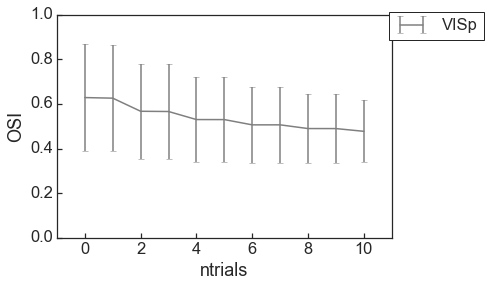

In [236]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F']#,'#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp']#, 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['OSI_trials'].values
    c = a['OSI_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b):
        if type(b) != float: 
            #print b
            
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
    sd = sd/len(b)
            
    #ax.scatter(np.arange(11), tp, color = color[aa], label = area)
    ax.errorbar(np.arange(11), tp, yerr = sd, color = color[aa], label = area)
ax.set_ylabel('OSI')
ax.set_xlabel('ntrials')
ax.set_xlim(-1, 11)
#ax.set_xticklabels([4,8,14])

plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylim(0,1)

ax.tick_params(direction = 'in', length = 5, top="off", right="off")


plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-2_OSI_trials.pdf")


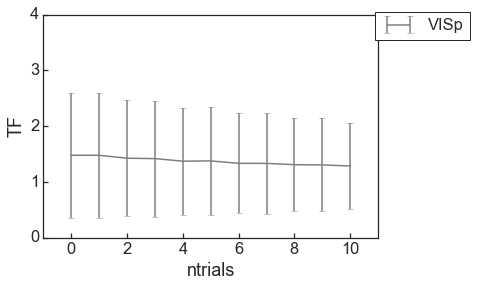

In [240]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F']#,'#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp']#, 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['TF_trials'].values
    c = a['TF_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b):
        if type(b) != float: 
            #print b
            
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
    sd = sd/len(b)
            
    #ax.scatter(np.arange(11), tp, color = color[aa], label = area)
    ax.errorbar(np.arange(11), tp, yerr = sd, color = color[aa], label = area)
ax.set_ylabel('TF')
ax.set_xlabel('ntrials')
ax.set_xlim(-1, 11)
#ax.set_xticklabels([4,8,14])
ax.set_yticks([0,1,2,3,4])

ax.tick_params(direction = 'in', length = 5, top="off", right="off")


plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylim(0,4)


plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-3_TF_trials.pdf")

In [ ]:

rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F']#,'#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp']#, 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['OSI_trials'].values
    c = a['OSI_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b):
        if type(b) != float: 
            #print b
            
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
    sd = sd/len(b)
            
    #ax.scatter(np.arange(11), tp, color = color[aa], label = area)
    ax.errorbar(np.arange(11), tp, yerr = sd, color = color[aa], label = area)
ax.set_ylabel('DSI')
ax.set_xlabel('ntrials')
ax.set_xlim(-1, 11)
#ax.set_xticklabels([4,8,14])

plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylim(-0.5,1)

In [206]:
np.sum(rvra['DSI_trials'].apply(np.sum).apply(np.isnan))

3

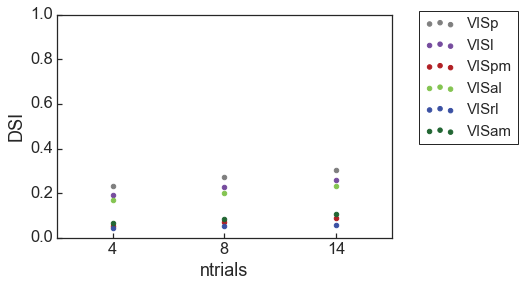

In [244]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['DSI_trials'].values
    c = a['DSI_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b):
        if type(b) != float: 
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
            
    ax.scatter(np.arange(3), np.array([tp[0], tp[5], tp[10]]) , color = color[aa], label = area)
    
ax.set_ylabel('DSI')
ax.set_xlabel('ntrials')
ax.set_xticks(np.arange(3))
ax.set_xticklabels([4,8,14])



plt.legend(fontsize = 'small', bbox_to_anchor=(1.4, 1.05))
plt.ylim(0,1)


ax.tick_params(direction = 'in', length = 5, top="off", right="off")
plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-4_DSI_trials.pdf")

In [157]:
tp

array([0.06409064, 0.06775511, 0.07696075, 0.07765869, 0.08187604,
       0.08326055, 0.08766327, 0.09252004, 0.10342803, 0.10257088,
       0.10571836])

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


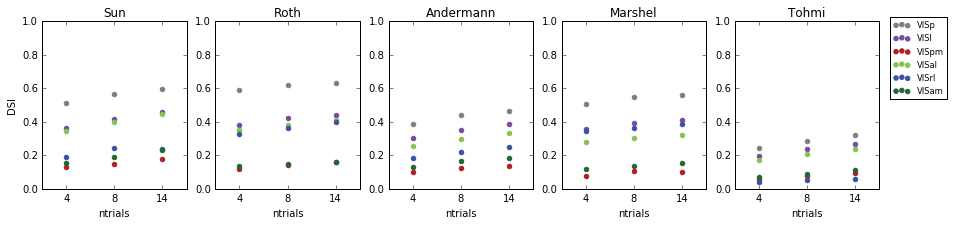

In [229]:
fig, ax = plt.subplots(1,5, figsize = (15, 3))

criteria = ['Sun', 'Roth', 'Andermann', 'Marshel', 'Tohmi']
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for i, axs in enumerate(ax.flat):
    rvra = rel_vs_resp_all[rel_vs_resp_all[criteria[i]] == True]
    
    
   # fig, ax = plt.subplots(1,1)

    for aa, area in enumerate(areas): 
        a = rvra[rvra['area'] == area]
        b = a['DSI_trials'].values
        c = a['DSI_trials_std'].values
        sd = np.zeros(11)
        tp = np.zeros(11)
        for rr, val in enumerate(b):
            if type(b) != float: 
                tp = np.nansum(np.stack([tp, val]), axis = 0)
                sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)

        tp = tp/len(b)

        axs.scatter(np.arange(3), [tp[0], tp[5], tp[10]], color = color[aa], label = area)


    axs.set_xlabel('ntrials')
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels([4,8,14])
    axs.set_ylim(0,1)
    axs.set_title(criteria[i])

    plt.legend(fontsize = 'small', bbox_to_anchor=(1.5, 1.05))
    
    
ax[0].set_ylabel('DSI')

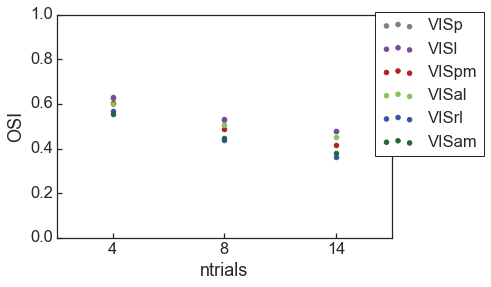

In [245]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['OSI_trials'].values
    c = a['OSI_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b): 
        if type(b) != float: 
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
            
    ax.scatter(np.arange(3), [tp[0], tp[5], tp[10]], color = color[aa], label = area)
    #ax.errorbar(np.arange(3), [tp[0], tp[5], tp[10]], yerr= [sd[0], sd[5], sd[10]], ls = 'None')
ax.set_ylabel('OSI')
ax.set_xlabel('ntrials')
ax.set_xticks(np.arange(3))
ax.set_xticklabels([4,8,14])

plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylim(0,1)


ax.tick_params(direction = 'in', length = 5, top="off", right="off")
plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-5_OSI_trials.pdf")

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


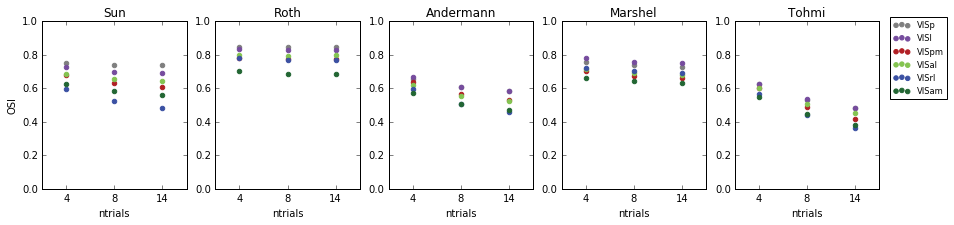

In [222]:
fig, ax = plt.subplots(1,5, figsize = (15, 3))
sns.set(font_scale = 1.5, style = 'white')
criteria = ['Sun', 'Roth', 'Andermann', 'Marshel', 'Tohmi']
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for i, axs in enumerate(ax.flat):
    rvra = rel_vs_resp_all[rel_vs_resp_all[criteria[i]] == True]
    
    
   # fig, ax = plt.subplots(1,1)

    for aa, area in enumerate(areas): 
        a = rvra[rvra['area'] == area]
        b = a['OSI_trials'].values
        c = a['OSI_trials_std'].values
        sd = np.zeros(11)
        tp = np.zeros(11)
        for rr, val in enumerate(b):
            if type(b) != float: 
                tp = np.nansum(np.stack([tp, val]), axis = 0)
                sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)

        tp = tp/len(b)

        axs.scatter(np.arange(3), [tp[0], tp[5], tp[10]], color = color[aa], label = area)


    axs.set_xlabel('ntrials')
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels([4,8,14])
    axs.set_ylim(0,1)
    axs.set_title(criteria[i])

    plt.legend(fontsize = 'small', bbox_to_anchor=(1.5, 1.05))
    
    
ax[0].set_ylabel('OSI')

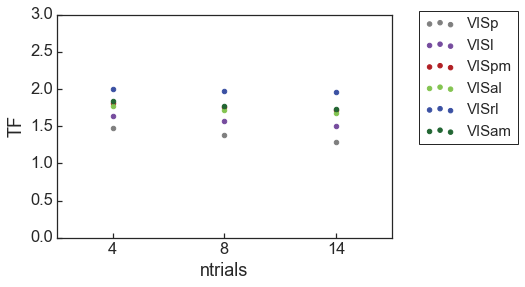

In [249]:
sns.set(font_scale = 1.5, style = 'white')
rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for aa, area in enumerate(areas): 
    a = rvra[rvra['area'] == area]
    b = a['TF_trials'].values
    c = a['TF_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b): 
        if type(b) != float: 
            tp = np.nansum(np.stack([tp, val]), axis = 0)
            sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)
            
    tp = tp/len(b)
            
    ax.scatter(np.arange(3), [tp[0], tp[5], tp[10]], color = color[aa], label = area)
    
ax.set_ylabel('TF')
ax.set_xlabel('ntrials')
ax.set_xticks(np.arange(3))
ax.set_xticklabels([4,8,14])

plt.legend(fontsize = 'small', bbox_to_anchor=(1.4, 1.05))

plt.ylim(0,3)



ax.tick_params(direction = 'in', length = 5, top="off", right="off")
plt.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\fig6-5_TF_trials.pdf")

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


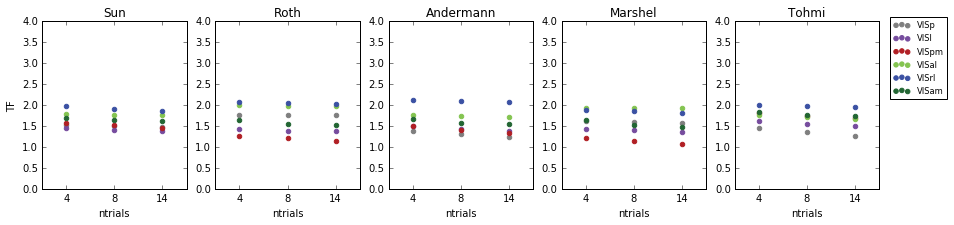

In [231]:
fig, ax = plt.subplots(1,5, figsize = (15, 3))

criteria = ['Sun', 'Roth', 'Andermann', 'Marshel', 'Tohmi']
color = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISp', 'VISl', 'VISpm', 'VISal', 'VISrl', 'VISam']
for i, axs in enumerate(ax.flat):
    rvra = rel_vs_resp_all[rel_vs_resp_all[criteria[i]] == True]
    
    
   # fig, ax = plt.subplots(1,1)

    for aa, area in enumerate(areas): 
        a = rvra[rvra['area'] == area]
        b = a['TF_trials'].values
        c = a['TF_trials_std'].values
        sd = np.zeros(11)
        tp = np.zeros(11)
        for rr, val in enumerate(b):
            if type(b) != float: 
                tp = np.nansum(np.stack([tp, val]), axis = 0)
                sd = np.nansum(np.stack([sd, c[rr]]), axis = 0)

        tp = tp/len(b)

        axs.scatter(np.arange(3), [tp[0], tp[5], tp[10]], color = color[aa], label = area)


    axs.set_xlabel('ntrials')
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels([4,8,14])
    axs.set_ylim(0,4)
    axs.set_title(criteria[i])

    plt.legend(fontsize = 'small', bbox_to_anchor=(1.5, 1.05))
    
    
ax[0].set_ylabel('TF')

In [ ]:

rvra = rel_vs_resp_all
fig, ax = plt.subplots(1,1)
color = ['r'] # ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']
areas = ['VISal'] #['VISp', 'VISpm', 'VISam', 'VISlm', 'VISrl', 'VISal']
for area in areas: 
    a = rvra[rvra['area'] == area]
    b = a['DSI_trials'].values
    c = a['DSI_trials_std'].values
    sd = np.zeros(11)
    tp = np.zeros(11)
    for rr, val in enumerate(b): 
        if type(b) != float: 
            tp = tp+ val
            sd = sd + c[rr]
            
    tp = tp/len(b)
            
    ax.scatter(np.arange(3), [tp[0], tp[5], tp[10]], color = color, label = area)
    
ax.set_ylabel('TF')
ax.set_xlabel('ntrials')
ax.set_xticks(np.arange(3))
ax.set_xticklabels([4,8,14])


In [271]:
rel_vs_resp = pd.DataFrame(columns = ['cell_specimen_id',
                                      'id',
                                      'area',
                                      'reliability',
                                      'reliability_marshel',
                                      'reliability_corr',
                                      'DSI',
                                      'DSI_nm',
                                      'DSI_trials',
                                      'DSI_trials_std',
                                      'OSI_trials',
                                      'OSI_trials_std',
                                      'TF_trials',
                                      'TF_trials_std',
                                      'OSI',
                                      'OSI_nm'
                                      'TF',
                                      'TF_nm',    
                                      'pref_ori',
                                      'peak dF/F', 
                                      'Tohmi', 
                                      'Marshel',
                                      'Andermann', 
                                      'Roth', 
                                      'Sun']) 
mean_sweep_events = pd.read_hdf(data_file_dg, 'mean_sweep_events')
peak = pd.read_hdf(data_file_dg, 'peak')
numcells = peak.shape[0]
orivals = np.array(range(0,360,45))
orivals_rad = np.deg2rad(orivals)
tfvals = np.array([1,2,4,8,15])
print "run"

osi_array = np.empty((numcells, 11))
dsi_array = np.empty((numcells, 11))
tf_array = np.empty((numcells, 11))
osi_std = np.empty((numcells,11))
dsi_std = np.empty((numcells,11))
tf_std = np.empty((numcells,11))
for j,n_trials in enumerate(range(4,15)):
    DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
    OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
    TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
    #print 'j'
    response_array_first, response_array_second = cross_validate_response(50, numcells, n_trials)
    print j
    for ni in range(50):
        m = np.max(response_array_first[:,:,:,ni], axis=(0,1)) 
        #print m.shape
        a = response_array_first[:,:,:,ni]==np.max(response_array_first[:,:,:,ni], axis=(0,1))
        un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
        newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]
        pref_ori = newsortval[0]
        pref_tf = newsortval[1]

        TF.loc[ni] = pref_tf

        #osi
        inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
        tuning = response_array_second[:, inds[1], inds[2],ni]
        tuning = np.where(tuning>0, tuning, 0)
        CV_top_os = np.empty((8, numcells), dtype=np.complex128)
        CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
        for i in range(8):
            CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
            CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

        OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



        #dsi
        null_ori= np.mod(pref_ori+4, 8)
        pref = response_array_second[inds[0], inds[1], inds[2], ni]
        null = response_array_second[null_ori, inds[1], inds[2], ni]
        null = np.where(null>0, null, 0)

        DSI.loc[ni] = (pref-null)/(pref+null)

    osi_array[:,j] = OSI.mean().values
    osi_std[:,j] = OSI.std().values
    dsi_array[:,j] = DSI.mean().values
    dsi_std[:,j] = DSI.std().values
    tf_array[:,j] = TF.mean().values
    tf_std[:,j] = TF.std().values

    #print 'yay' 
#reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
rel_vs_resp['DSI_nm'] = dsi_array[:,10]
rel_vs_resp['OSI_nm'] = osi_array[:,10]
rel_vs_resp['TF_nm'] = tf_array[:,10]


for jj in range(numcells):
    rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
    rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
    rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
    rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
    rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
    rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]




        
        
        

run
0
1
2
3
4
5
6
7
8
9
10


cell_specimen_id   id area reliability reliability_marshel  \
0                NaN  NaN  NaN         NaN                 NaN   
1                NaN  NaN  NaN         NaN                 NaN   
2                NaN  NaN  NaN         NaN                 NaN   
3                NaN  NaN  NaN         NaN                 NaN   
4                NaN  NaN  NaN         NaN                 NaN   
5                NaN  NaN  NaN         NaN                 NaN   
6                NaN  NaN  NaN         NaN                 NaN   
7                NaN  NaN  NaN         NaN                 NaN   
8                NaN  NaN  NaN         NaN                 NaN   
9                NaN  NaN  NaN         NaN                 NaN   
10               NaN  NaN  NaN         NaN                 NaN   
11               NaN  NaN  NaN         NaN                 NaN   
12               NaN  NaN  NaN         NaN                 NaN   
13               NaN  NaN  NaN         NaN                 NaN   
14               NaN  NaN  NaN         NaN                 NaN   
15               NaN  NaN  NaN         NaN                 NaN   
16               NaN  NaN  NaN         NaN                 NaN   
17               NaN  NaN  NaN         NaN                 NaN   
18               NaN  NaN  NaN         NaN                 NaN   
19               NaN  NaN  NaN         NaN                 NaN   
20               NaN  NaN  NaN         NaN                 NaN   
21               NaN  NaN  NaN         NaN                 NaN   
22               NaN  NaN  NaN         NaN                 NaN   
23               NaN  NaN  NaN         NaN                 NaN   
24               NaN  NaN  NaN         NaN                 NaN   
25               NaN  NaN  NaN         NaN                 NaN   
26               NaN  NaN  NaN         NaN                 NaN   
27               NaN  NaN  NaN         NaN                 NaN   
28               NaN  NaN  NaN         NaN                 NaN   
29               NaN  NaN  NaN         NaN                 NaN   
..               ...  ...  ...         ...                 ...   
257              NaN  NaN  NaN         NaN                 NaN   
258              NaN  NaN  NaN         NaN                 NaN   
259              NaN  NaN  NaN         NaN                 NaN   
260              NaN  NaN  NaN         NaN                 NaN   
261              NaN  NaN  NaN         NaN                 NaN   
262              NaN  NaN  NaN         NaN                 NaN   
263              NaN  NaN  NaN         NaN                 NaN   
264              NaN  NaN  NaN         NaN                 NaN   
265              NaN  NaN  NaN         NaN                 NaN   
266              NaN  NaN  NaN         NaN                 NaN   
267              NaN  NaN  NaN         NaN                 NaN   
268              NaN  NaN  NaN         NaN                 NaN   
269              NaN  NaN  NaN         NaN                 NaN   
270              NaN  NaN  NaN         NaN                 NaN   
271              NaN  NaN  NaN         NaN                 NaN   
272              NaN  NaN  NaN         NaN                 NaN   
273              NaN  NaN  NaN         NaN                 NaN   
274              NaN  NaN  NaN         NaN                 NaN   
275              NaN  NaN  NaN         NaN                 NaN   
276              NaN  NaN  NaN         NaN                 NaN   
277              NaN  NaN  NaN         NaN                 NaN   
278              NaN  NaN  NaN         NaN                 NaN   
279              NaN  NaN  NaN         NaN                 NaN   
280              NaN  NaN  NaN         NaN                 NaN   
281              NaN  NaN  NaN         NaN                 NaN   
282              NaN  NaN  NaN         NaN                 NaN   
283              NaN  NaN  NaN         NaN                 NaN   
284              NaN  NaN  NaN         NaN                 NaN   
285              NaN  NaN  NaN         NaN  

In [269]:
for jj in range(numcells):
    rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
    rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
    rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
    rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
    rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
    rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]
#reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
rel_vs_resp['DSI_nm'] = dsi_array[:,10]
rel_vs_resp['OSI_nm'] = osi_array[:,10]
rel_vs_resp['TF_nm'] = tf_array[:,10]



IndexError: single positional indexer is out-of-bounds

In [265]:
rel_vs_resp['DSI_trials']

0      [0.295924553227399, 0.22703700970998586, 0.482...
1      [0.46642983470473975, 0.5471102905998374, 0.62...
2      [0.8420565847085882, 0.9138298914636351, 0.931...
3      [0.6489748250674385, 0.592745860030655, 0.6650...
4      [-0.2947943141376558, -0.1144885729427885, -0....
5      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
6      [-0.5026410841588337, -0.514012846901085, -0.3...
7      [0.3321743981630512, 0.2823614074167538, 0.397...
8      [0.4570580310187102, 0.09330811444565532, 0.42...
9      [-0.25, 0.06830251408939564, -0.28129332259855...
10     [0.3252108726288398, 0.4828327531592677, 0.286...
11     [0.182653711073272, -0.09797520221379327, 0.02...
12     [0.199726861018334, 0.2863593234537055, 0.4931...
13     [0.9557761205678389, 0.9218757514055315, 0.875...
14     [0.7485185870009722, 0.7524904892302307, 0.771...
15     [0.6150184268746672, 0.6088570215817947, 0.665...
16     [-0.10393036723623035, 0.2972754085511151, 0.0...
17     [0.09936508025279267, 0.

In [222]:
from collections import Counter
# uniqu, counts = np.unique(sortval[2], return_counts=True)
counter = Counter(sortval[2])
counter

Counter({0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         62: 1,
  

In [246]:
un, idx, inv, counts = np.unique(sortval[2], return_counts=True, return_index = True, return_inverse = True)
newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]

In [249]:
newsortval = [sortval[0][idx], sortval[1][idx], sortval[2][idx]]

(287L,)

In [233]:
un, counts = np.unique(np.transpose(sortval[:,2]), return_counts = True)

TypeError: tuple indices must be integers, not tuple

In [224]:
response_array_first[:, :, 69, ni]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00057199, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00117612],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00627656],
       [0.00064793, 0.        , 0.        , 0.        , 0.        ]])

## np.argsort(np.where(a)[2])

In [190]:
a.shape

(8L, 5L, 287L)

In [148]:
a = response_array_first[:,:,:,ni]==np.max(response_array_first[:,:,:,ni], axis=(0,1))


In [149]:
np.where(a)[2].max()

152

In [91]:
tp = np.zeros(11)

sd = np.zeros(11)
for ii, val in enumerate(rel_vs_resp_all['DSI_trials'][rel_vs_resp_all['Andermann']]):
    if type(val) != float:
        tp = tp+ val 
        sd = sd + rel_vs_resp_all['DSI_trials_std'][rel_vs_resp_all['Andermann']].iloc[ii]


        

In [92]:
tp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
type(rel_vs_resp_all['DSI_trials'].iloc[0])

numpy.ndarray

<Container object of 3 artists>

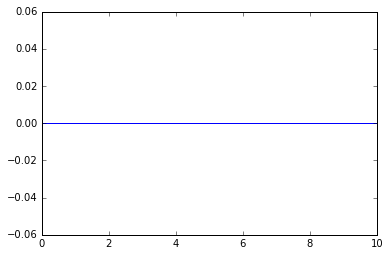

In [59]:
plt.errorbar(np.arange(11), tp, yerr = sd)

In [209]:
rel_vs_resp_all['DSI_nm']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
288   NaN
289   NaN
290   NaN
291   NaN
292   NaN
293   NaN
294   NaN
295   NaN
296   NaN
297   NaN
298   NaN
299   NaN
300   NaN
301   NaN
302   NaN
303   NaN
304   NaN
305   NaN
306   NaN
307   NaN
308   NaN
309   NaN
310   NaN
311   NaN
312   NaN
313   NaN
314   NaN
315   NaN
316   NaN
317   NaN
Name: DSI_nm, dtype: float64

In [196]:
for jj in range(numcells):
    rel_vs_resp_all['DSI_trials'].iloc[jj] = dsi_array[jj,:]
    rel_vs_resp_all['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
    rel_vs_resp_all['OSI_trials'].iloc[jj] = osi_array[jj,:]
    rel_vs_resp_all['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
    rel_vs_resp_all['TF_trials'].iloc[jj] = tf_array[jj,:]
    rel_vs_resp_all['TF_trials_std'].iloc[jj] = tf_std[jj,:]

In [200]:
rel_vs_resp_all['DSI_trials'].iloc[104]

array([0.85189521, 0.85189521, 0.85189521, 0.85189521, 0.85189521,
       0.85189521, 0.85189521, 0.85189521, 0.85189521, 0.85189521,
       0.85189521])

In [189]:
 for jj in range(numcells):
    rel_vs_resp_all['DSI_trials'].iloc[jj] = dsi_array[jj,:]
    rel_vs_resp_all['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
    rel_vs_resp_all['OSI_trials'].iloc[jj] = osi_array[jj,:]
    rel_vs_resp_all['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
    rel_vs_resp_all['TF_trials'].iloc[jj] = tf_array[jj,:]
    rel_vs_resp_all['TF_trials_std'].iloc[jj] = tf_std[jj,:]

KeyError: 'DSI_trials_std'

In [187]:
for jj in range(numcells):
        rel_vs_resp['DSI_trials'].iloc[jj] = dsi_array[jj,:]
        rel_vs_resp['DSI_trials_std'].iloc[jj] = dsi_std[jj,:]
        rel_vs_resp['OSI_trials'].iloc[jj] = osi_array[jj,:]
        rel_vs_resp['OSI_trials_std'].iloc[jj] = osi_std[jj,:]
        rel_vs_resp['TF_trials'].iloc[jj] = tf_array[jj,:]
        rel_vs_resp['TF_trials_std'].iloc[jj] = tf_std[jj,:]

NameError: name 'rel_vs_resp' is not defined

In [185]:
rel_vs_resp

NameError: name 'rel_vs_resp' is not defined

In [156]:
osi_array = np.empty((numcells, 11))
dsi_array = np.empty((numcells, 11))
tf_array = np.empty((numcells, 11))
osi_std = np.empty((numcells,11))
dsi_std = np.empty((numcells,11))
tf_std = np.empty((numcells,11))
for j,n_trials in enumerate(range(4,15)):
    DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
    OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
    TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
    response_array_first, response_array_second = cross_validate_response(50, numcells, n_trials)
    for ni in range(50):
        sort = np.where(response_array_first[:,:,:,ni]==np.max(response_array_first[:,:,:,ni], axis=(0,1)))
        sortind = np.argsort(sort[2])
        pref_ori = sort[0][sortind]
        pref_tf = sort[1][sortind]

        TF.loc[ni] = pref_tf

        #osi
        inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
        tuning = response_array_second[:, inds[1], inds[2],ni]
        tuning = np.where(tuning>0, tuning, 0)
        CV_top_os = np.empty((8, numcells), dtype=np.complex128)
        CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
        for i in range(8):
            CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
            CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

        OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



        #dsi
        null_ori= np.mod(pref_ori+4, 8)
        pref = response_array_second[inds[0], inds[1], inds[2], ni]
        null = response_array_second[null_ori, inds[1], inds[2], ni]
        null = np.where(null>0, null, 0)

        DSI.loc[ni] = (pref-null)/(pref+null)
    
    osi_array[:,j] = OSI.mean().values
    osi_std[:,j] = OSI.std().values
    dsi_array[:,j] = DSI.mean().values
    dsi_std[:,j] = DSI.std().values
    tf_array[:,j] = TF.mean().values
    tf_std[:,j] = TF.std().values

ValueError: Cannot take a larger sample than population when 'replace=False'

In [144]:
DSI

0         1          2          3         4         5          6  \
0   0.454337         1    0.64923   0.629267  0.926865  0.683121          1   
1   0.599493         1   0.187863   0.804763  0.889761  0.888113   0.888941   
2   0.348415         1   0.678944   0.555542  0.879677  0.944208     0.3654   
3          1         1   0.241988   0.515117  0.839362  0.920728   0.888213   
4   0.752281         1   0.744789  0.0181252  0.811623   0.91311   0.804605   
5   0.581637         1    0.50946   0.543638  0.849153  0.951496   0.852719   
6   0.277362         1   -0.16153   0.665566  0.950063   0.98802          1   
7   0.398876         1   0.653373   0.477428   0.80642  0.944032    0.70618   
8    0.80884         1   0.321798    0.47497  0.951662  0.955305   0.913533   
9   0.563594         1   0.023641   0.262243  0.700384  0.957804   0.805542   
10  0.520763         1   0.561751   0.272957  0.854745         1   0.576588   
11  0.856995         1   0.680409   0.404089   0.98025  0.986116    0.91393   
12  0.724283         1  0.0903632   0.488319  0.901048  0.754551   0.869511   
13  0.683842         1   0.553364   0.734322  0.877834  0.938009   0.917869   
14  0.561556         1   0.673924   0.669083  0.895191  0.986721   0.742924   
15  0.475454  0.646188   0.175495   0.383417  0.901936  0.956198   0.413981   
16   0.68291         1   0.690051   0.466932  0.903659   0.91569   0.740259   
17  0.577881         1   0.187863   0.664251  0.848373  0.938572   0.300316   
18  0.700114         1   0.601033   0.946344  0.869302  0.630622   0.696133   
19  0.192229         1         -1   0.410813         1  0.838944   0.771078   
20  0.823466         1         -1   0.458603  0.930733         1          1   
21  0.791264         1  -0.257348   0.525802  0.813892  0.712121   0.620075   
22  0.641329         1   0.539628   0.538707         1  0.990699   0.811045   
23   0.46376         1   0.638337   0.715832  0.763893  0.899387   0.719081   
24  0.623205         1  -0.188149    0.74865  0.788456  0.679695    0.75087   
25  0.584509         1   0.177901   0.696939  0.660386  0.961709   0.631315   
26  0.473918         1   0.618134   0.416909  0.893993   0.89929   0.905724   
27  0.642214         1  0.0328349   0.343216  0.857483  0.901917   0.831065   
28  0.608572         1  0.0860849   0.599139  0.826175         1   0.775689   
29  0.477499         1   0.626335   0.254496  0.860726  0.896416     0.4629   
30  0.651957         1  0.0324885   0.896327  0.889844  0.985913   0.736731   
31  0.813796         1         -1   0.828937  0.722608  0.905277   0.857002   
32  0.569061         1   0.466063    0.56128  0.970603  0.688512          1   
33  0.601248         1   0.682864   0.399949  0.956027   0.94118   0.697199   
34  0.686569         1  0.0462762   0.602384  0.882595  0.928299   0.103929   
35  0.680043         1   0.128277    0.70813  0.858055   0.53541          1   
36  0.696089         1   0.431209   0.646187  0.917012  0.957522   0.900243   
37  0.211091         1   0.356061   0.536236  0.811699  0.827866          1   
38  0.542735         1    0.40474   0.750622  0.639281  0.944645   0.824558   
39  0.531068         1   0.536696    0.33992  0.919627  0.507216   0.861472   
40  0.691328         1   0.344176   0.446076  0.853417  0.695954   0.514622   
41  0.858026         1  -0.384403   0.398208  0.945429  0.691607    0.67265   
42  0.689222         1  -0.783857    0.39427  0.928782  0.660686   0.576508   
43  0.800244         1    0.62898   0.586864  0.800914   0.98705  -0.241592   
44  0.668781         1   0.394052  0.0352417  0.615195  0.949851  0.0713932   
45  0.677978         1   0.686954   0.323323  0.891217  0.906115   0.884396   
46  0.449273         1  -0.264463   0.275226  0.859217  0.960037   0.441496   
47  0.506223         1  -0.409296   0.776051  0.790756   0.75423   0.585608   
48         1         1   0.540458   0.662142   0.85804         1   0.466315   
49  0.811577         1   0.519595   0.733734  0.803593  0.985

In [12]:
msr = dg.mean_sweep_response

ori_tc = pd.DataFrame(columns = [np.arange(dg.numbercells)], index = np.unique(dg.stim_table.orientation)[1:])

stim_table_sub = dg.stim_table
for ori in np.unique(dg.stim_table.orientation):
    print ori
    idx = stim_table_sub[stim_table_sub.orientation == ori].index
    
    #msr.loc[idx]
    
    ori_tc.loc[ori, :] = msr.loc[idx].mean(axis = 0).values[:dg.numbercells]
    
    
ori_tc.index.values[:-1]
np.abs(np.sum(ori_tc.loc[:,0]*np.exp(2*1j*np.radians([45,90,135,180,225,270,315,0]))))
    

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0


3.9150933898658122

In [13]:
dg.data_set.get_cell_specimen_indices([517516590])

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[0]

In [14]:
peak_tf = dg.peak.tf_dg[0]
tuning = np.zeros(np.unique(dg.stim_table.orientation).shape[0])
for ii, ori in enumerate(np.unique(dg.stim_table.orientation)):
    idx = stim_table[(stim_table.orientation == ori) & (stim_table.temporal_frequency == peak_tf)].index
    tuning[ii] = msr['0'].loc[idx].mean()
        
    
    
    
    

In [15]:
#compute OSI from bootstrapped response matrix ??

def get_osi_trials(tuning, orivals):
    orivals_rad = np.deg2rad(orivals)
    CV_top_os = np.empty((8), dtype=np.complex128)
    CV_top_ds = np.empty((8), dtype=np.complex128)
    for i in range(8):
        CV_top_os[i] = (tuning[i]*np.exp(1j*2*orivals_rad[i]))
        CV_top_ds[i] = (tuning[i]*np.exp(1j*orivals_rad[i]))
    osi = np.abs(CV_top_os.sum())/tuning.sum()
    return osi

In [16]:
get_osi_trials(tuning, np.unique(dg.stim_table.orientation))

1.5368507782092269

In [17]:
dg.peak.cv_os_dg

0       0.795295
1        0.76942
2        0.74035
3       0.819991
4              1
5       0.727046
6        0.74969
7       0.451653
8      0.0914285
9       0.484565
10      0.321774
11      0.504901
12      0.880515
13      0.429043
14      0.516351
15        0.5949
16      0.355059
17      0.210469
18      0.265353
19      0.171786
20      0.948876
21      0.825432
22        0.9665
23      0.806702
24      0.820289
25      0.849676
26      0.987163
27      0.993885
28      0.748829
29      0.660191
         ...    
288     0.734491
289    0.0390858
290     0.852777
291      0.14241
292     0.680655
293     0.655802
294     0.432268
295     0.428394
296     0.695694
297     0.269918
298     0.714722
299     0.957834
300     0.466348
301            1
302        0.406
303     0.132893
304            1
305     0.639215
306      0.42378
307            1
308     0.606122
309     0.162763
310     0.869829
311     0.996142
312     0.842334
313     0.226989
314     0.218357
315     0.7221

In [18]:
rel_vs_resp_all_mod[rel_vs_resp_all_mod.cell_specimen_id == 517516590]['gOSI']

NameError: name 'rel_vs_resp_all_mod' is not defined

In [ ]:
rel_vs_resp_all.shape

In [ ]:
data_set = boc.get_ophys_experiment_data(exp['id'])

In [22]:
n = 0
reliability_percentage_all = pd.DataFrame( 
                                      columns = ['reliability_percentage'])
for exp in cell_exp:
    print exp
    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    stim_table = dg.stim_table
    ncells = dg.numbercells
    reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
    rel_vs_resp_all['area'][n:n+ncells] = exp['targeted_structure']
    
    n+=ncells
    for cell in range(dg.numbercells): 
        pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[cell]]
        pref_ori = dg.orivals[dg.peak.ori_dg.iloc[cell]]
        resp_baseline = dg.sweep_response[str(cell)].apply(lambda x : x[:30])
        resp = dg.sweep_response[str(cell)].apply(lambda x : x[30:90])
        resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_mean  = resp_baseline.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_std = resp_baseline.apply(np.std)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        #resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        #rel_vs_resp['Roth'].iloc[cell] = np.sum((resp_mean > (resp_baseline_mean + resp_baseline_std*3)) & (resp_mean > 5))/np.float(resp_baseline_mean.shape[0])>0.5
        reliability_percentage['reliability_percentage'].iloc[cell]= np.sum(resp_mean > (resp_baseline_mean + resp_baseline_std*3))/np.float(resp_baseline_mean.shape[0])
        
    reliability_percentage_all = reliability_percentage_all.append(reliability_percentage)

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653123929, 'acquisition_age_days': 95, 'experiment_container_id': 652736297, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712919665, 'acquisition_age_days': 132, 'experiment_container_id': 708949511, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662359728, 'acquisition_age_days': 145, 'experiment_container_id': 657014785, 'targeted_structure': u'VISpm', 'fail_eye_tr

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 558670888, 'acquisition_age_days': 101, 'experiment_container_id': 556936291, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653122667, 'acquisition_age_days': 95, 'experiment_container_id': 653122665, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 699155265, 'acquisition_age_days': 97, 'experiment_container_id': 699155263, 'targeted_structure': u'VISl', 'fail_eye_tracking'

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'244898', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 529688779, 'acquisition_age_days': 122, 'experiment_container_id': 529487170, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570008444, 'acquisition_age_days': 136, 'experiment_container_id': 570008442, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 593552712, 'acquisition_age_days': 120, 'experiment_container_id': 592349242, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True

In [20]:
import copy

rvra = copy.deepcopy(rel_vs_resp_all)

In [98]:
rel_vs_resp_all['DSI_nm'] = 0 
rel_vs_resp_all['OSI_nm'] = 0 
rel_vs_resp_all['TF_nm'] = 0

In [131]:
n = 0

#rel_vs_resp_a
for exp in cell_exp:
    print exp
    
    try:
        print "see"
        data_set = boc.get_ophys_experiment_data(exp['id'])

        save_path = r"E:/"

        cells = data_set.get_cell_specimen_ids()
        stim_table = data_set.get_stimulus_table(stim_info.DRIFTING_GRATINGS)
        print "spot"
        data_file_dg = os.path.join(save_path,'DriftingGratings', str(exp['id']) + "_dg_events_analysis.h5")
        
        try:
            mean_sweep_events = pd.read_hdf(data_file_dg, 'mean_sweep_events')
            peak = pd.read_hdf(data_file_dg, 'peak')
            numcells = peak.shape[0]
            orivals = np.array(range(0,360,45))
            orivals_rad = np.deg2rad(orivals)
            tfvals = np.array([1,2,4,8,15])
            print "run"

            response_array_first, response_array_second = cross_validate_response(50, numcells, 14)

            #t0 = time.clock()
            DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
            OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
            TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))

            for ni in range(50):
                sort = np.where(response_array_first[:,:,:,ni]==np.max(response_array_first[:,:,:,ni], axis=(0,1)))
                sortind = np.argsort(sort[2])
                pref_ori = sort[0][sortind]
                pref_tf = sort[1][sortind]

                TF.loc[ni] = pref_tf

                #osi
                inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
                tuning = response_array_second[:, inds[1], inds[2],ni]
                tuning = np.where(tuning>0, tuning, 0)
                CV_top_os = np.empty((8, numcells), dtype=np.complex128)
                CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
                for i in range(8):
                    CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
                    CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

                OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



                #dsi
                null_ori= np.mod(pref_ori+4, 8)
                pref = response_array_second[inds[0], inds[1], inds[2], ni]
                null = response_array_second[null_ori, inds[1], inds[2], ni]
                null = np.where(null>0, null, 0)

                DSI.loc[ni] = (pref-null)/(pref+null)

           # print time.clock() - t0     

            new_metrics = pd.DataFrame(columns=('cell_specimen_id','osi','dsi','pref_tf'),index=range(numcells))
            new_metrics.cell_specimen_id = cells
            new_metrics.osi = OSI.mean().values
            new_metrics.dsi = DSI.mean().values
            new_metrics.pref_tf = TF.mean().values #this is the thing we need to figure out

            dg = DriftingGratings(data_set)
            stim_table = dg.stim_table

            #reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
            rel_vs_resp_all['DSI_nm'][n:n+numcells] = new_metrics['dsi']
            rel_vs_resp_all['OSI_nm'][n:n+numcells] = new_metrics['osi']
            rel_vs_resp_all['TF_nm'][n:n+numcells] = new_metrics['pref_tf']
            n+=numcells
        except:
            data_set = boc.get_ophys_experiment_data(exp['id'])
            "STOP"


            dg = DriftingGratings(data_set)
            stim_table = dg.stim_table
            numcells = dg.numbercells

            rel_vs_resp_all['DSI_nm'][n:n+numcells] = np.nan
            rel_vs_resp_all['OSI_nm'][n:n+numcells] = np.nan
            rel_vs_resp_all['TF_nm'][n:n+numcells] = np.nan
            n+= numcells

    except:
        continue

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 704298735, 'acquisition_age_days': 111, 'experiment_container_id': 701412138, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}
see
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'324178', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 605859367, 'acquisition_age_days': 110, 'experiment_container_id': 604576635, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-324178'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653123929, 'acquisition_age_days': 95, 'experiment_container_id': 652736297, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502793808, 'acquisition_age_days': 117, 'experiment_container_id': 511510640, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'282817', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 565216523, 'acquisition_age_days': 110, 'experiment_container_id': 565216521, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225039', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501940850, 'acquisition_age_days': 95, 'experiment_container_id': 511510688, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225039'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'228379', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506030579, 'acquisition_age_days': 90, 'experiment_container_id': 511510994, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'283278', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 571177441, 'acquisition_age_days': 145, 'experiment_container_id': 570994450, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283278'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712919665, 'acquisition_age_days': 132, 'experiment_container_id': 708949511, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355536', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653551965, 'acquisition_age_days': 99, 'experiment_container_id': 653551963, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355536'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662359728, 'acquisition_age_days': 145, 'experiment_container_id': 657014785, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355474', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653126877, 'acquisition_age_days': 95, 'experiment_container_id': 653126875, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355474'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503109347, 'acquisition_age_days': 101, 'experiment_container_id': 511510779, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365255', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663485329, 'acquisition_age_days': 102, 'experiment_container_id': 661732156, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365255'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 707006626, 'acquisition_age_days': 118, 'experiment_container_id': 701048110, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'243293', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 524691284, 'acquisition_age_days': 102, 'experiment_container_id': 524691282, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-243293'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'233215', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512326618, 'acquisition_age_days': 91, 'experiment_container_id': 511854338, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'369311', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 672207947, 'acquisition_age_days': 107, 'experiment_container_id': 672207945, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-369311'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501574836, 'acquisition_age_days': 103, 'experiment_container_id': 511510667, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229105', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506773892, 'acquisition_age_days': 87, 'experiment_container_id': 511510998, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229105'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355537', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657080632, 'acquisition_age_days': 123, 'experiment_container_id': 656939125, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'228379', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 505407318, 'acquisition_age_days': 86, 'experiment_container_id': 511510867, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'348262', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645413759, 'acquisition_age_days': 89, 'experiment_container_id': 645413757, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'268773', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 557304694, 'acquisition_age_days': 116, 'experiment_container_id': 556899621, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-268773'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'231584', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 510514474, 'acquisition_age_days': 88, 'experiment_container_id': 511510718, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231584'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'283278', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 571541565, 'acquisition_age_days': 149, 'experiment_container_id': 571541563, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283278'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 698260532, 'acquisition_age_days': 95, 'experiment_container_id': 698260530, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222424', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 504115289, 'acquisition_age_days': 124, 'experiment_container_id': 511510817, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570305847, 'acquisition_age_days': 140, 'experiment_container_id': 566759225, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'339323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 627823344, 'acquisition_age_days': 90, 'experiment_container_id': 638056632, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501704220, 'acquisition_age_days': 104, 'experiment_container_id': 511510736, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'282817', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 566307038, 'acquisition_age_days': 116, 'experiment_container_id': 566307034, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'333422', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 637154333, 'acquisition_age_days': 120, 'experiment_container_id': 614561352, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-333422'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 205, 'donor_name': u'377111', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai94(TITL-GCaMP6s)', 'id': 683257169, 'acquisition_age_days': 93, 'experiment_container_id': 682734790, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111'}
see
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225039', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502666254, 'acquisition_age_days': 96, 'experiment_container_id': 511510645, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225039'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229106', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507691036, 'acquisition_age_days': 90, 'experiment_container_id': 511510940, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502205092, 'acquisition_age_days': 94, 'experiment_container_id': 511510670, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'347748', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645256361, 'acquisition_age_days': 90, 'experiment_container_id': 644013840, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'354499', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 651770794, 'acquisition_age_days': 90, 'experiment_container_id': 650389951, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-354499'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'373869', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 679702884, 'acquisition_age_days': 104, 'experiment_container_id': 679702882, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-373869'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'389531', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 710502981, 'acquisition_age_days': 84, 'experiment_container_id': 710502979, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389531'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662351164, 'acquisition_age_days': 125, 'experiment_container_id': 662351162, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 658854537, 'acquisition_age_days': 110, 'experiment_container_id': 658854535, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'389015', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 710469199, 'acquisition_age_days': 88, 'experiment_container_id': 710469197, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389015'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356796', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 661328410, 'acquisition_age_days': 141, 'experiment_container_id': 659746623, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356796'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365251', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 661437140, 'acquisition_age_days': 95, 'experiment_container_id': 661437138, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662348804, 'acquisition_age_days': 142, 'experiment_container_id': 658854759, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501271265, 'acquisition_age_days': 100, 'experiment_container_id': 511509529, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 706566686, 'acquisition_age_days': 117, 'experiment_container_id': 702208910, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 702934964, 'acquisition_age_days': 105, 'experiment_container_id': 702934962, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'348262', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 647595665, 'acquisition_age_days': 98, 'experiment_container_id': 647595663, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501836392, 'acquisition_age_days': 108, 'experiment_container_id': 511510650, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 637669284, 'acquisition_age_days': 89, 'experiment_container_id': 627823721, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 205, 'donor_name': u'371307', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai94(TITL-GCaMP6s)', 'id': 688678766, 'acquisition_age_days': 138, 'experiment_container_id': 688678764, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-371307'}
see
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 558670888, 'acquisition_age_days': 101, 'experiment_container_id': 556936291, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653122667, 'acquisition_age_days': 95, 'experiment_container_id': 653122665, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652842572, 'acquisition_age_days': 90, 'experiment_container_id': 652842570, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 699155265, 'acquisition_age_days': 97, 'experiment_container_id': 699155263, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365255', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663876406, 'acquisition_age_days': 103, 'experiment_container_id': 662172425, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365255'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'390323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 716956096, 'acquisition_age_days': 98, 'experiment_container_id': 716655272, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 557225279, 'acquisition_age_days': 92, 'experiment_container_id': 555700037, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'354498', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653125130, 'acquisition_age_days': 99, 'experiment_container_id': 653125128, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-354498'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 639931541, 'acquisition_age_days': 102, 'experiment_container_id': 639253041, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'347751', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645700487, 'acquisition_age_days': 95, 'experiment_container_id': 644061873, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229106', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 510517131, 'acquisition_age_days': 103, 'experiment_container_id': 511510855, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'307419', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 591548033, 'acquisition_age_days': 110, 'experiment_container_id': 591548031, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-307419'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229109', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506823562, 'acquisition_age_days': 88, 'experiment_container_id': 511510848, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'233214', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512311673, 'acquisition_age_days': 91, 'experiment_container_id': 511976252, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233214'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503412730, 'acquisition_age_days': 122, 'experiment_container_id': 511510695, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 595229536, 'acquisition_age_days': 125, 'experiment_container_id': 593902385, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'384940', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 704822876, 'acquisition_age_days': 98, 'experiment_container_id': 702956471, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'231585', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 509958730, 'acquisition_age_days': 85, 'experiment_container_id': 511510870, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'361636', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662358771, 'acquisition_age_days': 119, 'experiment_container_id': 662358769, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663866413, 'acquisition_age_days': 130, 'experiment_container_id': 658534530, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'377111', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai94(TITL-GCaMP6s)', 'id': 680156911, 'acquisition_age_days': 85, 'experiment_container_id': 680156909, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111'}
see
spot


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355537', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657391037, 'acquisition_age_days': 127, 'experiment_container_id': 657391035, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229107', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506809539, 'acquisition_age_days': 87, 'experiment_container_id': 511510917, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'228378', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507464107, 'acquisition_age_days': 94, 'experiment_container_id': 511511052, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228378'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502199136, 'acquisition_age_days': 114, 'experiment_container_id': 511510664, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501876401, 'acquisition_age_days': 109, 'experiment_container_id': 511510715, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 569645690, 'acquisition_age_days': 130, 'experiment_container_id': 569645688, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'385254', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 701046700, 'acquisition_age_days': 87, 'experiment_container_id': 701046698, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-385254'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 660513003, 'acquisition_age_days': 117, 'experiment_container_id': 659767480, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'233215', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 510859641, 'acquisition_age_days': 82, 'experiment_container_id': 511511083, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503324629, 'acquisition_age_days': 102, 'experiment_container_id': 511510822, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'268773', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 552410386, 'acquisition_age_days': 89, 'experiment_container_id': 551657958, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-268773'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'231585', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512164988, 'acquisition_age_days': 99, 'experiment_container_id': 511856567, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365250', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 667364442, 'acquisition_age_days': 115, 'experiment_container_id': 666589599, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365250'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 276, 'donor_name': u'339323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 638056634, 'acquisition_age_days': 97, 'experiment_container_id': 698102441, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'390323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712178511, 'acquisition_age_days': 85, 'experiment_container_id': 712178509, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'372079', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 679700458, 'acquisition_age_days': 114, 'experiment_container_id': 679700455, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-372079'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'334309', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 613599811, 'acquisition_age_days': 91, 'experiment_container_id': 612555401, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-334309'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'282820', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 569739027, 'acquisition_age_days': 136, 'experiment_container_id': 569287964, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282820'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 639117826, 'acquisition_age_days': 96, 'experiment_container_id': 638753614, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'325932', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 612536911, 'acquisition_age_days': 132, 'experiment_container_id': 612536909, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-325932'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'361636', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 658536111, 'acquisition_age_days': 104, 'experiment_container_id': 658536109, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'347751', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 647155122, 'acquisition_age_days': 102, 'experiment_container_id': 647155120, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'354074', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652094917, 'acquisition_age_days': 94, 'experiment_container_id': 652094915, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-354074'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229107', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507990552, 'acquisition_age_days': 91, 'experiment_container_id': 511510945, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501933264, 'acquisition_age_days': 90, 'experiment_container_id': 511510797, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657914280, 'acquisition_age_days': 104, 'experiment_container_id': 657470854, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355468', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652737867, 'acquisition_age_days': 89, 'experiment_container_id': 651366508, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 651770186, 'acquisition_age_days': 86, 'experiment_container_id': 650885966, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 592657427, 'acquisition_age_days': 114, 'experiment_container_id': 591392164, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502376461, 'acquisition_age_days': 95, 'experiment_container_id': 511510753, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 660510593, 'acquisition_age_days': 117, 'experiment_container_id': 660510591, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229109', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 505845219, 'acquisition_age_days': 85, 'experiment_container_id': 511510836, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'384940', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 707923645, 'acquisition_age_days': 108, 'experiment_container_id': 707923643, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229470', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506773185, 'acquisition_age_days': 85, 'experiment_container_id': 511510893, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229470'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'244898', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 529688779, 'acquisition_age_days': 122, 'experiment_container_id': 529487170, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222424', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502115959, 'acquisition_age_days': 111, 'experiment_container_id': 511507650, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570008444, 'acquisition_age_days': 136, 'experiment_container_id': 570008442, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 593552712, 'acquisition_age_days': 120, 'experiment_container_id': 592349242, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'347748', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 644947716, 'acquisition_age_days': 87, 'experiment_container_id': 644947714, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355468', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652094901, 'acquisition_age_days': 87, 'experiment_container_id': 650389885, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502608215, 'acquisition_age_days': 96, 'experiment_container_id': 511510699, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}
see
spot
run


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

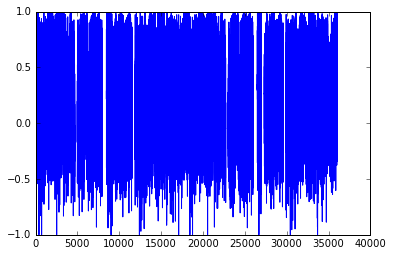

In [140]:
plt.plot(rel_vs_resp_all['DSI_nm'].values)

In [121]:
data_set = boc.get_ophys_experiment_data(exp['id'])

save_path = r"E:/"

cells = data_set.get_cell_specimen_ids()
stim_table = data_set.get_stimulus_table(stim_info.DRIFTING_GRATINGS)
data_file_dg = os.path.join(save_path,'DriftingGratings', str(exp['id']) + "_dg_events_analysis.h5")
mean_sweep_events = pd.read_hdf(data_file_dg, 'mean_sweep_events')
peak = pd.read_hdf(data_file_dg, 'peak')
numcells = peak.shape[0]
orivals = np.array(range(0,360,45))
orivals_rad = np.deg2rad(orivals)
tfvals = np.array([1,2,4,8,15])
response_array_first, response_array_second = cross_validate_response(50, numcells, 14)


#t0 = time.clock()
DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))

for ni in range(50):
    sort = np.where(response_array_first[:,:,:,ni]==np.max(response_array_first[:,:,:,ni], axis=(0,1)))
    sortind = np.argsort(sort[2])
    pref_ori = sort[0][sortind]
    pref_tf = sort[1][sortind]

    TF.loc[ni] = pref_tf

    #osi
    inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
    tuning = response_array_second[:, inds[1], inds[2],ni]
    tuning = np.where(tuning>0, tuning, 0)
    CV_top_os = np.empty((8, numcells), dtype=np.complex128)
    CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
    for i in range(8):
        CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
        CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

    OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



    #dsi
    null_ori= np.mod(pref_ori+4, 8)
    pref = response_array_second[inds[0], inds[1], inds[2], ni]
    null = response_array_second[null_ori, inds[1], inds[2], ni]
    null = np.where(null>0, null, 0)

    DSI.loc[ni] = (pref-null)/(pref+null)

# print time.clock() - t0     

new_metrics = pd.DataFrame(columns=('cell_specimen_id','osi','dsi','pref_tf'),index=range(numcells))
new_metrics.cell_specimen_id = cells
new_metrics.osi = OSI.mean().values
new_metrics.dsi = DSI.mean().values
new_metrics.pref_tf = TF.mean().values #this is the thing we need to figure out

dg = DriftingGratings(data_set)
stim_table = dg.stim_table

#reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
rel_vs_resp_all['DSI_nm'][n:n+numcells] = new_metrics['dsi']
rel_vs_resp_all['OSI_nm'][n:n+numcells] = new_metrics['osi']
rel_vs_resp_all['TF_nm'][n:n+numcells] = new_metrics['pref_tf']
n+=numcells

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

In [105]:
numcells

153

In [84]:
#t0 = time.clock()
response_array_first, response_array_second = cross_validate_response(50, numcells, 14)
#print time.clock() - t0


data_set = boc.get_ophys_experiment_data(exp['id'])

save_path = r"E:/"

cells = data_set.get_cell_specimen_ids()
stim_table = data_set.get_stimulus_table(stim_info.DRIFTING_GRATINGS)
data_file_dg = os.path.join(save_path,'DriftingGratings', str(exp['id']) + "_dg_events_analysis.h5")
mean_sweep_events = pd.read_hdf(data_file_dg, 'mean_sweep_events')
peak = pd.read_hdf(data_file_dg, 'peak')
numcells = peak.shape[0]
orivals = np.array(range(0,360,45))
orivals_rad = np.deg2rad(orivals)
tfvals = np.array([1,2,4,8,15])


#t0 = time.clock()
DSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
OSI = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))
TF = pd.DataFrame(columns=mean_sweep_events.columns, index=range(50))

for ni in range(50):
    sort = np.where(response_array_first[:,:,:,ni]==np.max(response_array_first[:,:,:,ni], axis=(0,1)))
    sortind = np.argsort(sort[2])
    pref_ori = sort[0][sortind]
    pref_tf = sort[1][sortind]

    TF.loc[ni] = pref_tf

    #osi
    inds = np.vstack((pref_ori, pref_tf, np.array(range(numcells))))
    tuning = response_array_second[:, inds[1], inds[2],ni]
    tuning = np.where(tuning>0, tuning, 0)
    CV_top_os = np.empty((8, numcells), dtype=np.complex128)
    CV_top_ds = np.empty((8, numcells), dtype=np.complex128)
    for i in range(8):
        CV_top_os[i] = (tuning[i,:]*np.exp(1j*2*orivals_rad[i]))
        CV_top_ds[i] = (tuning[i,:]*np.exp(1j*orivals_rad[i]))

    OSI.loc[ni] = np.abs(CV_top_os.sum(axis=0))/tuning.sum(axis=0)



    #dsi
    null_ori= np.mod(pref_ori+4, 8)
    pref = response_array_second[inds[0], inds[1], inds[2], ni]
    null = response_array_second[null_ori, inds[1], inds[2], ni]
    null = np.where(null>0, null, 0)

    DSI.loc[ni] = (pref-null)/(pref+null)


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

In [136]:
rel_vs_resp_all['cell_specimen_id']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
      ... 
288    NaN
289    NaN
290    NaN
291    NaN
292    NaN
293    NaN
294    NaN
295    NaN
296    NaN
297    NaN
298    NaN
299    NaN
300    NaN
301    NaN
302    NaN
303    NaN
304    NaN
305    NaN
306    NaN
307    NaN
308    NaN
309    NaN
310    NaN
311    NaN
312    NaN
313    NaN
314    NaN
315    NaN
316    NaN
317    NaN
Name: cell_specimen_id, dtype: object

In [76]:
pd.read_hdf(r"\\allen\programs\braintv\workgroups\cortexmodels\michaelbu\ObservatoryPlatformPaperAnalysis\event_analysis_files_2018_09_25\DriftingGratings\501729039_dg_events_analysis.h5")

HDF5ExtError: HDF5 error back trace

  File "F:\ci\hdf5_1545322814636\work\src\H5F.c", line 509, in H5Fopen
    unable to open file
  File "F:\ci\hdf5_1545322814636\work\src\H5Fint.c", line 1400, in H5F__open
    unable to open file
  File "F:\ci\hdf5_1545322814636\work\src\H5Fint.c", line 1546, in H5F_open
    unable to open file: time = Mon Aug 03 19:15:42 2020
, name = '\\allen\programs\braintv\workgroups\cortexmodels\michaelbu\ObservatoryPlatformPaperAnalysis\event_analysis_files_2018_09_25\DriftingGratings\501729039_dg_events_analysis.h5', tent_flags = 1
  File "F:\ci\hdf5_1545322814636\work\src\H5FD.c", line 734, in H5FD_open
    open failed
  File "F:\ci\hdf5_1545322814636\work\src\H5FDsec2.c", line 346, in H5FD_sec2_open
    unable to open file: name = '\\allen\programs\braintv\workgroups\cortexmodels\michaelbu\ObservatoryPlatformPaperAnalysis\event_analysis_files_2018_09_25\DriftingGratings\501729039_dg_events_analysis.h5', errno = 13, error message = 'Permission denied', flags = 1, o_flags = 2

End of HDF5 error back trace

Unable to open/create file '\\allen\programs\braintv\workgroups\cortexmodels\michaelbu\ObservatoryPlatformPaperAnalysis\event_analysis_files_2018_09_25\DriftingGratings\501729039_dg_events_analysis.h5'

In [27]:
n = 0
specimen_ids = pd.Series(index = rel_vs_resp_all)
for exp in cell_exp:
    print exp
    #cell_specimen_df = pd.DataFrame(columns = ['cell_specimen_id'])
    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    ncells = dg.numbercells
    #reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
    specimen_ids.loc[n:n+ncells] = exp['id']
    
    n+=ncells

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653123929, 'acquisition_age_days': 95, 'experiment_container_id': 652736297, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712919665, 'acquisition_age_days': 132, 'experiment_container_id': 708949511, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662359728, 'acquisition_age_days': 145, 'experiment_container_id': 657014785, 'targeted_structure': u'VISpm', 'fail_eye_tr

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 558670888, 'acquisition_age_days': 101, 'experiment_container_id': 556936291, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653122667, 'acquisition_age_days': 95, 'experiment_container_id': 653122665, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 699155265, 'acquisition_age_days': 97, 'experiment_container_id': 699155263, 'targeted_structure': u'VISl', 'fail_eye_tracking'

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'244898', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 529688779, 'acquisition_age_days': 122, 'experiment_container_id': 529487170, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570008444, 'acquisition_age_days': 136, 'experiment_container_id': 570008442, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 593552712, 'acquisition_age_days': 120, 'experiment_container_id': 592349242, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True

In [28]:
rel_vs_resp_all['id'] = specimen_ids.values

In [173]:
dg.cell_id

C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


array([662075329, 662075663, 662075593, 662074866, 662074842, 662075609,
       662075639, 662074250, 662075765, 662074324, 662074335, 662074370,
       662074347, 662075539, 662074297, 662074625, 662074541, 662075932,
       662075071, 662075570, 662074598, 662074651, 662075496, 662076043,
       662075977, 662075124, 662075454, 662075988, 662074286, 662074930,
       662075414, 662076005, 662075678, 662075917, 662075549, 662074677,
       662075477, 662075995, 662075954, 662075263, 662075624], dtype=int64)

In [141]:
n = 0
for exp in cell_exp:
    try:
        print exp
        #cell_specimen_df = pd.DataFrame(columns = ['cell_specimen_id'])
        data_set = boc.get_ophys_experiment_data(exp['id'])
        dg = DriftingGratings(data_set)
        ncells = dg.numbercells
        #reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
        rel_vs_resp_all['cell_specimen_id'][n:n+ncells] = dg.cell_id

        n+=ncells
    except:
        continue

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 704298735, 'acquisition_age_days': 111, 'experiment_container_id': 701412138, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'324178', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 605859367, 'acquisition_age_days': 110, 'experiment_container_id': 604576635, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-324178'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653123929, 'acquisition_age_days': 95, 'experiment_container_id': 652736297, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502793808, 'acquisition_age_days': 117, 'experiment_container_id': 511510640, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'282817', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 565216523, 'acquisition_age_days': 110, 'experiment_container_id': 565216521, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225039', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501940850, 'acquisition_age_days': 95, 'experiment_container_id': 511510688, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225039'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'228379', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506030579, 'acquisition_age_days': 90, 'experiment_container_id': 511510994, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'283278', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 571177441, 'acquisition_age_days': 145, 'experiment_container_id': 570994450, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283278'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712919665, 'acquisition_age_days': 132, 'experiment_container_id': 708949511, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355536', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653551965, 'acquisition_age_days': 99, 'experiment_container_id': 653551963, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355536'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662359728, 'acquisition_age_days': 145, 'experiment_container_id': 657014785, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355474', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653126877, 'acquisition_age_days': 95, 'experiment_container_id': 653126875, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355474'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503109347, 'acquisition_age_days': 101, 'experiment_container_id': 511510779, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365255', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663485329, 'acquisition_age_days': 102, 'experiment_container_id': 661732156, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365255'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 707006626, 'acquisition_age_days': 118, 'experiment_container_id': 701048110, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'243293', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 524691284, 'acquisition_age_days': 102, 'experiment_container_id': 524691282, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-243293'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'233215', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512326618, 'acquisition_age_days': 91, 'experiment_container_id': 511854338, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'369311', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 672207947, 'acquisition_age_days': 107, 'experiment_container_id': 672207945, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-369311'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501574836, 'acquisition_age_days': 103, 'experiment_container_id': 511510667, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229105', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506773892, 'acquisition_age_days': 87, 'experiment_container_id': 511510998, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229105'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355537', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657080632, 'acquisition_age_days': 123, 'experiment_container_id': 656939125, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'228379', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 505407318, 'acquisition_age_days': 86, 'experiment_container_id': 511510867, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'348262', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645413759, 'acquisition_age_days': 89, 'experiment_container_id': 645413757, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'268773', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 557304694, 'acquisition_age_days': 116, 'experiment_container_id': 556899621, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-268773'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'231584', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 510514474, 'acquisition_age_days': 88, 'experiment_container_id': 511510718, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231584'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'283278', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 571541565, 'acquisition_age_days': 149, 'experiment_container_id': 571541563, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283278'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 698260532, 'acquisition_age_days': 95, 'experiment_container_id': 698260530, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222424', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 504115289, 'acquisition_age_days': 124, 'experiment_container_id': 511510817, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570305847, 'acquisition_age_days': 140, 'experiment_container_id': 566759225, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'339323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 627823344, 'acquisition_age_days': 90, 'experiment_container_id': 638056632, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501704220, 'acquisition_age_days': 104, 'experiment_container_id': 511510736, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'282817', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 566307038, 'acquisition_age_days': 116, 'experiment_container_id': 566307034, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'333422', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 637154333, 'acquisition_age_days': 120, 'experiment_container_id': 614561352, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-333422'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 205, 'donor_name': u'377111', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai94(TITL-GCaMP6s)', 'id': 683257169, 'acquisition_age_days': 93, 'experiment_container_id': 682734790, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225039', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502666254, 'acquisition_age_days': 96, 'experiment_container_id': 511510645, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225039'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229106', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507691036, 'acquisition_age_days': 90, 'experiment_container_id': 511510940, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502205092, 'acquisition_age_days': 94, 'experiment_container_id': 511510670, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'347748', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645256361, 'acquisition_age_days': 90, 'experiment_container_id': 644013840, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'354499', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 651770794, 'acquisition_age_days': 90, 'experiment_container_id': 650389951, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-354499'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'373869', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 679702884, 'acquisition_age_days': 104, 'experiment_container_id': 679702882, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-373869'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'389531', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 710502981, 'acquisition_age_days': 84, 'experiment_container_id': 710502979, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389531'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662351164, 'acquisition_age_days': 125, 'experiment_container_id': 662351162, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 658854537, 'acquisition_age_days': 110, 'experiment_container_id': 658854535, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'389015', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 710469199, 'acquisition_age_days': 88, 'experiment_container_id': 710469197, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389015'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356796', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 661328410, 'acquisition_age_days': 141, 'experiment_container_id': 659746623, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356796'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365251', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 661437140, 'acquisition_age_days': 95, 'experiment_container_id': 661437138, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662348804, 'acquisition_age_days': 142, 'experiment_container_id': 658854759, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501271265, 'acquisition_age_days': 100, 'experiment_container_id': 511509529, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 706566686, 'acquisition_age_days': 117, 'experiment_container_id': 702208910, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 702934964, 'acquisition_age_days': 105, 'experiment_container_id': 702934962, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'348262', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 647595665, 'acquisition_age_days': 98, 'experiment_container_id': 647595663, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501836392, 'acquisition_age_days': 108, 'experiment_container_id': 511510650, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 637669284, 'acquisition_age_days': 89, 'experiment_container_id': 627823721, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 205, 'donor_name': u'371307', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai94(TITL-GCaMP6s)', 'id': 688678766, 'acquisition_age_days': 138, 'experiment_container_id': 688678764, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-371307'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 558670888, 'acquisition_age_days': 101, 'experiment_container_id': 556936291, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653122667, 'acquisition_age_days': 95, 'experiment_container_id': 653122665, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652842572, 'acquisition_age_days': 90, 'experiment_container_id': 652842570, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 699155265, 'acquisition_age_days': 97, 'experiment_container_id': 699155263, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365255', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663876406, 'acquisition_age_days': 103, 'experiment_container_id': 662172425, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365255'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'390323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 716956096, 'acquisition_age_days': 98, 'experiment_container_id': 716655272, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 557225279, 'acquisition_age_days': 92, 'experiment_container_id': 555700037, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'354498', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653125130, 'acquisition_age_days': 99, 'experiment_container_id': 653125128, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-354498'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 639931541, 'acquisition_age_days': 102, 'experiment_container_id': 639253041, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'347751', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645700487, 'acquisition_age_days': 95, 'experiment_container_id': 644061873, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229106', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 510517131, 'acquisition_age_days': 103, 'experiment_container_id': 511510855, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'307419', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 591548033, 'acquisition_age_days': 110, 'experiment_container_id': 591548031, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-307419'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229109', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506823562, 'acquisition_age_days': 88, 'experiment_container_id': 511510848, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'233214', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512311673, 'acquisition_age_days': 91, 'experiment_container_id': 511976252, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233214'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503412730, 'acquisition_age_days': 122, 'experiment_container_id': 511510695, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 595229536, 'acquisition_age_days': 125, 'experiment_container_id': 593902385, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'384940', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 704822876, 'acquisition_age_days': 98, 'experiment_container_id': 702956471, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'231585', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 509958730, 'acquisition_age_days': 85, 'experiment_container_id': 511510870, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'361636', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662358771, 'acquisition_age_days': 119, 'experiment_container_id': 662358769, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663866413, 'acquisition_age_days': 130, 'experiment_container_id': 658534530, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'377111', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai94(TITL-GCaMP6s)', 'id': 680156911, 'acquisition_age_days': 85, 'experiment_container_id': 680156909, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355537', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657391037, 'acquisition_age_days': 127, 'experiment_container_id': 657391035, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229107', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506809539, 'acquisition_age_days': 87, 'experiment_container_id': 511510917, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'228378', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507464107, 'acquisition_age_days': 94, 'experiment_container_id': 511511052, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228378'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502199136, 'acquisition_age_days': 114, 'experiment_container_id': 511510664, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501876401, 'acquisition_age_days': 109, 'experiment_container_id': 511510715, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 569645690, 'acquisition_age_days': 130, 'experiment_container_id': 569645688, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'385254', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 701046700, 'acquisition_age_days': 87, 'experiment_container_id': 701046698, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-385254'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 660513003, 'acquisition_age_days': 117, 'experiment_container_id': 659767480, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'233215', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 510859641, 'acquisition_age_days': 82, 'experiment_container_id': 511511083, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503324629, 'acquisition_age_days': 102, 'experiment_container_id': 511510822, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'268773', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 552410386, 'acquisition_age_days': 89, 'experiment_container_id': 551657958, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-268773'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'231585', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512164988, 'acquisition_age_days': 99, 'experiment_container_id': 511856567, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'365250', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 667364442, 'acquisition_age_days': 115, 'experiment_container_id': 666589599, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365250'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 276, 'donor_name': u'339323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 638056634, 'acquisition_age_days': 97, 'experiment_container_id': 698102441, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'390323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712178511, 'acquisition_age_days': 85, 'experiment_container_id': 712178509, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'372079', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 679700458, 'acquisition_age_days': 114, 'experiment_container_id': 679700455, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-372079'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'334309', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 613599811, 'acquisition_age_days': 91, 'experiment_container_id': 612555401, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-334309'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'282820', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 569739027, 'acquisition_age_days': 136, 'experiment_container_id': 569287964, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282820'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 639117826, 'acquisition_age_days': 96, 'experiment_container_id': 638753614, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'325932', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 612536911, 'acquisition_age_days': 132, 'experiment_container_id': 612536909, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-325932'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'361636', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 658536111, 'acquisition_age_days': 104, 'experiment_container_id': 658536109, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'347751', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 647155122, 'acquisition_age_days': 102, 'experiment_container_id': 647155120, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'354074', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652094917, 'acquisition_age_days': 94, 'experiment_container_id': 652094915, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-354074'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229107', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507990552, 'acquisition_age_days': 91, 'experiment_container_id': 511510945, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501933264, 'acquisition_age_days': 90, 'experiment_container_id': 511510797, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657914280, 'acquisition_age_days': 104, 'experiment_container_id': 657470854, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355468', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652737867, 'acquisition_age_days': 89, 'experiment_container_id': 651366508, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 651770186, 'acquisition_age_days': 86, 'experiment_container_id': 650885966, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 592657427, 'acquisition_age_days': 114, 'experiment_container_id': 591392164, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502376461, 'acquisition_age_days': 95, 'experiment_container_id': 511510753, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 660510593, 'acquisition_age_days': 117, 'experiment_container_id': 660510591, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229109', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 505845219, 'acquisition_age_days': 85, 'experiment_container_id': 511510836, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'384940', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 707923645, 'acquisition_age_days': 108, 'experiment_container_id': 707923643, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'229470', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506773185, 'acquisition_age_days': 85, 'experiment_container_id': 511510893, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229470'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'244898', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 529688779, 'acquisition_age_days': 122, 'experiment_container_id': 529487170, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222424', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502115959, 'acquisition_age_days': 111, 'experiment_container_id': 511507650, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570008444, 'acquisition_age_days': 136, 'experiment_container_id': 570008442, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 593552712, 'acquisition_age_days': 120, 'experiment_container_id': 592349242, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'347748', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 644947716, 'acquisition_age_days': 87, 'experiment_container_id': 644947714, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'355468', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652094901, 'acquisition_age_days': 87, 'experiment_container_id': 650389885, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502608215, 'acquisition_age_days': 96, 'experiment_container_id': 511510699, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

In [478]:
rel_vs_resp_all.shape

(18031, 65)

In [479]:
rel_vs_resp_all.to_csv('ReliabilityVsResponsivenessDataAll_newDataAll_crossvalidated_complete.csv')

In [3]:
rel_vs_resp_all = pd.DataFrame.from_csv('ReliabilityVsResponsivenessDataAll_newDataAll.csv')

In [35]:
rel_vs_resp_all_mod = pd.DataFrame.from_csv("ReliabilityVsResponsivenessDataAll_191031.csv")

In [5]:
rel_vs_resp_all['reliability_percentage'] = rel_vs_resp_all_mod['reliability_percentage']

In [242]:
rel_vs_resp_all.to_csv('ReliabilityVsResponsivenessData-forSaskia.csv')

In [40]:
rel_vs_resp_all_mod[rel_vs_resp_all_mod.cell_specimen_id == 662271808.0]['gOSI']

0    0.146196
Name: gOSI, dtype: float64

In [41]:
rel_vs_resp_all_mod[rel_vs_resp_all_mod.cell_specimen_id == 662271808.0]['OSI']

0    0.293347
Name: OSI, dtype: float64

In [47]:
rel_vs_resp_all[rel_vs_resp_all.cell_specimen_id == 662271808]['OSI']

0    0.293347
Name: OSI, dtype: object

In [50]:
#compute OSI from bootstrapped response matrix ??

def get_osi_trials(response_events_sample, pref_tf):
    orivals_rad = np.deg2rad(orivals)
    tuning = response_events_sample[:, pref_tf, :]
    tuning = np.where(tuning>0, tuning, 0)
    CV_top_os = np.empty((8), dtype=np.complex128)
    CV_top_ds = np.empty((8), dtype=np.complex128)
    for i in range(8):
        CV_top_os[i] = (tuning[i]*np.exp(1j*2*orivals_rad[i]))
        CV_top_ds[i] = (tuning[i]*np.exp(1j*orivals_rad[i]))
    osi = np.abs(CV_top_os.sum())/tuning.sum()
    return osi

In [52]:
mean_sweep_response = dg.mean_sweep_response

In [55]:
mean_sweep_response[str(0)]

0     -4.131280
1     -2.142724
2      2.917132
3      0.473224
4      1.717535
5      1.099228
6      0.235731
7      2.750747
8     -1.091780
9      3.823801
10    -0.374546
11    -0.272736
12     1.945741
13    -0.580697
14     0.824019
15     2.717215
16     0.657005
17     0.029216
18    -0.109775
19    -0.464515
20    -0.764847
21     2.042711
22    -4.530952
23    -1.664080
24     2.680035
25     2.792356
26     0.829510
27    -5.962493
28    -1.796874
29    -2.431199
         ...   
598    1.616055
599   -0.468214
600    0.305270
601    0.044455
602   -4.413175
603    1.010800
604    3.297057
605    0.093723
606   -0.625852
607    0.693598
608    0.593478
609   -1.534470
610   -1.086290
611    0.251665
612    0.568558
613    2.444559
614    3.362720
615   -2.146458
616    0.974126
617    0.951626
618    0.569275
619    0.436912
620   -0.359394
621   -5.165121
622    7.120702
623   -3.070477
624   -0.346879
625   -1.961670
626    5.869474
627   -0.420926
Name: 0, dtype: float64

In [47]:
np.sum(rel_vs_resp_all['Andermann']== True)

2909

In [30]:
rel_vs_resp_all_load = pd.DataFrame.from_csv('ReliabilityVsResponsivenessDataAll_190823.csv')

In [43]:
rel_vs_resp_all_load['Marshel'] = rel_vs_resp_all['Marshel']
rel_vs_resp_all_load['Roth'] = rel_vs_resp_all['Roth']

In [44]:
rel_vs_resp_all_load.to_csv('ReliabilityVsResponsivenessDataAll_190827.csv')

In [40]:
np.sum(rel_vs_resp_all['Roth'] == True)

601

In [41]:
np.sum(rel_vs_resp_all_load['Roth'] == True)

601

In [ ]:
rel_vs_resp_all_load['Marshel'] = rel_vs_resp_all['Marshel']

In [4]:
# plot number of cells for each 
colors = ['r', 'b', 'g','m', 'c']
criteria = ['Tohmi', 'Andermann','Sun', 'Roth', 'Marshel']
features =  [ 'reliability',
              'reliability_marshel',
              'reliability_corr',
              'DSI',
              'OSI',
              'TF',
              'pref_ori',
              'peak dF/F']
def plot_feature(rel_vs_resp_all, feature, criteria, ax = None): 
    df = pd.DataFrame(index = [0,1], columns = criteria)
    for crit in criteria: 
        if feature== 'TF':
            vals = rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature]
            vals[vals == 3] = 4
            vals[vals == 4] = 8
            vals[vals == 5] = 15
            df[crit].loc[0] = vals.mean()
            df[crit].loc[1] = vals.std()
        else:
            df[crit].loc[0] = rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature].mean()
            df[crit].loc[1] =rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature].std()
        
            
    df.T[0].plot(kind = 'bar', colors = colors, legend = False, ax= ax)
    ax.set_title(feature)

    

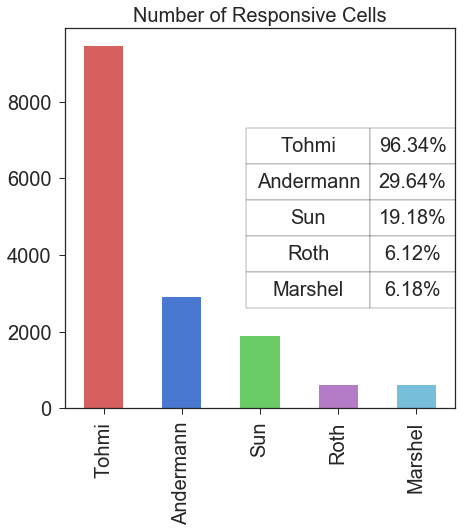

In [5]:

fig1, ax= plt.subplots(1,1, figsize = (7,7))
df = pd.DataFrame(index = [0], columns = criteria)
total_cells = np.float(rel_vs_resp_all.shape[0])
for crit in criteria:
    df[crit] = rel_vs_resp_all[rel_vs_resp_all[crit]==True].shape[0]


df.T.plot(kind = 'bar', colors = colors, legend = False, ax= ax, fontsize = 20)
ax.set_title('Number of Responsive Cells', fontsize = 20)

ax2 = fig1.add_subplot(144, frame_on=False) 
#ax2.set_title('Percent responsive cells', loc = 'left', fontsize = 34)
cellText = np.round(df.T.values/np.float16(rel_vs_resp_all.shape[0])*100, 2) 
cellText = [str(text[0]) + "%" for text in cellText]
cellText = [[text] for text in cellText]
ax2.xaxis.set_visible(False) 
ax2.yaxis.set_visible(False)

the_table = plt.table(cellText = cellText , rowLabels=df.columns,      
    cellLoc = 'center', rowLoc = 'center', loc = 'center')

the_table.set_fontsize(34)
the_table.scale(1, 3)
#fig1.savefig('Number_of_responsive_cells_by_criteria.jpg')

In [6]:
colors = {}
colors['Rbp4-Cre_KL100'] = '#5cad53'
colors['Cux2-CreERT2'] = '#a92e66'
colors['Rorb-IRES2-Cre'] = '#7841be'
colors['Scnn1a-Tg3-Cre'] = '#4f63c2'
colors['Nr5a1-Cre'] = '#5bb0b0'
colors['Emx1-IRES-Cre'] = '#9f9f9f'
areas = ['VISp','VISl','VISal','VISpm','VISam','VISrl']
depths = [100,200,300]
cres = ['Rbp4-Cre_KL100', 'Cux2-CreERT2', 'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre', 'Emx1-IRES-Cre', 'Nr5a1-Cre']
markers = {}
markers[100] = 's--'
markers[200] = 'o--'
markers[300] = 'v--'
sns.set(font_scale=2) 

In [7]:
# plot number of cells for each 
colors = ['r', 'b', 'g','m', 'c']
criteria = [ 'Tohmi', 'Andermann', 'Sun','Roth','Marshel']
features =  ['cell_specimen_id',
              'area',
              'reliability',
              'reliability_marshel',
              'reliability_corr',
              'DSI',
              'OSI',
              'TF',
              'pref_ori',
              'peak dF/F']
def plot_feature(rel_vs_resp_all, feature, criteria): 
    df = pd.DataFrame(index = [0], columns = criteria)
    for crit in criteria: 
        df[crit] = rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature].mean()
    df.T.plot(kind = 'bar', colors = colors, legend = False)
    plt.title(feature)

    

In [8]:
rel_vs_resp_all.head()

Andermann       DSI Marshel       OSI   Roth    Sun  TF Tohmi  area  \
0     False  0.106526   False  0.293347  False  False   1  True  VISl   
1      True  0.290941   False  0.834281  False  False   1  True  VISl   
2      True  0.886365    True  0.769854   True   True   3  True  VISl   
3      True  1.590879   False  0.983274  False   True   1  True  VISl   
4     False  0.581605   False  0.432422  False  False   3  True  VISl   

   cell_specimen_id   p_blank  peak dF/F  pref_ori  reliability  \
0       662271808.0  0.000021   4.222313         0     0.098291   
1       662274945.0  0.000021   9.171899         2     0.057520   
2       662270417.0  0.000021  19.073977         2     0.227912   
3       662274558.0  0.000021  14.022856         1     0.150050   
4       662271782.0  0.000021   2.423842         2     0.046560   

   reliability_corr  reliability_marshel  reliability_percentage  
0          0.138206             0.429049                     0.0  
1          0.156270             0.593175                     0.0  
2          0.338279             1.310567                     0.0  
3          0.196020             0.630753                     0.0  
4          0.045541             0.397080                     0.0

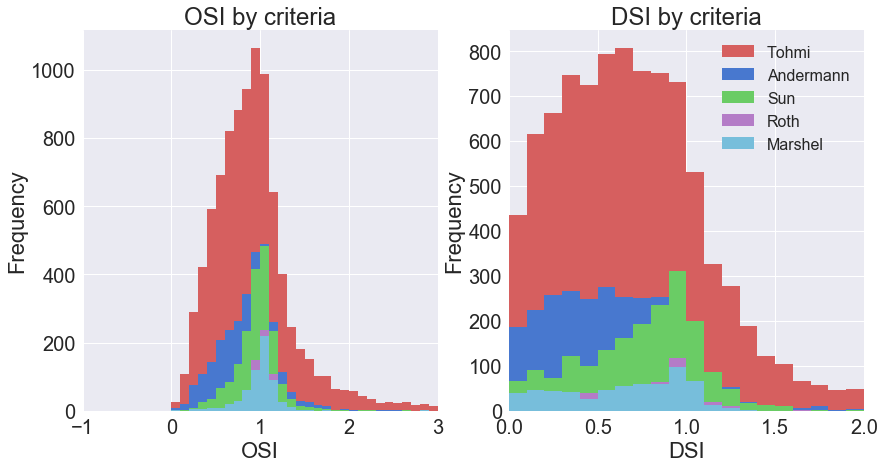

In [9]:
fig3,axs =plt.subplots(1,2, figsize = (14,7))

ax0 = axs[0]
ax1 = axs[1]

#for ii, axis in enumerate(ax.reshape(-1)[:5]):
for ii, crit in enumerate(criteria):
    rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True]['OSI'].plot(kind = 'hist', ax = ax0,color = colors[ii],bins = np.arange(0,10,0.1))
    rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True]['DSI'].plot(kind = 'hist', color = colors[ii],ax = ax1, bins = np.arange(0,10,0.1))
    #rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True]['TF'].plot(kind = 'hist', color = colors[ii],ax = ax1, bins = np.arange(0,10,0.1))
    #ax0.set_title(criteria[ii])
    ax0.set_xlabel('OSI')
    ax1.set_xlabel('DSI')
    ax2.set_xlabel('TF')
    ax0.set_xlim(-1,3)
    ax1.set_xlim(0, 2)
    
ax0.set_title('OSI by criteria')
ax1.set_title('DSI by criteria')
plt.legend(criteria, fontsize = 16)

#fig3.savefig('OSI_and_DSI_by_criteria.jpg')

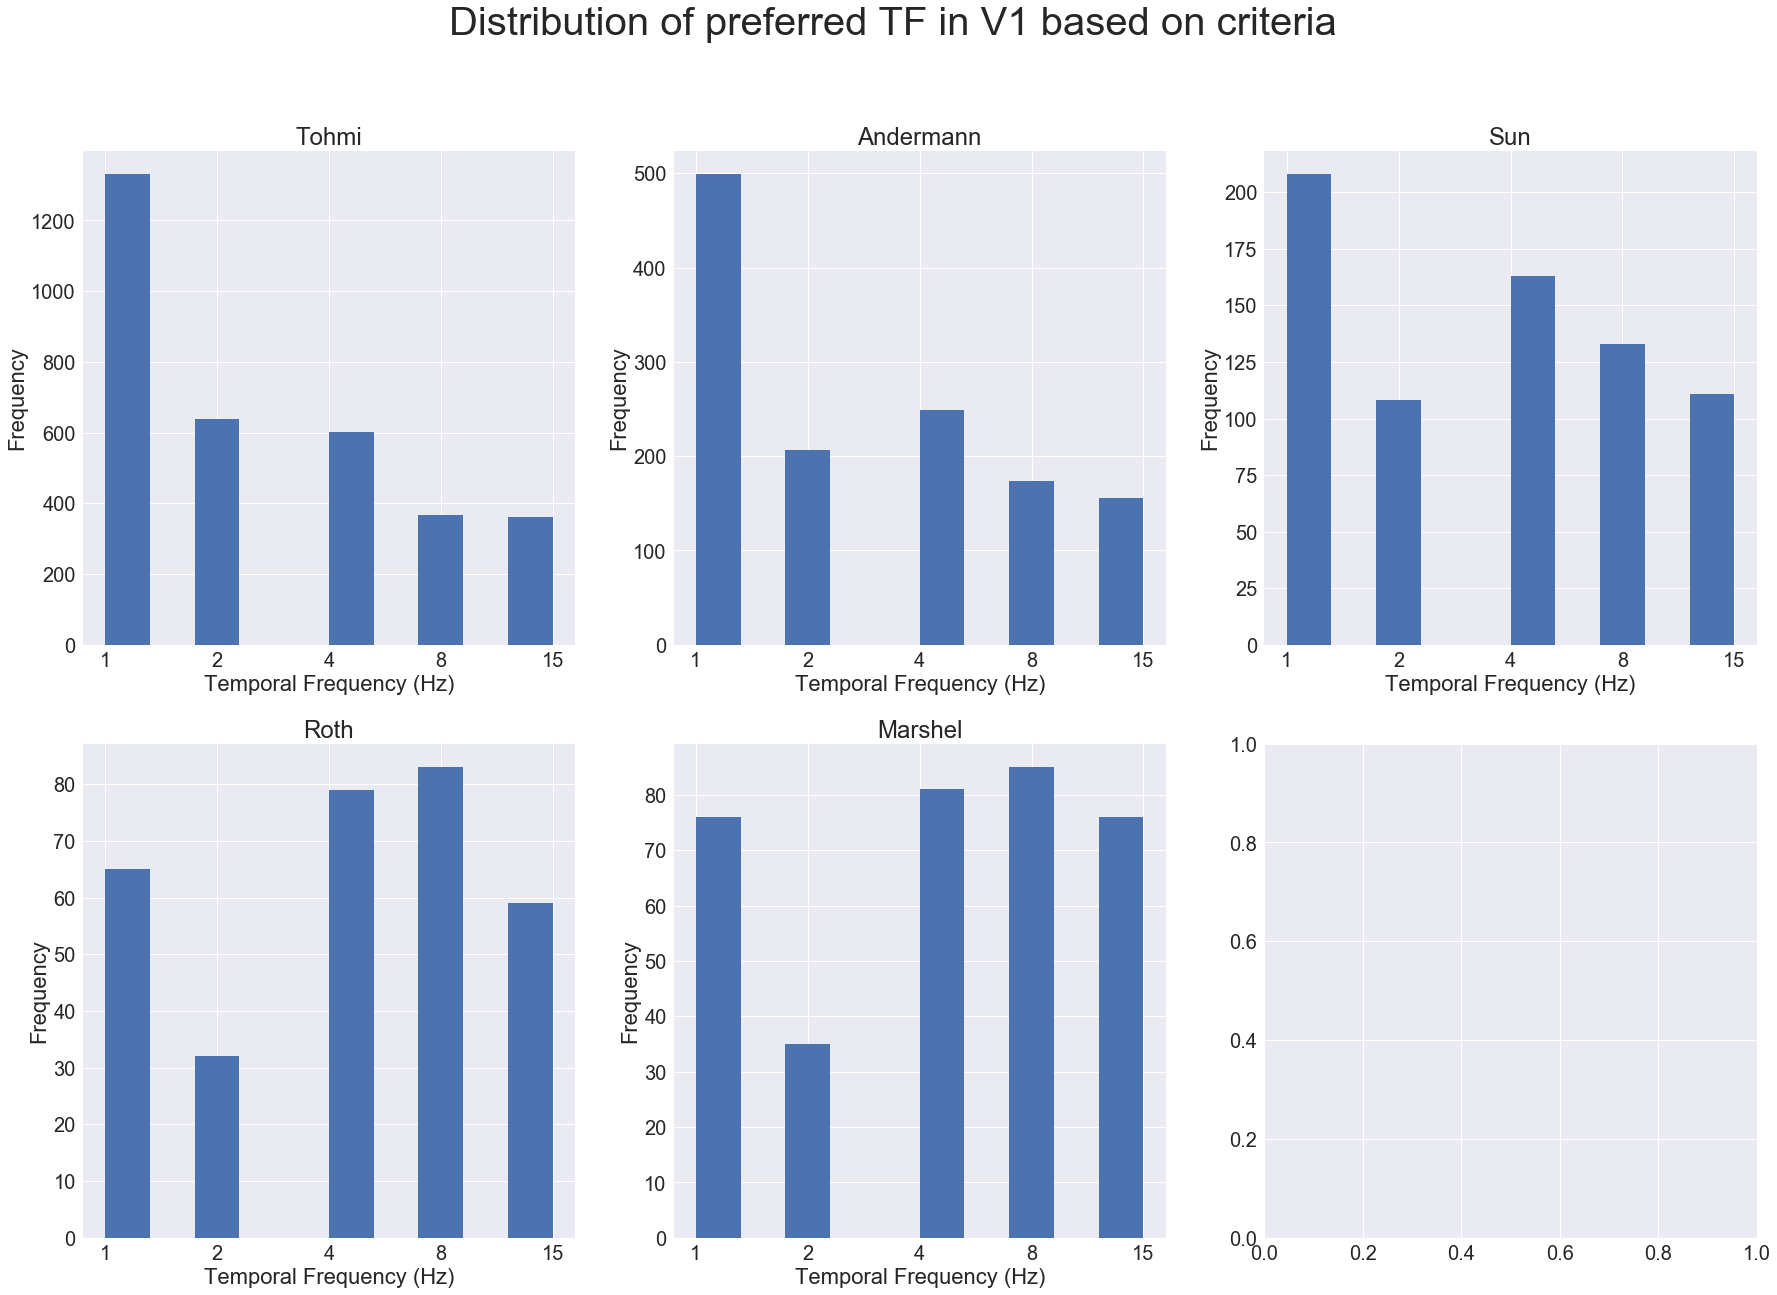

In [10]:
fig5,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in V1 based on criteria', fontsize = 40)
for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISp")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')
    
#fig5.savefig('Distribution_of_prefTF_by_criteria_V1.jpg')

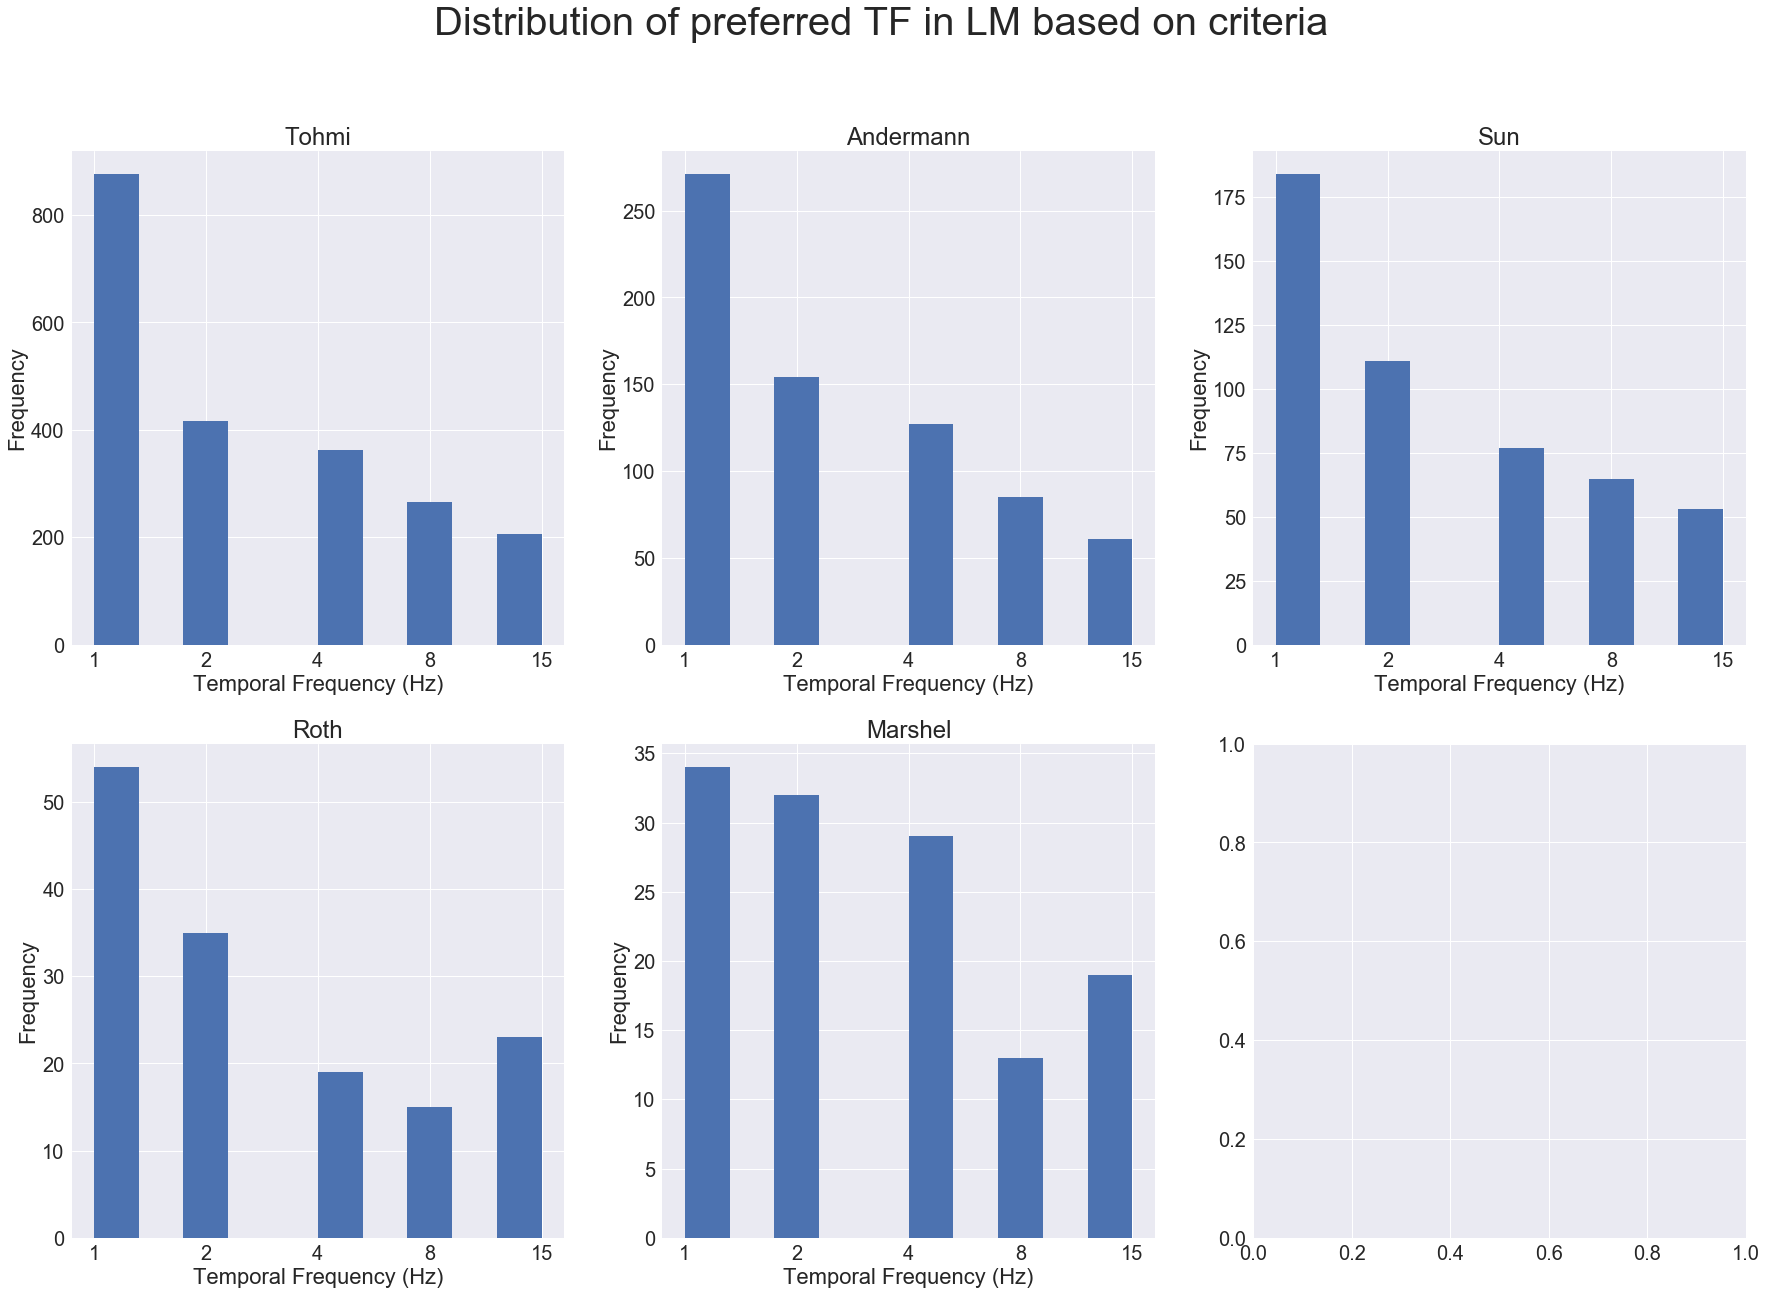

In [11]:
fig6,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in LM based on criteria', fontsize = 40)
for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISl")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')
    
    
#fig5.savefig('Distribution_of_prefTF_by_criteria_LM.jpg')

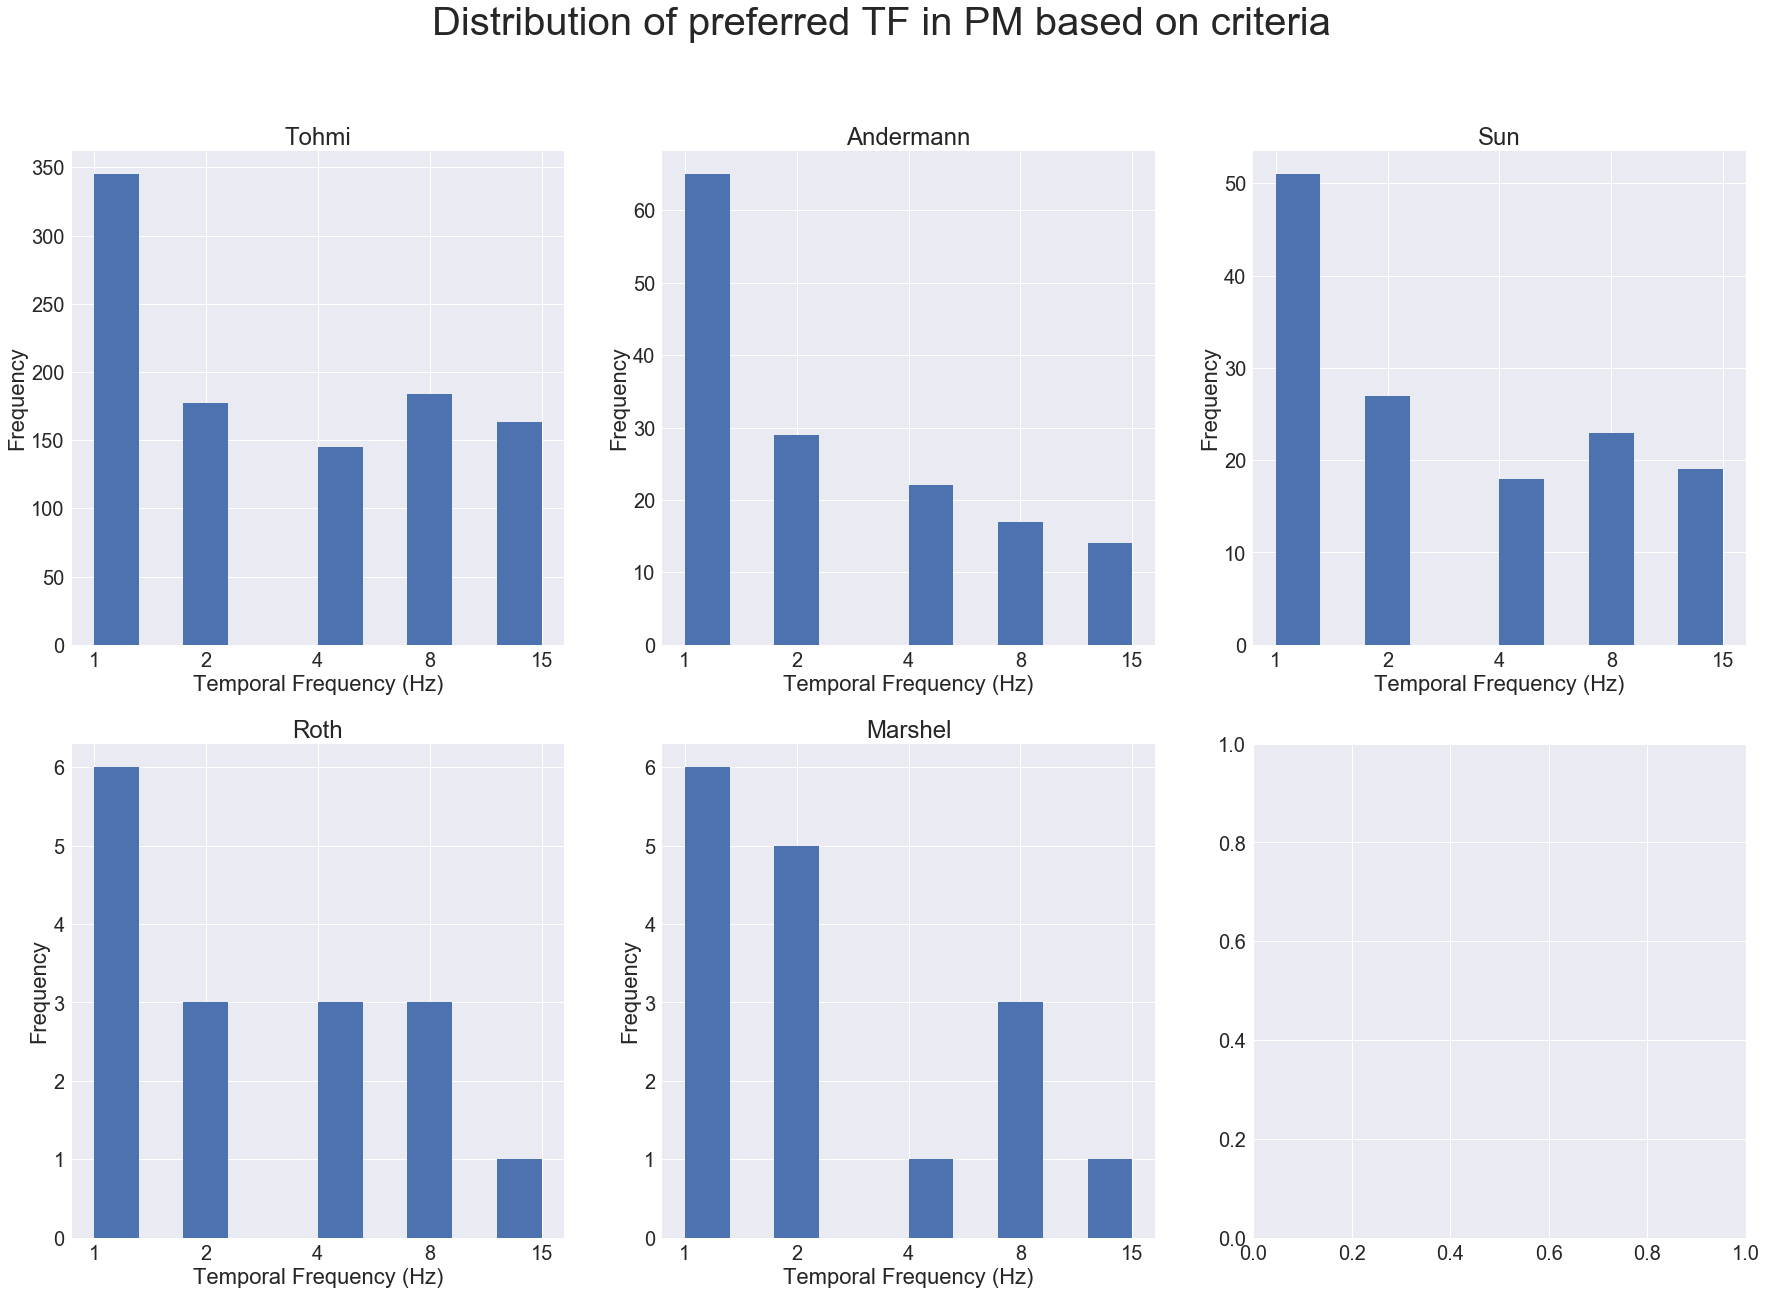

In [12]:
fig7,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in PM based on criteria', fontsize = 40)

for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISpm")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')

#fig5.savefig('Distribution_of_prefTF_by_criteria_PM.jpg')

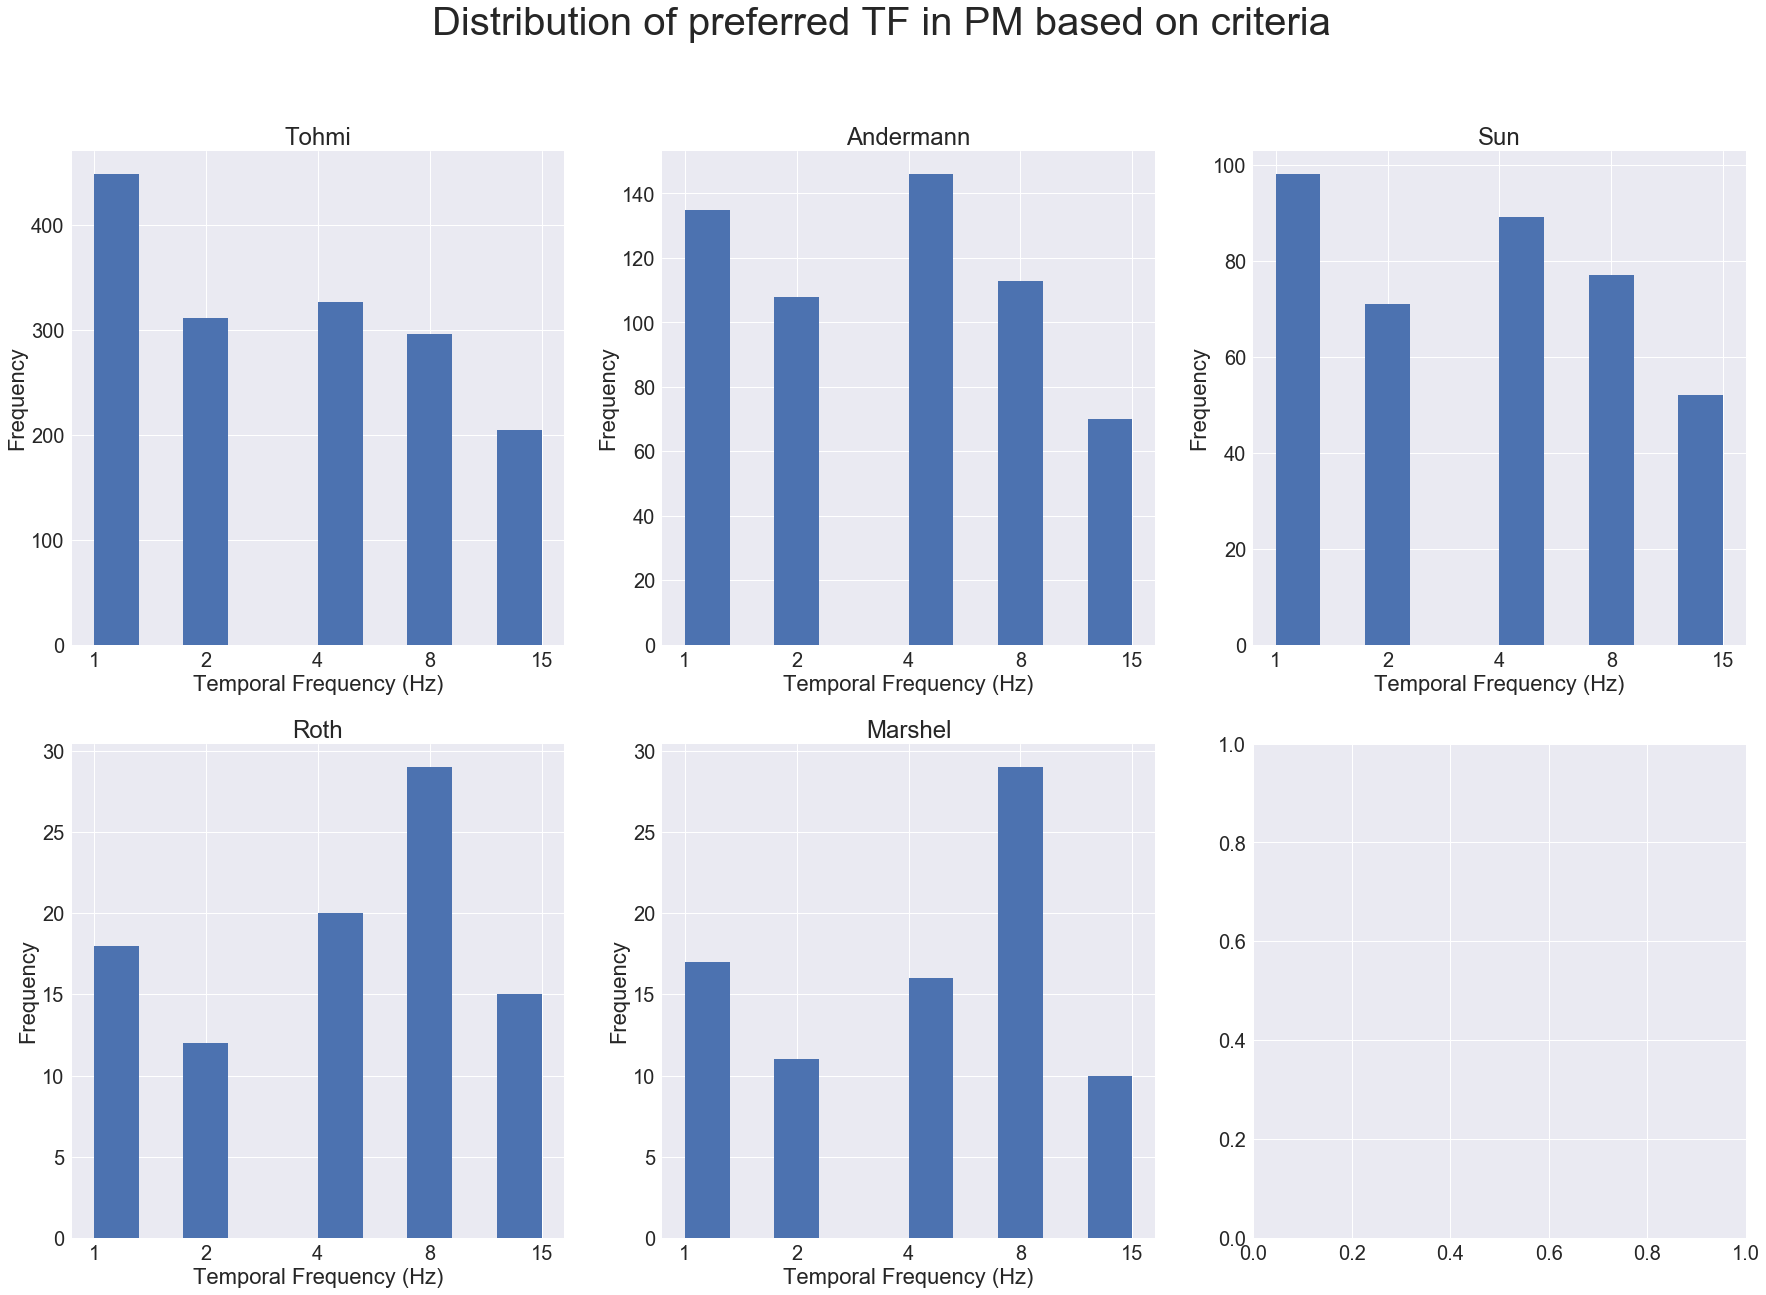

In [13]:
fig8,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in PM based on criteria', fontsize = 40)

for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISal")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')

#fig5.savefig('Distribution_of_prefTF_by_criteria_AL.jpg')

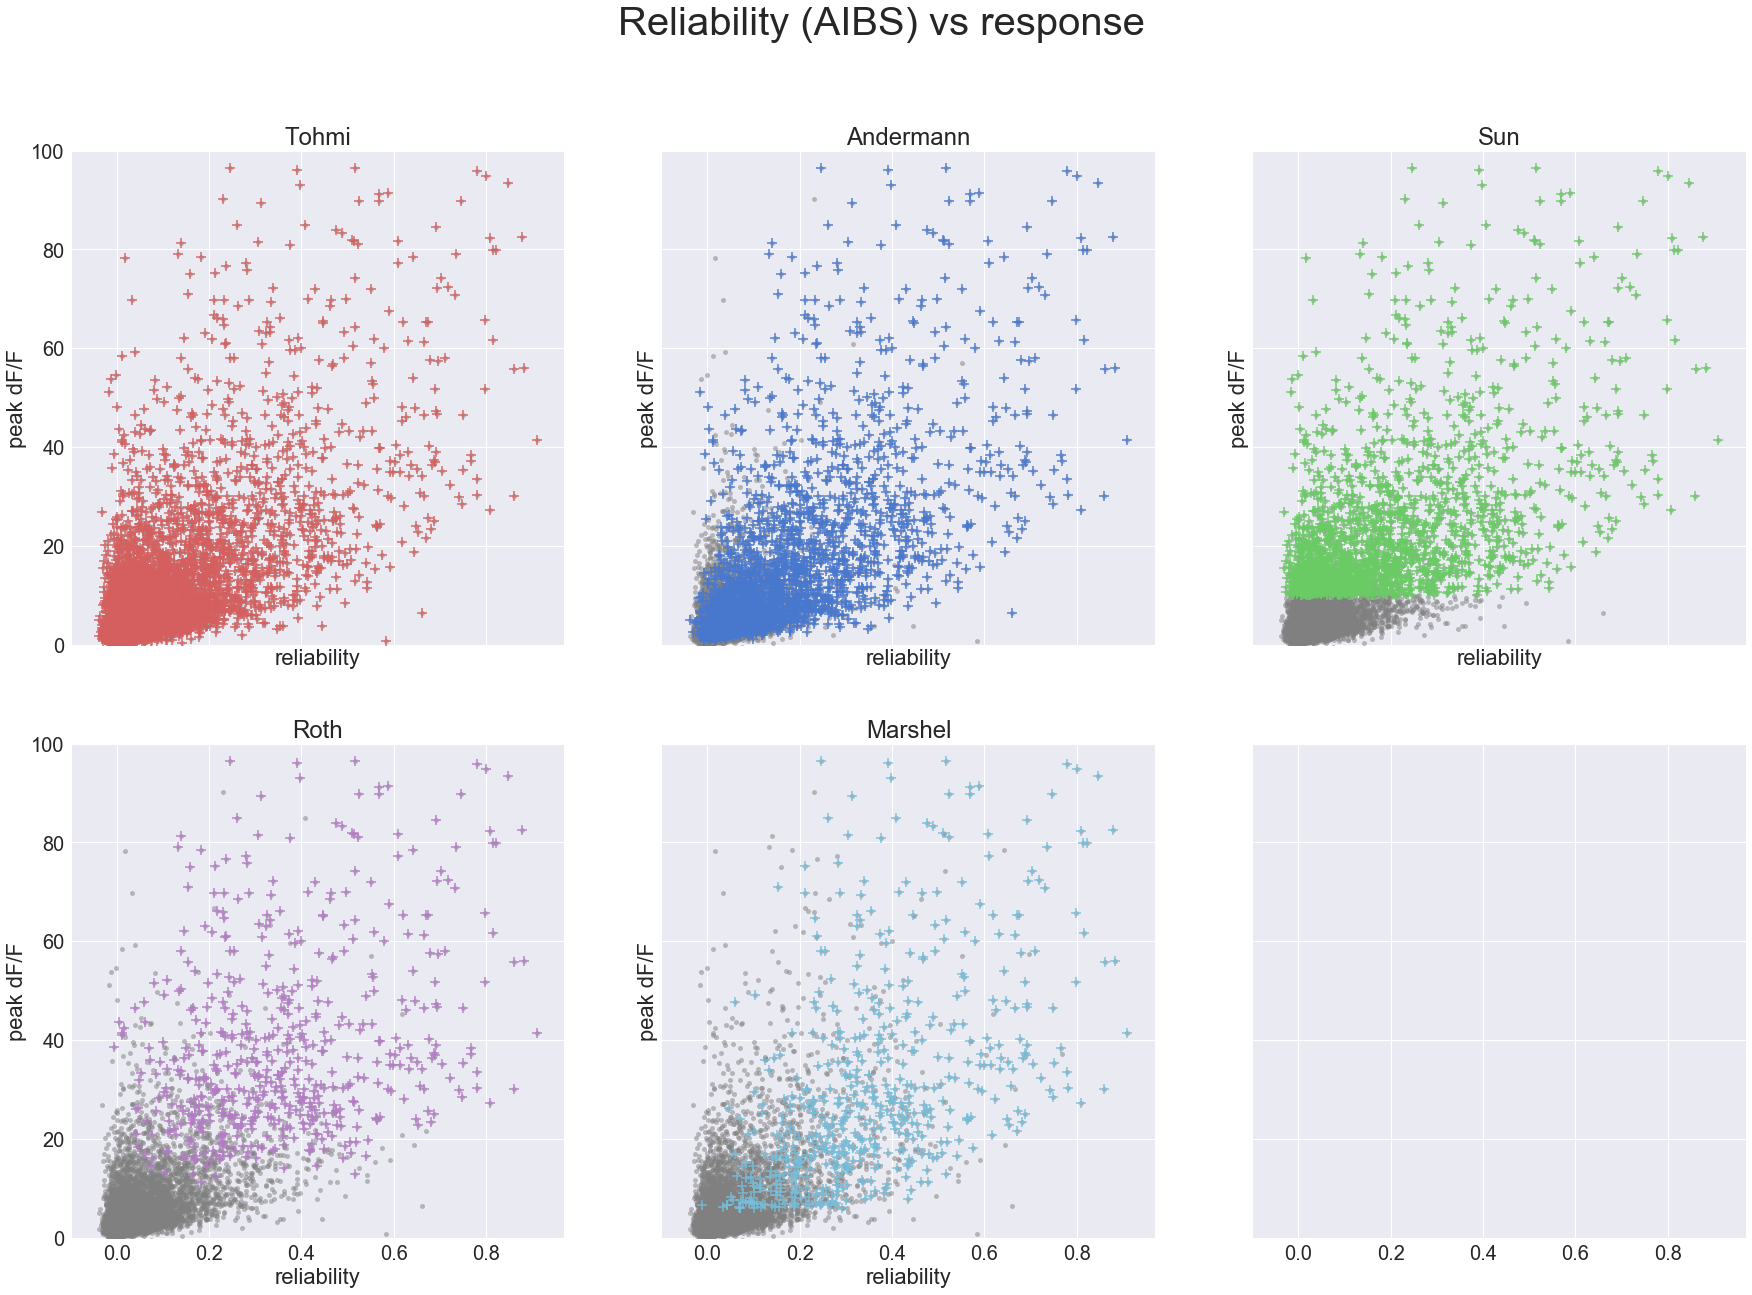

In [14]:
fig9, axs = plt.subplots(2,3, figsize = (30,20 ), sharex = True, sharey = True)
plt.ylim(0, 100)
plt.suptitle('Reliability (AIBS) vs response', fontsize = 40)
#plt.xlim(0, 0.2)

for ii, ax in enumerate(axs.reshape(-1)[:5]):
    sns.regplot(x = 'reliability', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all, 
        color = [0.5,0.5,0.5], 
        marker = '.', 
        scatter_kws = {"s": 100, "alpha": 0.5}, 
        ax = ax)
    sns.regplot(x = 'reliability', 
            y = 'peak dF/F', 
            fit_reg = False,
            data = rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True], 
            color = colors[ii], 
            marker = '+', 
            scatter_kws = {"s": 100}, 
            ax = ax).set_title(criteria[ii])


#fig8.savefig('reliability_vs_response_aibs.jpg')

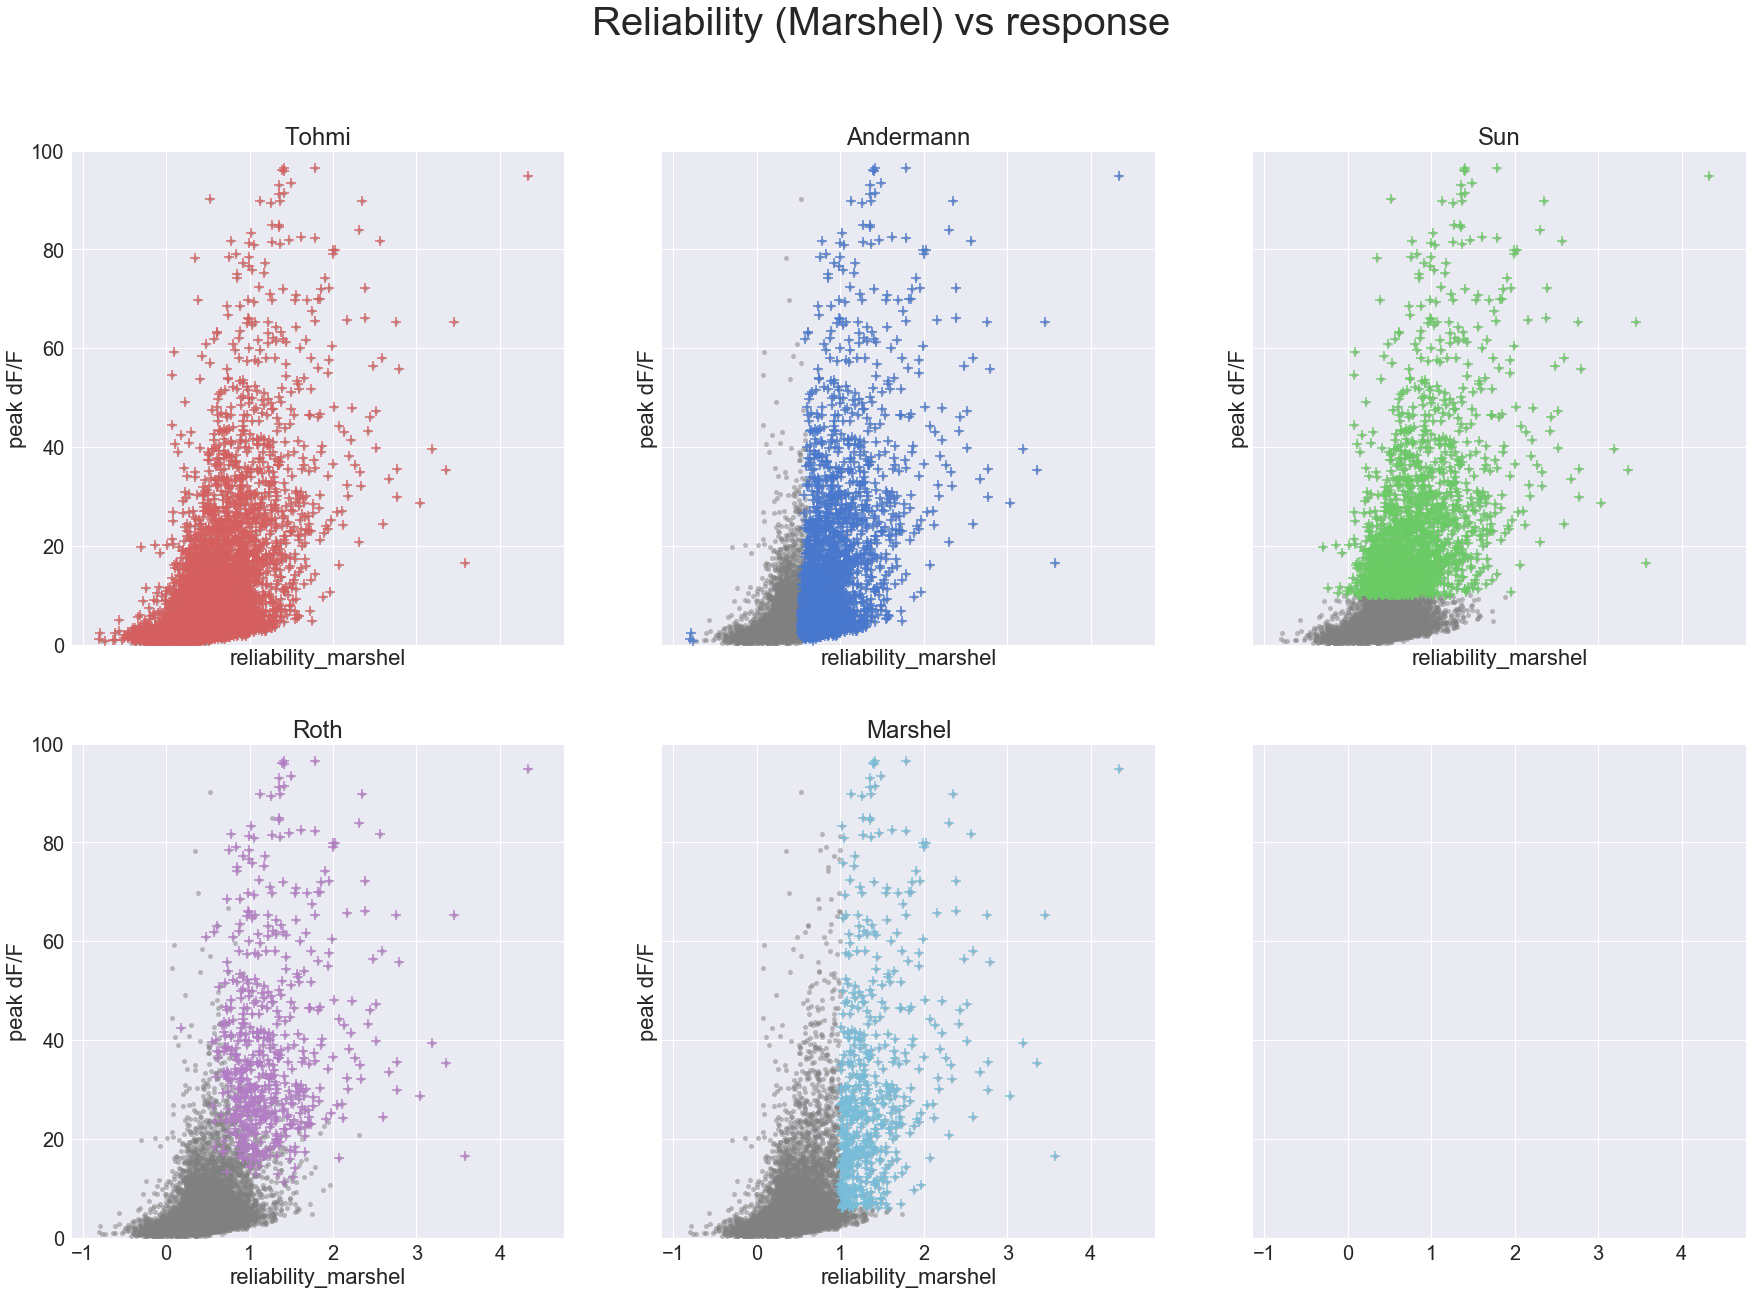

In [15]:

fig10, axs = plt.subplots(2,3, figsize = (30,20 ), sharex = True, sharey = True)
plt.ylim(0, 100)
#plt.xlim(0, 0.2)
plt.suptitle('Reliability (Marshel) vs response', fontsize = 40)

for ii, ax in enumerate(axs.reshape(-1)[:5]):
    sns.regplot(x = 'reliability_marshel', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all, 
        color = [0.5,0.5,0.5], 
        marker = '.', 
        scatter_kws = {"s": 100, "alpha": 0.5}, 
        ax = ax)
    sns.regplot(x = 'reliability_marshel', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True], 
        color = colors[ii], 
        marker = '+', 
        scatter_kws = {"s": 100}, 
        ax = ax).set_title(criteria[ii])


#fig9.savefig('reliability_vs_response_marshel.jpg')

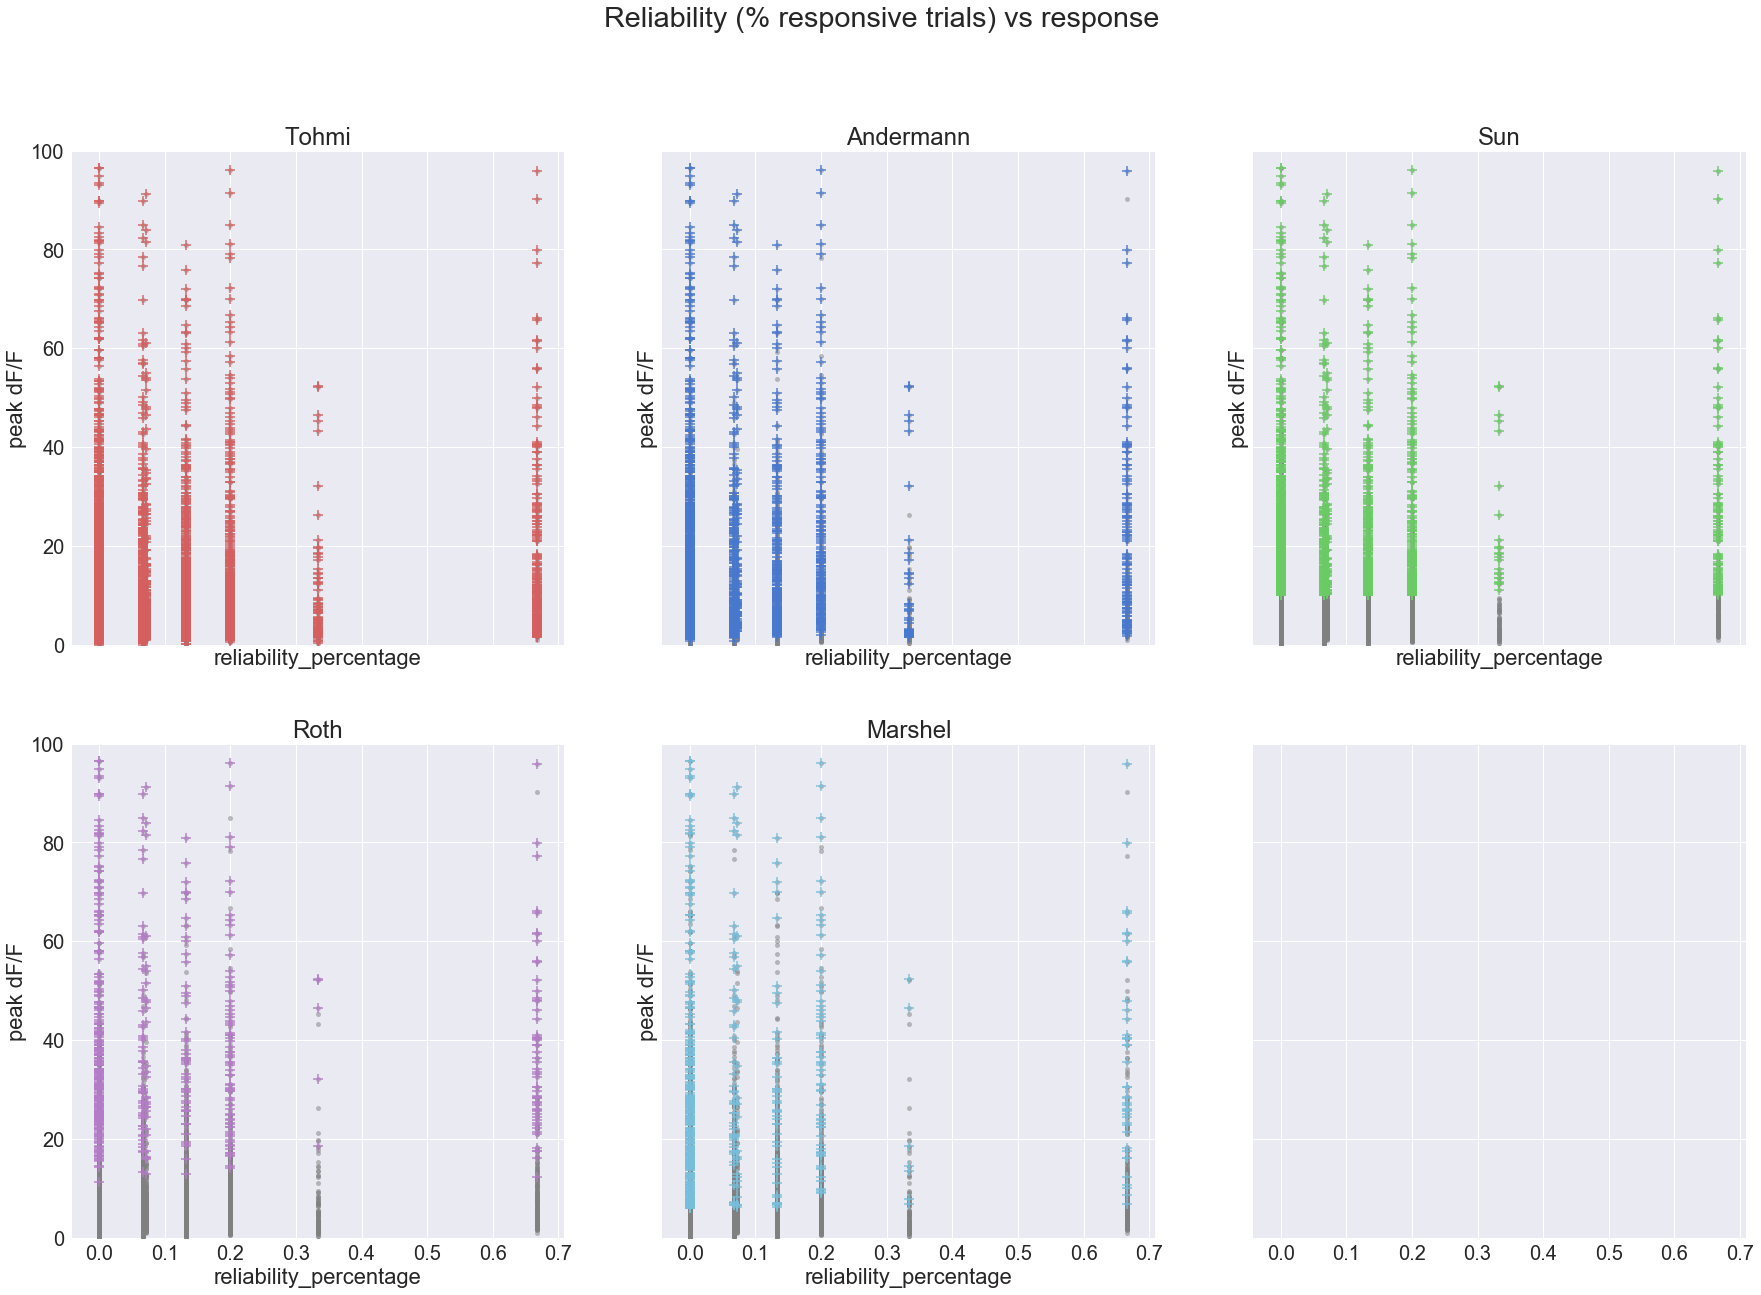

In [16]:
fig11, axs = plt.subplots(2,3, figsize = (30,20 ), sharex = True, sharey = True)
plt.ylim(0, 100)
#plt.xlim(0, 0.2)
plt.suptitle('Reliability (% responsive trials) vs response')
for ii, ax in enumerate(axs.reshape(-1)[:5]):
    sns.regplot(x = 'reliability_percentage', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all, 
        color = [0.5,0.5,0.5], 
        marker = '.', 
        scatter_kws = {"s": 100, "alpha": 0.5}, 
        ax = ax)
    sns.regplot(x = 'reliability_percentage', 
            y = 'peak dF/F', 
            fit_reg = False,
            data = rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True], 
            color = colors[ii], 
            marker = '+', 
            scatter_kws = {"s": 100}, 
            ax = ax).set_title(criteria[ii])


#fig10.savefig('reliability_vs_response_percent_responsive.jpg')

In [17]:
fig9color = colors[ii]

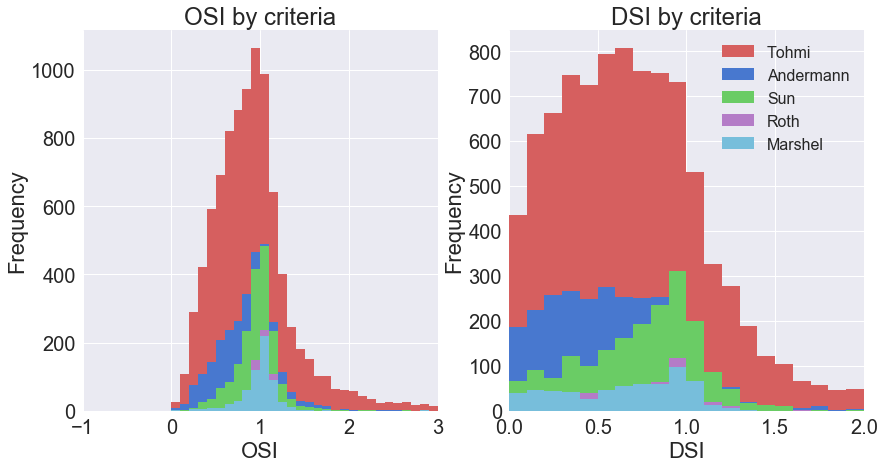

In [18]:
fig3

In [19]:
figs = [fig1, fig3, fig5, fig6, fig7, fig8, fig9, fig10, fig11]

In [20]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('response_vs_reliability_plots.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig)
        fig.clear()
        plt.close(fig)
        del fig
        

In [21]:
# plot traces of cells that meet a certain metric 

# Fit Andermann and not marshel
subset = rel_vs_resp_all[(rel_vs_resp_all['Andermann']) & (rel_vs_resp_all['Marshel']==False) & (rel_vs_resp_all['reliability']> 0.2) & (rel_vs_resp_all['TF'] == 4)]

cell_id = subset.iloc[0]['cell_specimen_id']

cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[cell_id],
                                     stimuli=[stim_info.DRIFTING_GRATINGS])

In [22]:
subset['sweep_response'] = np.nan

In [23]:
rel_vs_resp_all['sweep_response'] = np.nan

In [24]:
subset_copy = subset.copy()

for row in rel_vs_resp_all.iterrows():
    cell_id = row[1]['cell_specimen_id']
    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[cell_id],
                                     stimuli=[stim_info.DRIFTING_GRATINGS])
    data_set = boc.get_ophys_experiment_data(cell_exp[0]['id'])
    dg = DriftingGratings(data_set)
    tf_vals = dg.tfvals
    ori_vals = dg.orivals 
    stim_table = dg.stim_table
    id_idx = int(np.where(dg.cell_id == cell_id)[0])
    pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[id_idx]]
    pref_ori = dg.orivals[dg.peak.ori_dg.iloc[id_idx]]
    cell_sweep_response = dg.sweep_response[str(id_idx)]
    rel_vs_resp_all['sweep_response'].loc[row[0]] = cell_sweep_response
    

KeyboardInterrupt: 

In [ ]:

data_set = boc.get_ophys_experiment_data(cell_exp[0]['id'])
dg = DriftingGratings(data_set)
tf_vals = dg.tfvals
ori_vals = dg.orivals 
stim_table = dg.stim_table
id_idx = int(np.where(dg.cell_id == cell_id)[0])
pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[id_idx]]
pref_ori = dg.orivals[dg.peak.ori_dg.iloc[id_idx]]


In [ ]:
@interact
def showimage(cell = (0,subset.shape[1])):
    cell_id = subset.iloc[cell]['cell_specimen_id']

    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[cell_id],
                                     stimuli=[stim_info.DRIFTING_GRATINGS])
    data_set = boc.get_ophys_experiment_data(cell_exp[0]['id'])
    dg = DriftingGratings(data_set)
    tf_vals = dg.tfvals
    ori_vals = dg.orivals 
    stim_table = dg.stim_table
    id_idx = int(np.where(dg.cell_id == cell_id)[0])
    pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[id_idx]]
    pref_ori = dg.orivals[dg.peak.ori_dg.iloc[id_idx]]
    cell_sweep_response = dg.sweep_response[str(id_idx)]
    
    fig, axs = plt.subplots(len(tf_vals[1:]),len(ori_vals), figsize = (40,30), sharex = True, sharey= True)

    
    for ii, tf in enumerate(tf_vals[1:]):
        for jj, ori in enumerate(ori_vals):
            traces = cell_sweep_response[(stim_table['orientation'] == ori) & (stim_table['temporal_frequency'] == tf)]
            mean_trace = np.mean(traces)
            for trace in traces:
                axs[ii][jj].plot(trace, color = [0.5,0.5,0.5], alpha = 0.5)
            axs[ii,jj].plot(mean_trace, color = 'r', lw = 3)
            if ori == pref_ori and tf == pref_tf:
                axs[ii][jj].plot(mean_trace, color = 'b')
            axs[ii][jj].set_ylim(-20,200)
            axs[ii][jj].set_title("orientation: " + str(ori) +"\n" + "TF: " + str(tf))
            
    sns.set(font_scale = 1)

In [ ]:
subset.shape

In [25]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure 
that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.

with PdfPages('example_cells_Andermann_notMarshel.pdf') as pdf:

    for cell in np.arange(0,subset.shape[1]):
        cell_id = subset.iloc[cell]['cell_specimen_id']

        cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[cell_id],
                                         stimuli=[stim_info.DRIFTING_GRATINGS])
        data_set = boc.get_ophys_experiment_data(cell_exp[0]['id'])
        dg = DriftingGratings(data_set)
        tf_vals = dg.tfvals
        ori_vals = dg.orivals 
        stim_table = dg.stim_table
        id_idx = int(np.where(dg.cell_id == cell_id)[0])
        pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[id_idx]]
        pref_ori = dg.orivals[dg.peak.ori_dg.iloc[id_idx]]
        cell_sweep_response = dg.sweep_response[str(id_idx)]

        fig, axs = plt.subplots(len(tf_vals[1:]),len(ori_vals), figsize = (40,30), sharex = True, sharey= True)


        for ii, tf in enumerate(tf_vals[1:]):
            for jj, ori in enumerate(ori_vals):
                traces = cell_sweep_response[(stim_table['orientation'] == ori) & (stim_table['temporal_frequency'] == tf)]
                mean_trace = np.mean(traces)
                for trace in traces:
                    axs[ii][jj].plot(trace, color = [0.5,0.5,0.5], alpha = 0.5)
                axs[ii,jj].plot(mean_trace, color = 'r', lw = 3)
                if ori == pref_ori and tf == pref_tf:
                    axs[ii][jj].plot(mean_trace, color = 'b')
                axs[ii][jj].set_ylim(-20,200)
                axs[ii][jj].set_title("orientation: " + str(ori) +"\n" + "TF: " + str(tf))



        sns.set(font_scale = 1)
        pdf.savefig(fig)
        fig.clear()
        plt.close(fig)
        del fig

SyntaxError: invalid syntax (<ipython-input-25-d69e76935cf1>, line 8)

NameError: name 'cell_sweep_response' is not defined

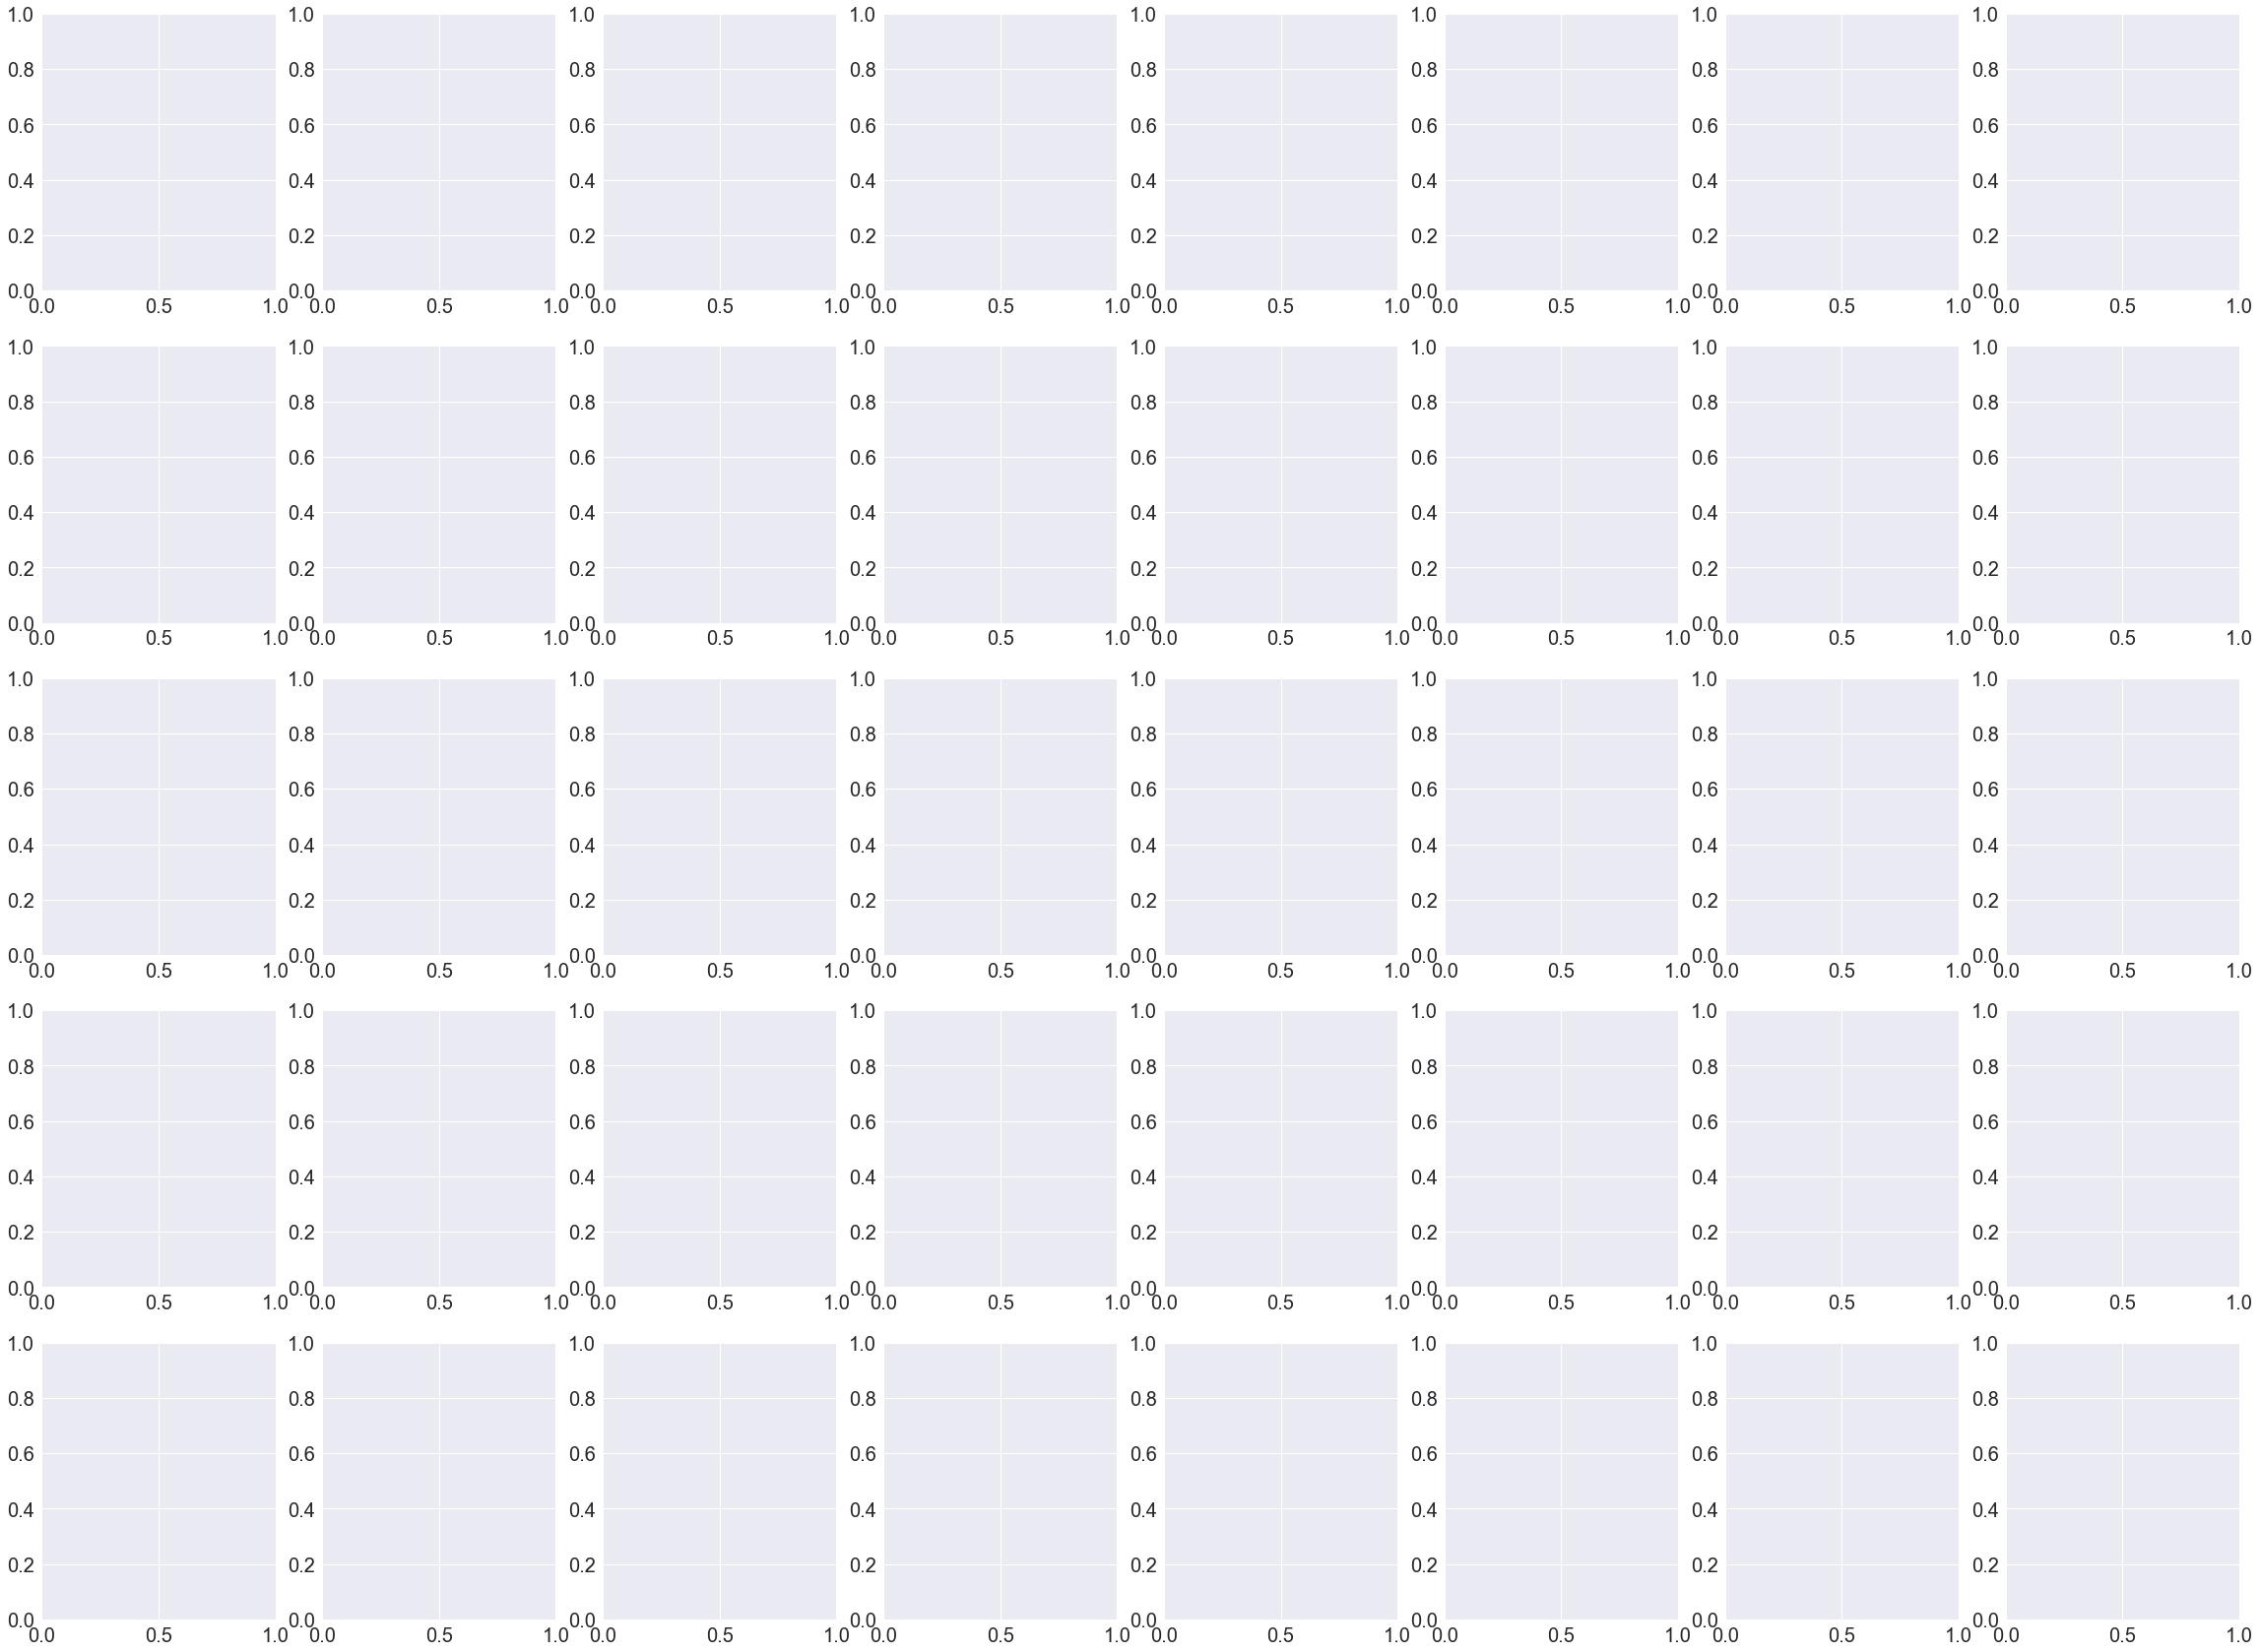

In [26]:
fig, axs = plt.subplots(len(tf_vals[1:]),len(ori_vals), figsize = (40,30))


for ii, tf in enumerate(tf_vals[1:]):
    for jj, ori in enumerate(ori_vals):
        traces = cell_sweep_response[(stim_table['orientation'] == ori) & (stim_table['temporal_frequency'] == tf)]
        mean_trace = np.mean(traces)
        for trace in traces:
            axs[ii][jj].plot(trace, color = 'k')
        axs[ii,jj].plot(trace, color = 'r')

In [ ]:
subset.iloc[]

In [ ]:
cell_id

In [ ]:
rel_vs_resp_all['Marshel'] == False

In [ ]:
# Ephys comparison 

ephys_data_path = r"C:\Users\nataliam\Documents\iPython Notebooks\Widefield sanity check\SpatiotemporalTuningAnalysis\ResponsivenessAnalysis\Responsiveness_Analysis\V1_peak_all.csv"
ephys_data = pd.DataFrame.from_csv(ephys_data_path)



In [ ]:
ephys_data.columns

In [ ]:
#sns.regplot(x = 'num_trials', y = 'peak_resp', data = ephys_data)

fig, ax = plt.subplots(1,1, figsize = (10,10))

sns.regplot(x = 'num_trials', 
    y = 'peak_resp', 
    fit_reg = False,
    data = ephys_data, 
    color = [0.5,0.5,0.5], 
    marker = '.', 
    scatter_kws = {"s": 100, "alpha": 0.5}, 
    ax = ax)
sns.regplot(x = 'num_trials', 
    y = 'peak_resp', 
    fit_reg = False,
    data = ephys_data[ephys_data['responsive_dg']], 
    color = 'r', 
    marker = '.', 
    scatter_kws = {"s": 100, "alpha": 0.5}, 
    ax = ax

In [27]:
literature_tf_values = pd.read_csv('literature_tf.csv')
literature_osi_values = pd.read_csv('literature_OSI.csv')
literature_dsi_values = pd.read_csv('literature_DSI.csv')


In [28]:
literature_tf_values

visual_area  Tohmi  Andermann  Roth  Marshel  Glickfeld
0          V1    1.2        3.0  0.25     0.69        NaN
1          LM    2.0        NaN   NaN     1.80        2.0
2          PM    NaN        1.2  0.50     0.87        1.0
3          AL    3.0        3.8   NaN     1.20        8.0
4          RL    3.0        NaN   NaN     1.30        NaN
5          LI    NaN        NaN   NaN     1.50        NaN
6          AM    NaN        NaN   NaN     1.60        NaN

In [29]:
def print_rank_order(crit, df):
    area_ranking = df[~np.isnan(df[crit])].sort_values(by = crit)['visual_area']
    print crit + ": ",
    for area in area_ranking[:-1]:
        print area + '->',
    print area_ranking.iloc[-1]                      
    print ''

        

In [32]:
for crit in criteria:
    if crit != 'Sun':
        print_rank_order(crit,literature_tf_values)
print_rank_order('Glickfeld', literature_tf_values)

Tohmi:  V1-> LM-> AL-> RL

Andermann:  PM-> V1-> AL

Roth:  V1-> PM

Marshel:  V1-> PM-> AL-> RL-> LI-> AM-> LM

Glickfeld:  PM-> LM-> AL



In [35]:
rank_orders_tf = pd.DataFrame(index = literature_tf_values.visual_area, columns = criteria)
rank_orders_osi = pd.DataFrame(index = literature_osi_values.visual_area, columns = criteria)
rank_orders_dsi = pd.DataFrame(index = literature_dsi_values.visual_area, columns = criteria)

def get_rank_order(crit, df):
    area_ranking = df[~np.isnan(df[crit])].sort_values(by = crit)['visual_area'].index 
    col = pd.DataFrame(index = literature_tf_values.visual_area, columns = ['rank'])
    col.iloc[area_ranking] = np.arange((area_ranking.shape[0])).reshape(area_ranking.shape[0],1) +1
    return col

In [38]:
for crit in criteria: 
    if crit != 'Sun':
        rank_orders_tf[crit] = get_rank_order(crit,literature_tf_values)
    rank_orders_dsi[crit] = get_rank_order(crit,literature_dsi_values)
    rank_orders_osi[crit] = get_rank_order(crit,literature_osi_values)
rank_orders_tf['Glickfeld'] = get_rank_order('Glickfeld',literature_tf_values)
#rank_orders_dsi['Glickfeld'] = get_rank_order('Glickfeld',literature_values_osi)
#rank_orders_osi['Glickfeld'] = get_rank_order('Glickfeld',literature_values_dsi)

In [39]:
rank_orders_tf = rank_orders_tf.drop('Sun', axis = 1)

In [40]:
rank_orders_tf_reset = rank_orders_tf.reset_index()

In [41]:
rank_orders_tf_reset

visual_area Tohmi Andermann Roth  Marshel Glickfeld
0          V1     1         2    1        1       NaN
1          LM     2       NaN  NaN        7         2
2          PM   NaN         1    2        2         1
3          AL     3         3  NaN        3         3
4          RL     4       NaN  NaN        4       NaN
5          LI   NaN       NaN  NaN        5       NaN
6          AM   NaN       NaN  NaN        6       NaN

In [42]:
rel_vs_resp_mod = pd.DataFrame(columns = [rel_vs_resp_all.columns, 'criterion'])

for crit in criteria:
    to_append = rel_vs_resp_all[rel_vs_resp_all[crit]]
    to_append['criterion'] = crit
    rel_vs_resp_mod = rel_vs_resp_mod.append(to_append)

In [43]:

ax0.scatter(literature_tf_values.index,literature_tf_values.Tohmi , marker = '.', s = 200, color = 'r')
ax0.scatter(literature_tf_values.index,literature_tf_values.Andermann , marker = '+', s = 200, color ='b')
ax0.scatter(literature_tf_values.index,literature_tf_values.Marshel, marker = '^', s = 200, color ='m')
ax0.scatter(literature_tf_values.index,literature_tf_values.Roth , marker = 's', s = 200, color ='c')
ax0.scatter(literature_tf_values.index,literature_tf_values.Glickfeld , marker = '*', s = 200, color ='g')


In [44]:

area_order = ['VISp','VISl','VISpm','VISal','VISam','VISrl']
area_colors = ['r','b','g','m','c','k']
area_markershapes = ['.','+','^','s','*','<']

area_order_lit = ['V1','LM','PM','AL','AM','RL','LI']
area_colors_lit = ['r','b','g','m','c','k', 'y']
area_markershapes_lit = ['.','+','^','s','*','<','p']

literature_order = ['Tohmi', 'Andermann', 'Marshel', 'Roth', 'Glickfeld']
literature_order_dict = {'Tohmi':'r', 'Andermann':'b', 'Marshel': 'm', 'Roth':
                        'c', 'Glickfeld':'g'}
literature_markershapes =  ['.','+','^','s','*']

In [45]:
criterion_order_dict = {'Tohmi':'r', 'Andermann':'b', 'Sun': 'g','Marshel': 'm', 'Roth':
                        'c'}

In [46]:
criterion_order = ['Tohmi', 'Andermann', 'Sun', 'Marshel','Roth']

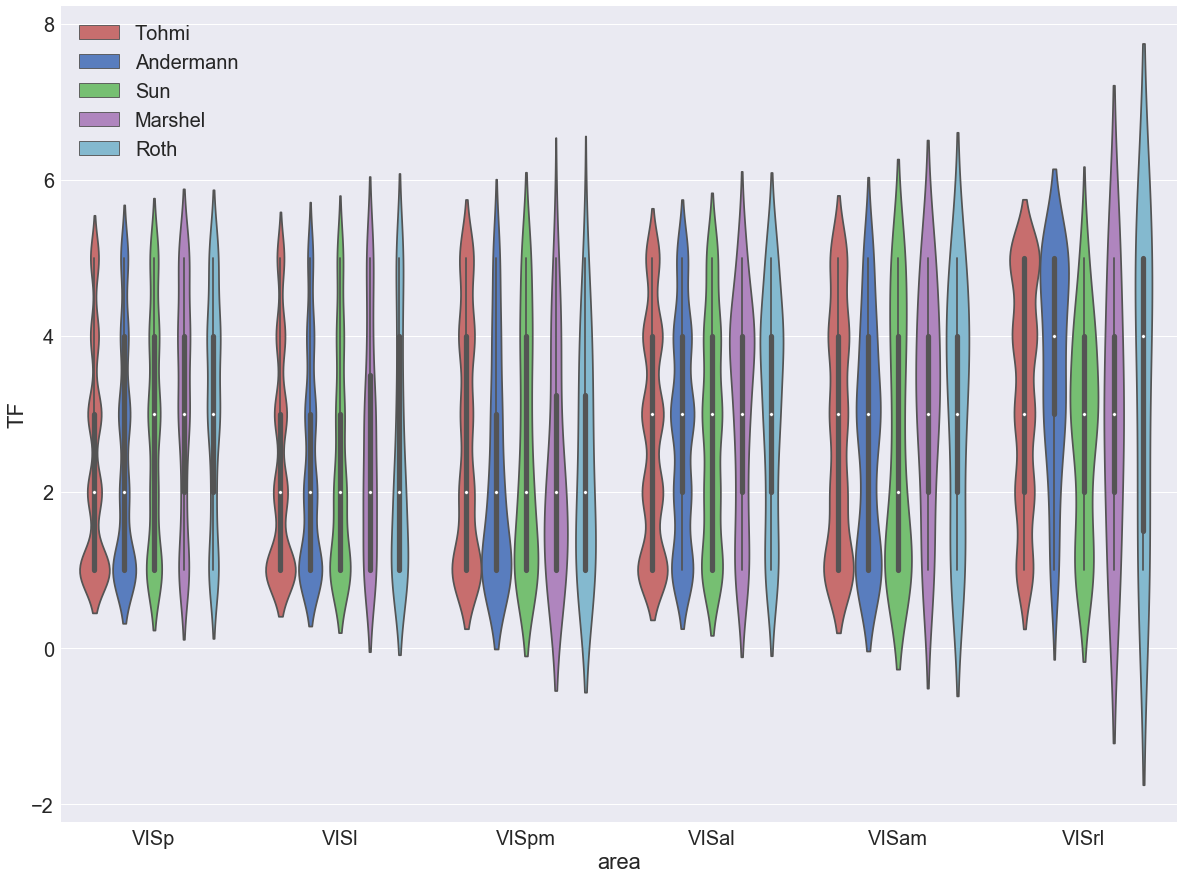

In [47]:
fig, ax = plt.subplots(1,1, figsize = (20,15))

sns.violinplot(x = 'area', y = 'TF', data= rel_vs_resp_mod, palette = criterion_order_dict,order = area_order, hue_order = criterion_order,hue = 'criterion')

ax.legend(loc = 'upper left')

(0, 2)

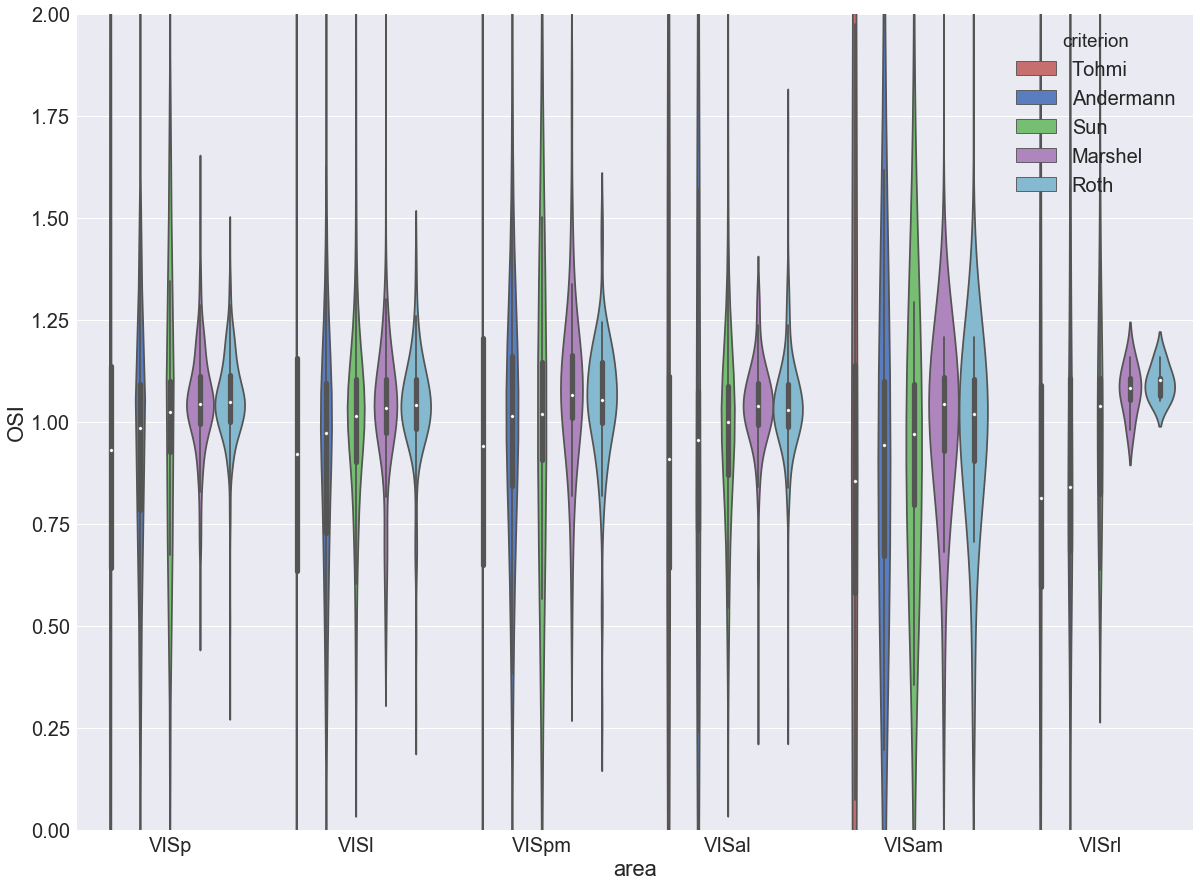

In [382]:
fig, ax = plt.subplots(1,1, figsize = (20,15))
sns.violinplot(x = 'area', y = 'OSI', data= rel_vs_resp_mod, palette = criterion_order_dict,order = area_order, hue_order = criterion_order,hue = 'criterion')
plt.ylim(0,2)

(-1, 2)

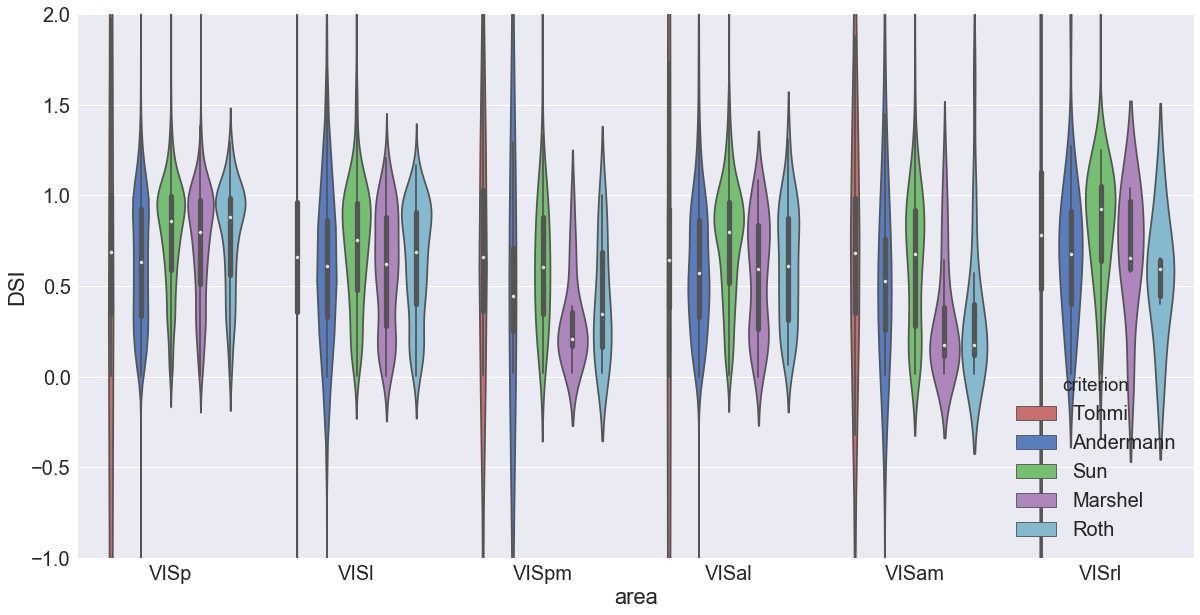

In [48]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
sns.violinplot(x = 'area', y = 'DSI', data= rel_vs_resp_mod, palette = criterion_order_dict,order = area_order, hue_order = criterion_order,hue = 'criterion')
plt.ylim(-1,2)

(0, 2)

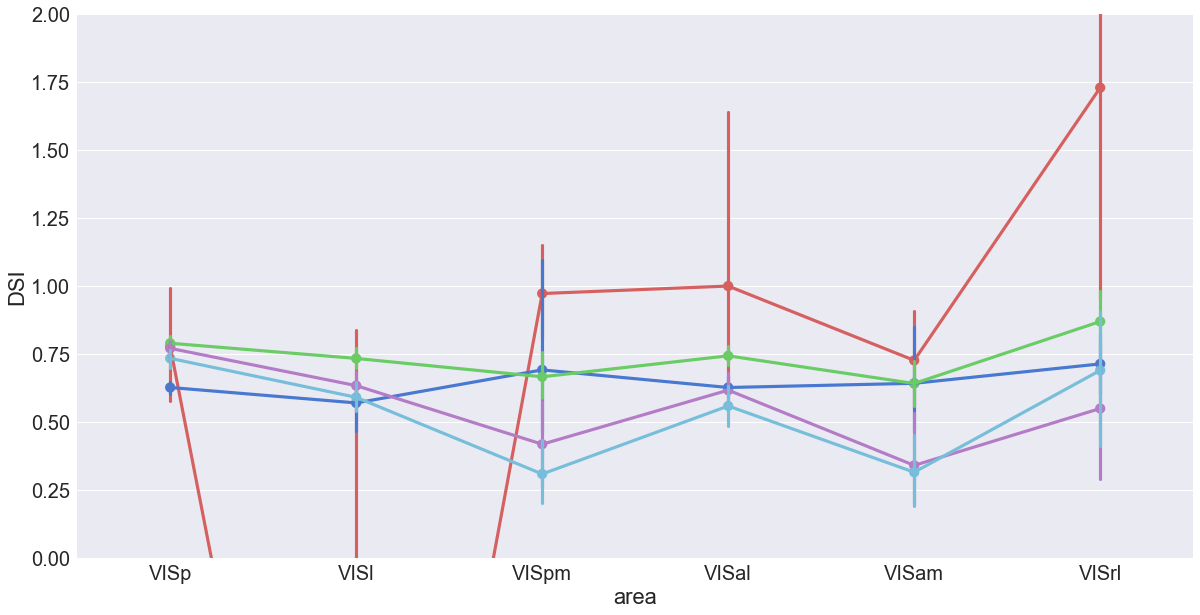

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [49]:
fig, ax = plt.subplots(1,1,figsize = (20,10))

for ii,crit in enumerate(criteria):
    
    sns.factorplot(x= 'area', y = 'DSI',data = rel_vs_resp_all[rel_vs_resp_all[crit]], order = area_order, color = colors[ii], ax = ax)
    plt.clf()
ax.set_ylim(0,2)

(0, 1.5)

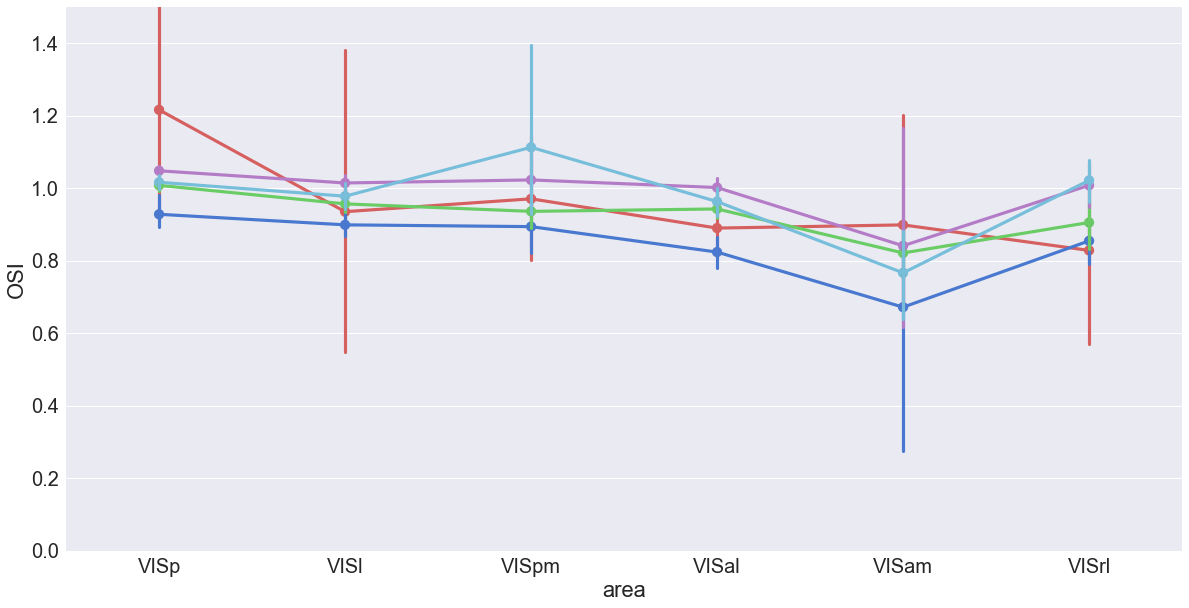

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [50]:
fig, ax = plt.subplots(1,1,figsize = (20,10))

for ii,crit in enumerate(criteria):
    
    sns.factorplot(x= 'area', y = 'OSI',data = rel_vs_resp_all[rel_vs_resp_all[crit]], order = area_order,color = colors[ii], ax = ax)
    plt.clf()
ax.set_ylim(0,1.5)

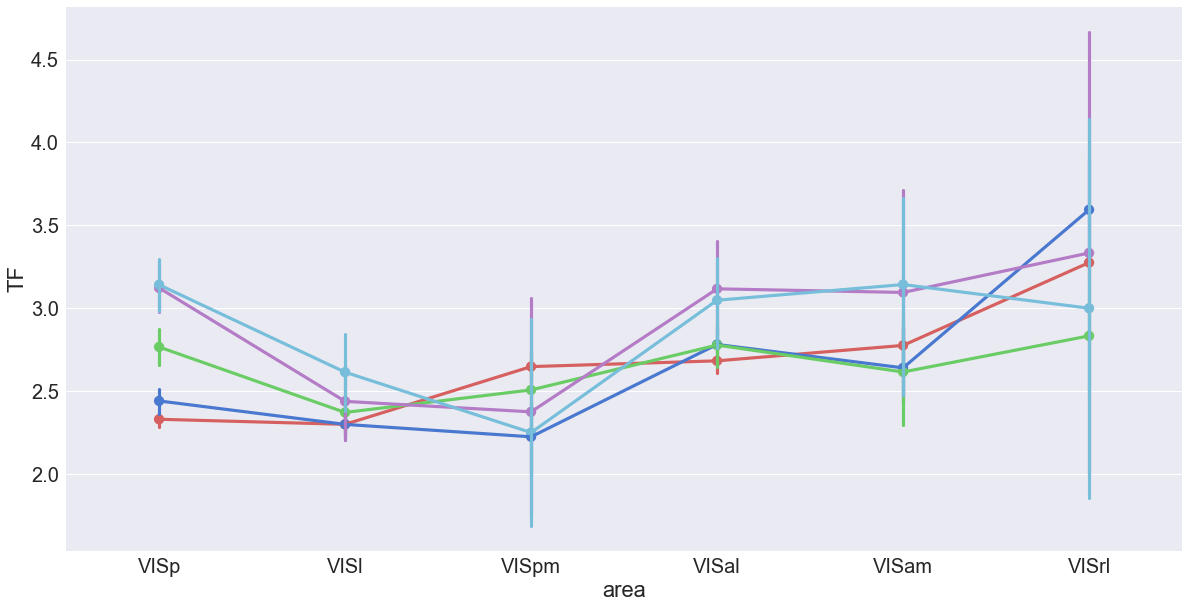

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [51]:
fig, ax = plt.subplots(1,1,figsize = (20,10))

for ii,crit in enumerate(criteria):
    
    sns.factorplot(x= 'area', y = 'TF',data = rel_vs_resp_all[rel_vs_resp_all[crit]], order = area_order, color = colors[ii], ax = ax)
    plt.clf()
#ax.set_ylim(0,1.5)

In [293]:
literature_order = ['Tohmi', 'Andermann', 'Roth','Marshel', 'Glickfeld']
literature_order_dict = {'Tohmi':'r', 'Andermann':'b',  'Roth':
                        'c', 'Marshel': 'm','Glickfeld':'g'}

In [294]:
literature_tf_values_reset = literature_tf_values.drop('visual_area', axis =1)

(0, 8)

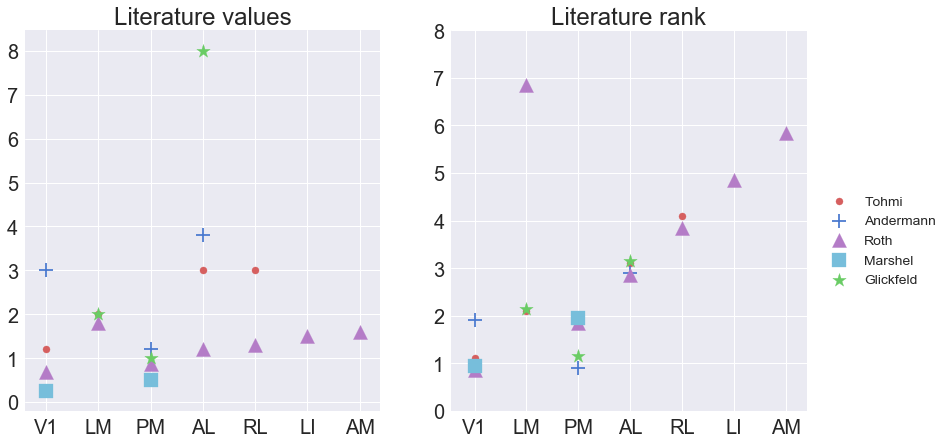

In [299]:
fig01, axs = plt.subplots(1,2,figsize = (14,7))
sns.set(font_scale =2)
ax0 = axs[0]
ax1 = axs[1]

ax0.scatter(literature_tf_values_reset.index,literature_tf_values.Tohmi , marker = '.', s = 200, color = 'r')
ax0.scatter(literature_tf_values_reset.index,literature_tf_values.Andermann , marker = '+', s = 200, color ='b')
ax0.scatter(literature_tf_values_reset.index,literature_tf_values.Roth , marker = 's', s = 200, color ='c')
ax0.scatter(literature_tf_values_reset.index,literature_tf_values.Marshel, marker = '^', s = 200, color ='m')
ax0.scatter(literature_tf_values_reset.index,literature_tf_values.Glickfeld , marker = '*', s = 200, color ='g')

#ax0.legend(literature_order, fontsize = 'xx-small')
ax0.set_title('Literature values')
plt.ylim(0,8)


ax1.scatter(rank_orders_tf.index,rank_orders_tf.Tohmi + 0.1, marker = '.', s = 200, color = 'r')
ax1.scatter(rank_orders_tf.index,rank_orders_tf.Andermann - 0.1, marker = '+', s =200, color ='b')
ax1.scatter(rank_orders_tf.index,rank_orders_tf.Marshel - 0.15, marker = '^', s = 200, color ='m')
ax1.scatter(rank_orders_tf.index,rank_orders_tf.Roth - 0.05, marker = 's', s = 200, color ='c')
ax1.scatter(rank_orders_tf.index,rank_orders_tf.Glickfeld + 0.15, marker = '*', s = 200, color ='g')
ax1.set_title('Literature rank')

ax1.legend(literature_order, fontsize = 'xx-small', loc = 'upper right',bbox_to_anchor=(1, 0.,0.4 , 0.6))
plt.ylim(0,8)

In [298]:
literature_dsi_values_reset = literature_dsi_values
literature_dsi_values_reset.index = literature_dsi_values_reset.visual_area
literature_dsi_values_reset = literature_dsi_values_reset.drop('visual_area', axis =1)

In [67]:
literature_osi_values_reset = literature_osi_values
literature_osi_values_reset.index = literature_osi_values_reset.visual_area
literature_osi_values_reset = literature_osi_values_reset.drop('visual_area', axis =1)

In [68]:
literature_dsi_values_reset

Tohmi  Andermann  Roth  Marshel   Sun
visual_area                                       
V1            0.20       0.45  0.31     0.26  0.44
LM            0.30        NaN   NaN     0.27   NaN
PM             NaN       0.30   NaN     0.29   NaN
AL            0.25       0.16  0.42     0.35   NaN
RL            0.30        NaN   NaN     0.35   NaN
LI             NaN        NaN   NaN     0.28   NaN
AM            0.30        NaN   NaN     0.38   NaN

(0, 8)

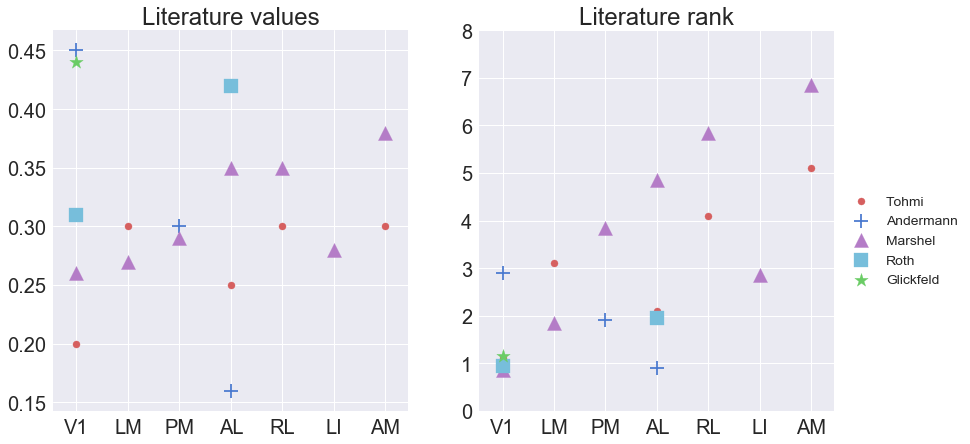

In [287]:
fig02, axs = plt.subplots(1,2,figsize = (14,7))

ax0 = axs[0]
ax1 = axs[1]

ax0.scatter(literature_dsi_values_reset.index,literature_dsi_values.Tohmi , marker = '.', s = 200, color = 'r')
ax0.scatter(literature_dsi_values_reset.index,literature_dsi_values.Andermann , marker = '+', s = 200, color ='b')
ax0.scatter(literature_dsi_values_reset.index,literature_dsi_values.Marshel, marker = '^', s = 200, color ='m')
ax0.scatter(literature_dsi_values_reset.index,literature_dsi_values.Roth , marker = 's', s = 200, color ='c')
ax0.scatter(literature_dsi_values_reset.index,literature_dsi_values.Sun, marker = '*', s = 200, color ='g')

#ax0.legend(literature_order, fontsize = 'xx-small')
ax0.set_title('Literature values')
plt.ylim(0,8)


ax1.scatter(rank_orders_dsi.index,rank_orders_dsi.Tohmi + 0.1, marker = '.', s = 200, color = 'r')
ax1.scatter(rank_orders_dsi.index,rank_orders_dsi.Andermann - 0.1, marker = '+', s =200, color ='b')
ax1.scatter(rank_orders_dsi.index,rank_orders_dsi.Marshel - 0.15, marker = '^', s = 200, color ='m')
ax1.scatter(rank_orders_dsi.index,rank_orders_dsi.Roth - 0.05, marker = 's', s = 200, color ='c')
ax1.scatter(rank_orders_dsi.index,rank_orders_dsi.Sun + 0.15, marker = '*', s = 200, color ='g')
ax1.set_title('Literature rank')

ax1.legend(literature_order, fontsize = 'xx-small', loc = 'upper left',bbox_to_anchor=(1, 0.,0.4 , 0.6))
plt.ylim(0,8)

(0, 8)

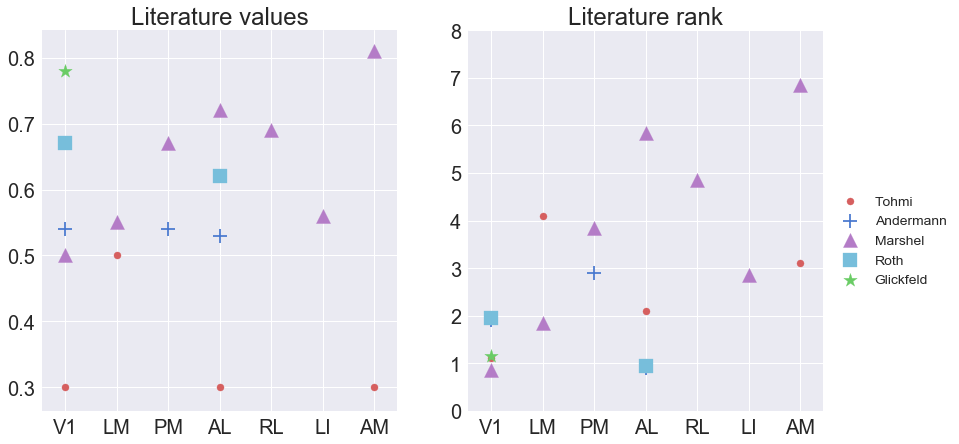

In [288]:
fig03, axs = plt.subplots(1,2,figsize = (14,7))

ax0 = axs[0]
ax1 = axs[1]

ax0.scatter(literature_osi_values_reset.index,literature_osi_values.Tohmi , marker = '.', s = 200, color = 'r')
ax0.scatter(literature_osi_values_reset.index,literature_osi_values.Andermann , marker = '+', s = 200, color ='b')
ax0.scatter(literature_osi_values_reset.index,literature_osi_values.Marshel, marker = '^', s = 200, color ='m')
ax0.scatter(literature_osi_values_reset.index,literature_osi_values.Roth , marker = 's', s = 200, color ='c')
ax0.scatter(literature_osi_values_reset.index,literature_osi_values.Sun, marker = '*', s = 200, color ='g')

#ax0.legend(literature_order, fontsize = 'xx-small')
ax0.set_title('Literature values')
plt.ylim(0,8)


ax1.scatter(rank_orders_osi.index,rank_orders_osi.Tohmi + 0.1, marker = '.', s = 200, color = 'r')
ax1.scatter(rank_orders_osi.index,rank_orders_osi.Andermann - 0.1, marker = '+', s =200, color ='b')
ax1.scatter(rank_orders_osi.index,rank_orders_osi.Marshel - 0.15, marker = '^', s = 200, color ='m')
ax1.scatter(rank_orders_osi.index,rank_orders_osi.Roth - 0.05, marker = 's', s = 200, color ='c')
ax1.scatter(rank_orders_osi.index,rank_orders_osi.Sun + 0.15, marker = '*', s = 200, color ='g')
ax1.set_title('Literature rank')

ax1.legend(literature_order, fontsize = 'xx-small', loc = 'upper left',bbox_to_anchor=(1, 0.,0.4 , 0.6))
plt.ylim(0,8)

In [71]:
literature_tf_values.index = literature_tf_values.visual_area

Text(0.5,1,'Literature rank')

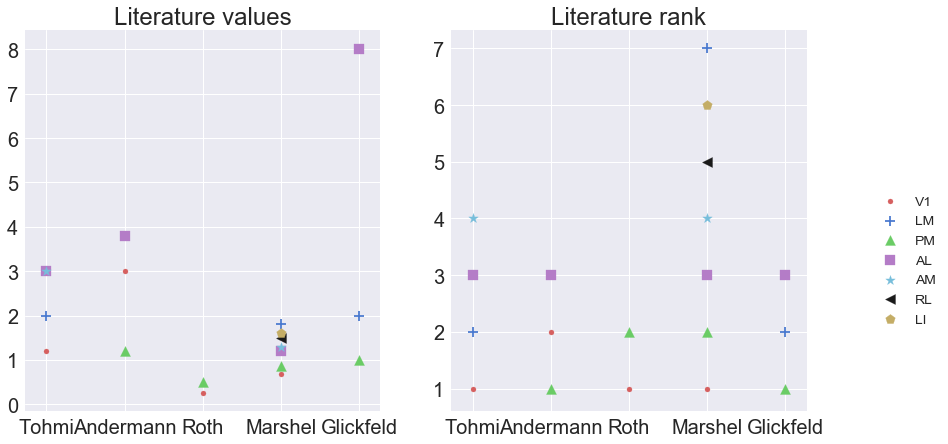

In [302]:

fig04, ax = plt.subplots(1,2, figsize = (14,7))
for ii, va in enumerate(rank_orders_tf.index):
    ax[1].scatter(rank_orders_tf.columns,rank_orders_tf.loc[va], color = area_colors_lit[ii], marker = area_markershapes_lit[ii], s = 100)
    
    ax[0].scatter(literature_tf_values_reset.columns,literature_tf_values_reset.loc[va], color = area_colors_lit[ii], s= 100,marker = area_markershapes_lit[ii])

ax[1].legend(area_order_lit, loc = 'upper_left', fontsize = 'xx-small',bbox_to_anchor=(1, 0.,0.4 , 0.6))
ax[0].set_title('Literature values')
ax[1].set_title('Literature rank')

Text(0.5,1,'Literature rank')

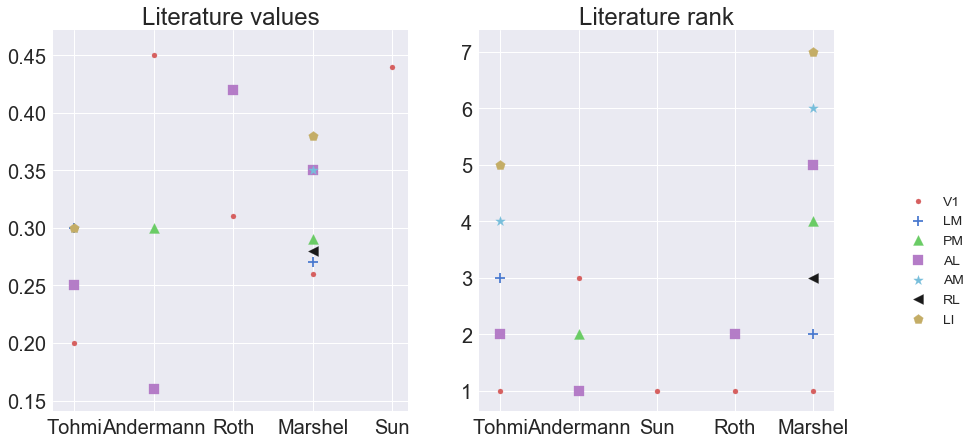

In [303]:

fig05, ax = plt.subplots(1,2, figsize = (14,7))
for ii, va in enumerate(rank_orders_dsi.index):
    ax[1].scatter(rank_orders_dsi.columns,rank_orders_dsi.loc[va], color = area_colors_lit[ii], marker = area_markershapes_lit[ii], s = 100)
    
    ax[0].scatter(literature_dsi_values_reset.columns,literature_dsi_values_reset.loc[va], color = area_colors_lit[ii], s= 100,marker = area_markershapes_lit[ii])

ax[1].legend(area_order_lit, loc = 'upper_left', fontsize = 'xx-small', facecolor = 'w',bbox_to_anchor=(1, 0.,0.4 , 0.6))
ax[0].set_title('Literature values')
ax[1].set_title('Literature rank')

Text(0.5,1,'Literature rank')

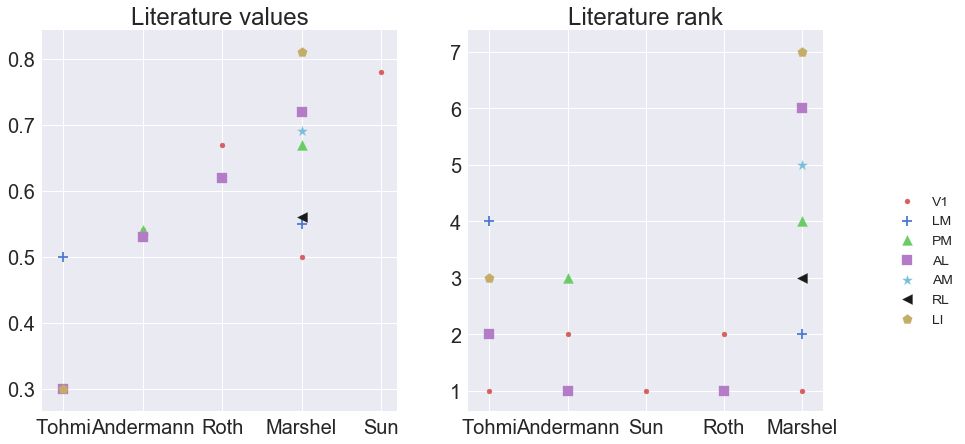

In [305]:

fig06, ax = plt.subplots(1,2, figsize = (14,7))
for ii, va in enumerate(rank_orders_osi.index):
    ax[1].scatter(rank_orders_osi.columns,rank_orders_osi.loc[va], color = area_colors_lit[ii], marker = area_markershapes_lit[ii], s = 100)
    
    ax[0].scatter(literature_osi_values_reset.columns,literature_osi_values_reset.loc[va], color = area_colors_lit[ii], s= 100,marker = area_markershapes_lit[ii])

ax[1].legend(area_order_lit, loc = 'upper_left', fontsize = 'xx-small', facecolor = 'g',bbox_to_anchor=(1, 0.,0.4 , 0.6))
ax[0].set_title('Literature values')
ax[1].set_title('Literature rank')

Text(0.5,1,'Literature Rank')

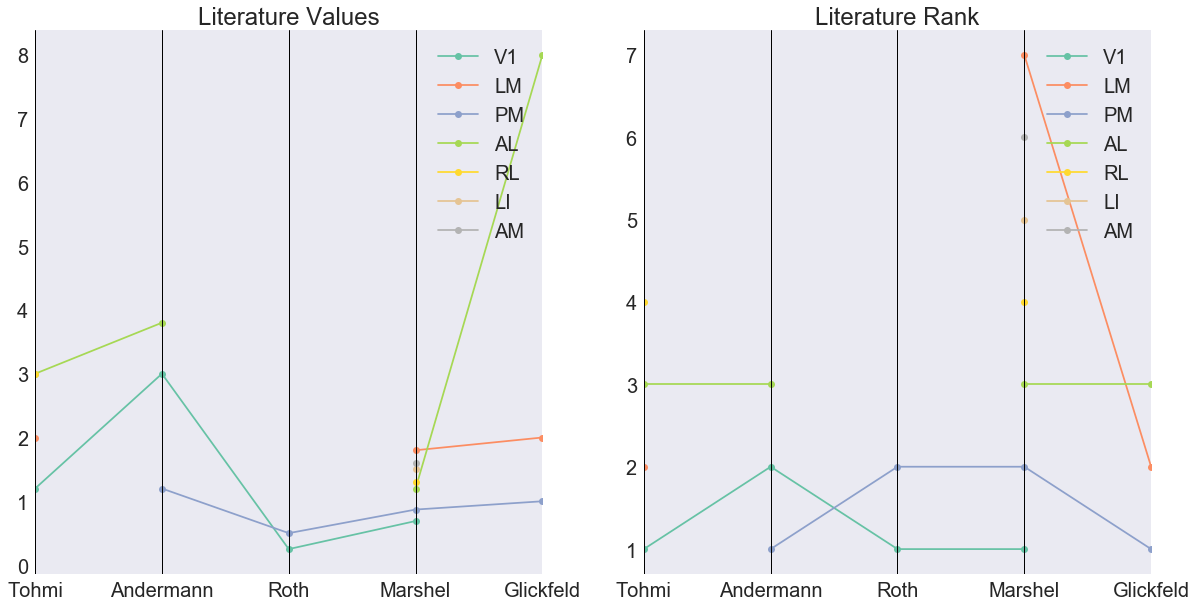

In [77]:
from pandas.tools.plotting import parallel_coordinates

fig, axs = plt.subplots(1,2,figsize = (20,10))
parallel_coordinates(literature_tf_values, 'visual_area', marker = 'o',colormap=plt.get_cmap("Set2"), ax = axs[0])

parallel_coordinates(rank_orders_tf_reset, 'visual_area', marker = 'o',colormap=plt.get_cmap("Set2"), ax = axs[1])

axs[0].set_title('Literature Values')
axs[1].set_title('Literature Rank')


#ax.legend(fontsize = 'xx-small', loc = 'upper left')
#rank_orders_tf_reset.plot(y = rank_orders_tf_reset.columns, kind = 'scatter')
#ax.set_xlim(-1, 6)


In [92]:
observatory_vas = rel_vs_resp_all['area'].unique()
pref_tf_df = pd.DataFrame(index = observatory_vas, columns = criteria)
pref_osi_df = pd.DataFrame(index = observatory_vas, columns = criteria)
pref_dsi_df = pd.DataFrame(index = observatory_vas, columns = criteria)


def convert_tf(df):
    
    df[df == 3] = 4
    df[df == 4] = 8
    df[df == 5] = 15
    return df

for crit in criteria:
    for va in observatory_vas:
        tf_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['TF']
        tf_vals = convert_tf(tf_vals)
        pref_tf_df.loc[va, crit] = tf_vals.mean()
        
        osi_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['OSI']
        pref_osi_df.loc[va, crit] = osi_vals.mean()
        
        dsi_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['DSI']
        pref_dsi_df.loc[va, crit] = dsi_vals.mean()

In [134]:
pref_tf_specimen = rel_vs_resp_all.groupby(by = 'id').mean()

In [144]:
rel_vs_resp_all[(rel_vs_resp_all['area']=='VISp') & (rel_vs_resp_all[crit] == True)].groupby('id').mean()['TF']

id
501574836.0    2.947368
502608215.0    3.437500
503109347.0    3.000000
524691284.0    3.425532
645413759.0    2.855263
647155122.0    3.576923
653122667.0    3.700000
657080632.0    3.000000
658536111.0    3.000000
660513003.0    2.500000
661328410.0    2.000000
679702884.0    2.909091
702934964.0    4.222222
712178511.0    2.090909
Name: TF, dtype: float64

In [147]:
 rel_vs_resp_all[rel_vs_resp_all[crit] == True].groupby(by = 'id').mean()

Andermann       DSI  Marshel       OSI      Roth       Sun  \
id                                                                        
501574836.0        1.0  0.831575      1.0  1.157327  0.684211  0.789474   
502608215.0        1.0  0.861273      1.0  1.047931  0.875000  0.937500   
503109347.0        1.0  0.797725      1.0  1.133379  0.733333  0.933333   
505407318.0        1.0  0.504693      1.0  1.003239  0.785714  0.928571   
505845219.0        1.0  0.311532      1.0  1.257541  0.666667  0.777778   
506823562.0        1.0  0.630528      1.0  0.982037  0.700000  0.900000   
507464107.0        1.0  0.127429      1.0  0.907345  0.000000  0.500000   
507691036.0        1.0  0.189240      1.0  1.049124  1.000000  1.000000   
507990552.0        1.0  0.536998      1.0  1.089414  0.818182  0.909091   
509958730.0        1.0  0.641607      1.0  1.045746  0.681818  0.818182   
512164988.0        1.0  0.672318      1.0  1.083811  0.875000  1.000000   
512326618.0        1.0  0.420035      1.0  1.041597  0.900000  1.000000   
524691284.0        1.0  0.772426      1.0  1.082520  0.893617  0.957447   
529688779.0        1.0  0.412296      1.0  1.083323  1.000000  1.000000   
558670888.0        1.0  0.848881      1.0  1.033738  0.846154  0.923077   
566307038.0        1.0  0.365215      1.0  0.803055  0.800000  1.000000   
570008444.0        1.0  1.039087      1.0  1.064413  1.000000  1.000000   
570305847.0        1.0  0.129044      1.0  1.007276  0.750000  1.000000   
595229536.0        1.0  0.076892      1.0  0.468064  1.000000  1.000000   
627823344.0        1.0  0.529854      1.0  0.919463  0.578947  0.894737   
638056634.0        1.0  0.530185      1.0  0.755560  0.333333  0.777778   
639931541.0        1.0  0.448409      1.0  0.915933  0.500000  0.750000   
645256361.0        1.0  0.802343      1.0  1.014546  0.500000  1.000000   
645413759.0        1.0  0.713001      1.0  0.906309  0.671053  0.842105   
647155122.0        1.0  0.733891      1.0  1.043660  0.538462  0.923077   
652094917.0        1.0  0.481420      1.0  1.004585  0.500000  1.000000   
653122667.0        1.0  0.757878      1.0  1.078361  0.900000  1.000000   
653123929.0        1.0  0.659408      1.0  0.838577  0.366667  0.733333   
657080632.0        1.0  0.797903      1.0  1.004650  0.588235  0.941176   
657391037.0        1.0  0.575070      1.0  1.009206  0.500000  1.000000   
658536111.0        1.0  0.680380      1.0  1.074936  0.545455  0.909091   
660510593.0        1.0  1.023683      1.0  1.020195  0.000000  1.000000   
660513003.0        1.0  0.532971      1.0  1.081946  1.000000  1.000000   
661328410.0        1.0  0.845042      1.0  1.080932  0.285714  0.714286   
662348804.0        1.0  0.692699      1.0  1.066531  0.800000  0.800000   
662359728.0        1.0  0.148140      1.0  0.864911  0.000000  1.000000   
672207947.0        1.0  0.519817      1.0  0.974364  0.764706  0.823529   
679700458.0        1.0  0.208502      1.0  1.103250  0.000000  1.000000   
679702884.0        1.0  0.626763      1.0  1.008691  0.522727  0.863636   
699155265.0        1.0  0.439505      1.0  0.985030  0.800000  1.000000   
701046700.0        1.0  0.216475      1.0  0.730287  0.000000  0.500000   
702934964.0        1.0  0.656587      1.0  1.032027  0.777778  1.000000   
704822876.0        1.0  0.437527      1.0  0.954547  0.636364  0.818182   
706566686.0        1.0  0.552826      1.0  1.014076  0.800000  1.000000   
710469199.0        1.0  0.385611      1.0  0.576325  0.500000  0.750000   
712178511.0        1.0  0.390281      1.0  0.751610  0.181818  0.636364   
712919665.0        1.0  0.145050      1.0  0.973093  1.000000  1.000000   

                   TF  Tohmi  cell_specimen_id       p_blank  peak dF/F  \
id                                                                        
501574836.0  2.947368    1.0      5.285914e+08  8.875317e-01  39.446588   
502608215.0  3.437500    1.0      5.279263e+08  4.566026e-02  42.012970   
503109347.0  3.000000    1.0      5.3

In [204]:
pref_tf_specimen = pd.DataFrame(columns = ['id','TF','rank','area','criteria'])

for va in observatory_vas:
    for crit in criteria:

        to_append = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)].groupby(by = 'id').mean()['TF'].reset_index()
        to_append['area'] = va
        to_append['criteria'] = crit
        pref_tf_specimen = pref_tf_specimen.append(to_append)
                                                                               

In [227]:
to_append.shape[0]

3

In [228]:
pref_osi_specimen = pd.DataFrame(columns = ['id','OSI','area','criteria'])

for va in observatory_vas:
    for crit in criteria:

        to_append = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)].groupby(by = 'id').mean()['OSI'].reset_index()
        to_append['area'] = va
        to_append['criteria'] = crit
        to_append = to_append.sort_values(by = 'OSI')
        pref_osi_specimen = pref_osi_specimen.append(to_append)
                                                                               

In [206]:
pref_dsi_specimen = pd.DataFrame(columns = ['id','DSI','area','criteria'])

for va in observatory_vas:
    for crit in criteria:

        to_append = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)].groupby(by = 'id').mean()['DSI'].reset_index()
        to_append['area'] = va
        to_append['criteria'] = crit
        pref_dsi_specimen = pref_dsi_specimen.append(to_append)
                                                                               

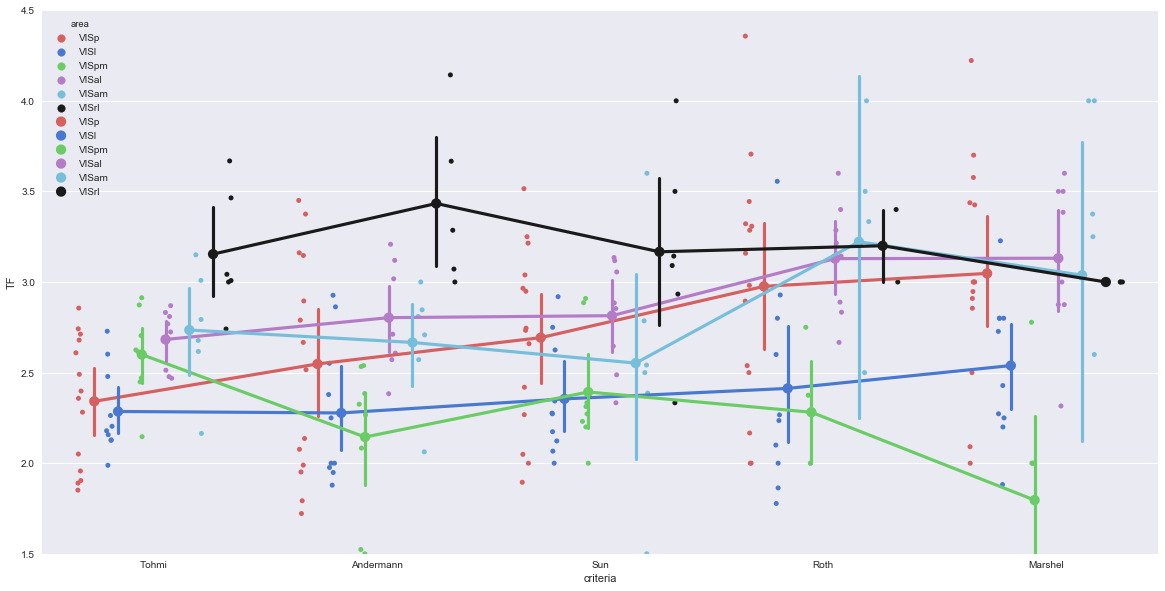

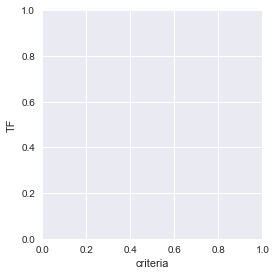

In [225]:
fig07, ax = plt.subplots(1,1, figsize = (20,10))
sns.set(font_scale=1)
sns.stripplot(x = 'criteria',
              y = 'TF',
              hue = 'area',
              hue_order = area_order,
              palette = area_colors,
              dodge=True, 
              jitter = True, 
              data = pref_tf_specimen, 
              zorder=1, 
             ax = ax)
#sns.factorplot(x="criteria", y="TF", hue="area",
#             data=pref_tf_specimen, dodge=.532, join=False, palette="dark",
 #             markers="d", scale=.75, ci=None)
    
ax.set_ylim(1.5, 4.5)
sns.factorplot(x = 'criteria',
               jitter = True,
               dodge = .532, 
               palette = area_colors,
               y = 'TF', 
               hue_order = area_order,
               hue = 'area',
               data = pref_tf_specimen, 
               ax = ax,
              fontsize = 40)



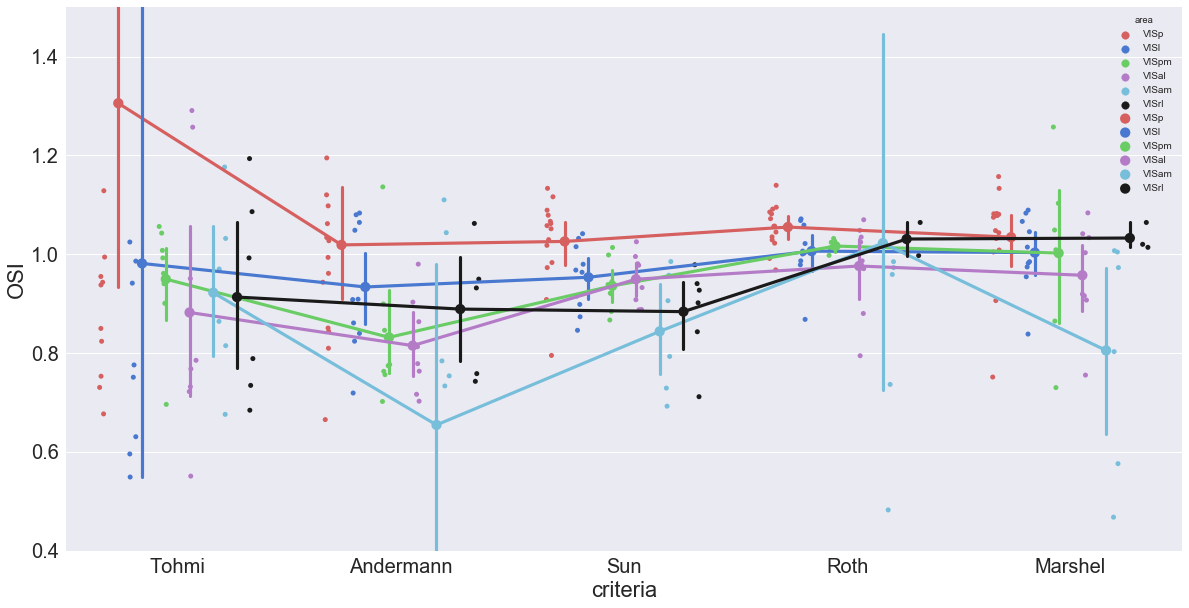

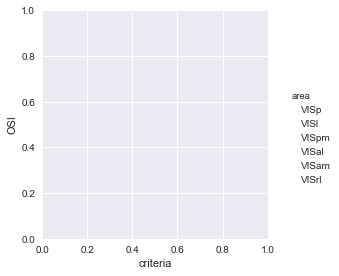

In [289]:
fig08, ax = plt.subplots(1,1, figsize = (20,10))
sns.set(font_scale=1)
sns.stripplot(x = 'criteria',
              y = 'OSI',
              hue = 'area',
              hue_order = area_order,
              palette = area_colors,
              dodge=True, 
              jitter = True, 
              data = pref_osi_specimen, 
              zorder=1, 
             ax = ax)
#sns.factorplot(x="criteria", y="TF", hue="area",
#             data=pref_tf_specimen, dodge=.532, join=False, palette="dark",
 #             markers="d", scale=.75, ci=None)
    
ax.set_ylim(0.4,1.5)
sns.factorplot(x = 'criteria', jitter = True, dodge = .532, palette = area_colors,y = 'OSI', hue_order = area_order, hue = 'area',data = pref_osi_specimen, ax = ax, fontsize = 40)

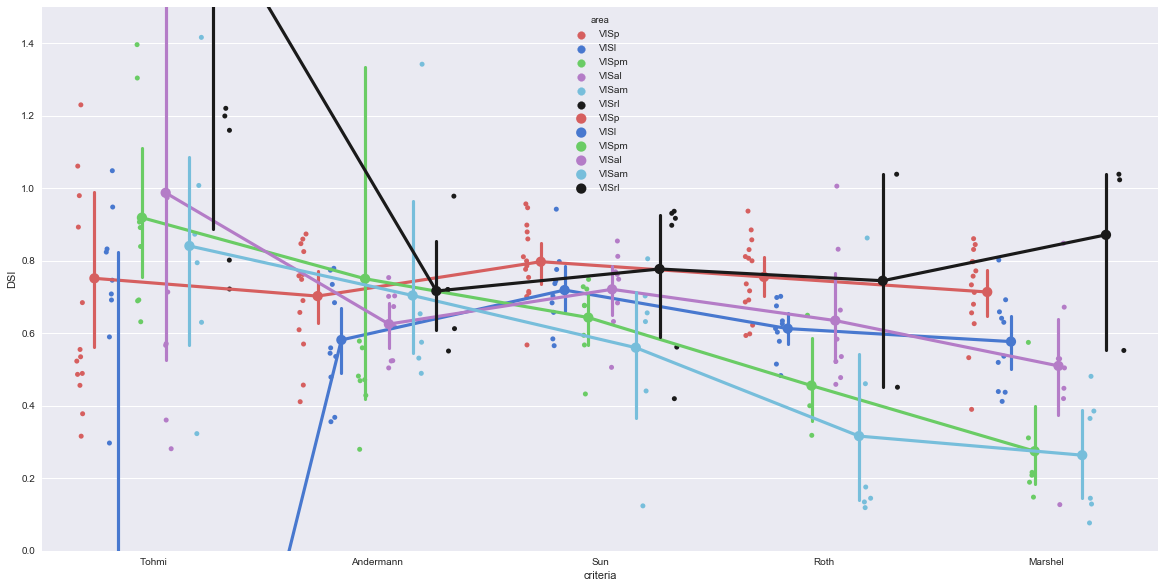

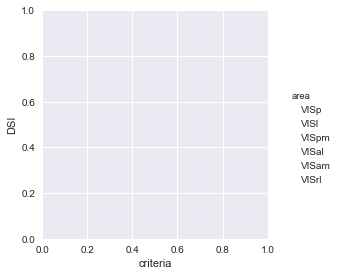

In [290]:
fig09, ax = plt.subplots(1,1, figsize = (20,10))
sns.stripplot(x = 'criteria',
              y = 'DSI',
              hue = 'area',
              hue_order = area_order,
              palette = area_colors,
              dodge=True, 
              jitter = True, 
              data = pref_dsi_specimen, 
              zorder=1, 
             ax = ax)
#sns.factorplot(x="criteria", y="TF", hue="area",
#             data=pref_tf_specimen, dodge=.532, join=False, palette="dark",
 #             markers="d", scale=.75, ci=None)
    
ax.set_ylim(0, 1.5)
sns.factorplot(x = 'criteria', jitter = True, dodge = .532, palette = area_colors,y = 'DSI', hue_order = area_order, hue = 'area',data = pref_dsi_specimen, ax = ax, fontsize = 40)

In [150]:
rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)].groupby(by = 'id').mean()['TF']

id
570008444.0    3.0
660510593.0    3.0
706566686.0    3.0
Name: TF, dtype: float64

In [ ]:
observatory_vas = rel_vs_resp_all['area'].unique()
pref_tf_df_ = pd.DataFrame(index = observatory_vas, columns = criteria)
pref_osi_df = pd.DataFrame(index = observatory_vas, columns = criteria)
pref_dsi_df = pd.DataFrame(index = observatory_vas, columns = criteria)


def convert_tf(df):
    
    df[df == 3] = 4
    df[df == 4] = 8
    df[df == 5] = 15
    return df

for crit in criteria:
    for va in observatory_vas:
        tf_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['TF']
        tf_vals = convert_tf(tf_vals)
        pref_tf_df.loc[va, crit] = tf_vals.mean()
        
        osi_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['OSI']
        pref_osi_df.loc[va, crit] = osi_vals.mean()
        
        dsi_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['DSI']
        pref_dsi_df.loc[va, crit] = dsi_vals.mean()

In [136]:
pref_dsi_df

Tohmi Andermann       Sun      Roth   Marshel
VISp   0.776872  0.626682  0.789465  0.770625  0.733836
VISl   -2.73629  0.569808  0.733499  0.633459   0.59039
VISpm   0.97228  0.691344  0.665985  0.417845  0.308297
VISal  0.999795  0.626562  0.743102  0.616927  0.558567
VISam  0.726372  0.641961  0.641359  0.339978  0.314854
VISrl   1.72964  0.713334  0.869285  0.549293  0.689557

In [93]:
rank_orders_tf_ob = pd.DataFrame(index = pref_tf_df.index, columns = criteria)
rank_orders_osi_ob = pd.DataFrame(index = pref_osi_df.index, columns = criteria)
rank_orders_dsi_ob = pd.DataFrame(index = pref_dsi_df.index, columns = criteria)


def get_rank_order(crit, df):
    area_ranking = df.sort_values(by = crit).index
    col = pd.DataFrame(index = df['index'], columns = ['rank'])
    col.iloc[area_ranking] = np.arange(area_ranking.shape[0]).reshape(area_ranking.shape[0],1) +1
    return col

for crit in criteria: 
    rank_orders_tf_ob[crit] = get_rank_order(crit,pref_tf_df.reset_index())
    rank_orders_osi_ob[crit] = get_rank_order(crit,pref_osi_df.reset_index())
    rank_orders_dsi_ob[crit] = get_rank_order(crit,pref_dsi_df.reset_index())

Tohmi Andermann      Sun     Roth  Marshel
VISp   4.78242   5.16745  6.16459  7.26415   7.4051
VISl   4.62359    4.5702  4.76939  5.07534  5.66142
VISpm  5.69625   4.38776   5.2029   4.6875   3.9375
VISal  5.74511   6.07168  6.06718  7.01064  6.61446
VISam  6.10606   5.84892  5.68132  7.09524  7.42857
VISrl  7.76494   9.11594   6.2963  9.16667        8

In [95]:
pref_dsi_df = pref_dsi_df.reindex(area_order)
pref_osi_df = pref_osi_df.reindex(area_order)
rank_orders_tf_ob = rank_orders_tf_ob.reindex(area_order)
rank_orders_osi_ob = rank_orders_osi_ob.reindex(area_order)
rank_orders_dsi_ob = rank_orders_dsi_ob.reindex(area_order)

In [96]:
pref_tf_df = pref_tf_df.reindex(area_order)

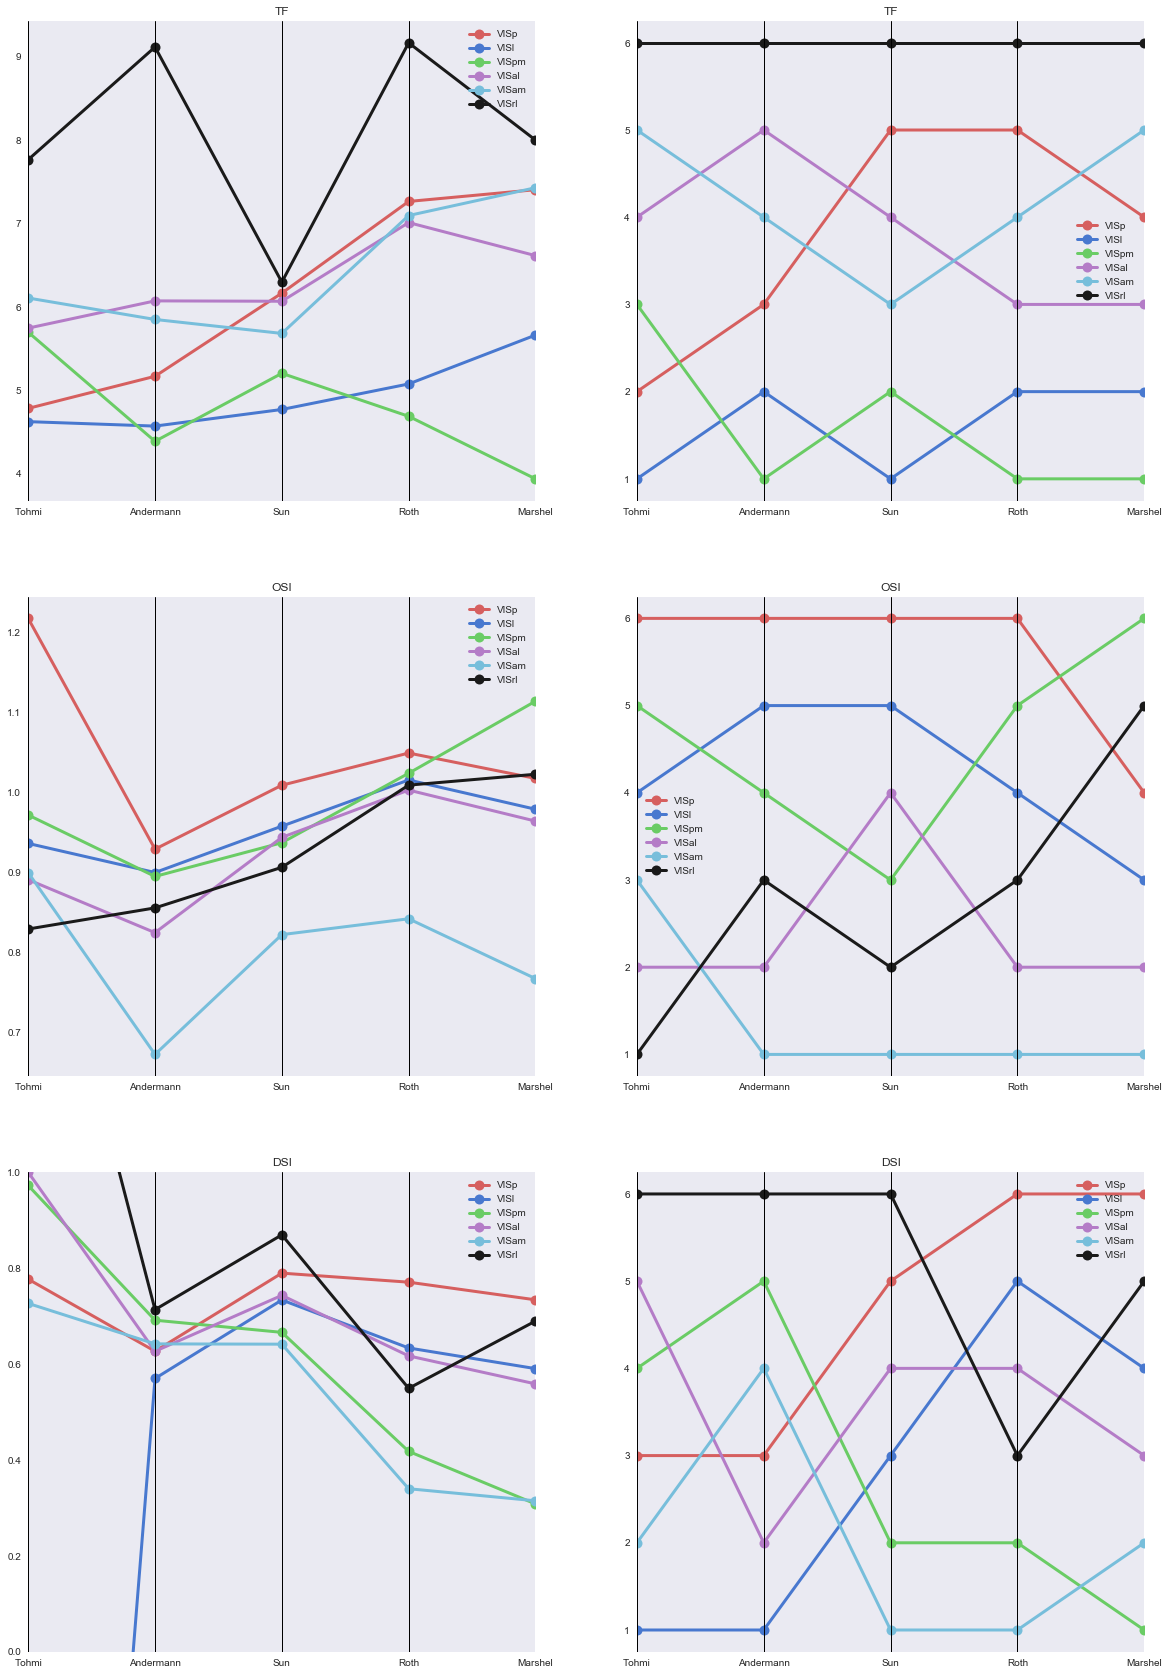

In [291]:
from pandas.tools.plotting import parallel_coordinates
fig07, axs = plt.subplots(3,2,figsize = (20,30))

ax0 = axs[0, 0]
ax1 = axs[1, 0]
ax2 = axs[2, 0]

ax3 = axs[0, 1]
ax4 = axs[1, 1]
ax5 = axs[2, 1]

parallel_coordinates(pref_tf_df.reset_index(), 
                     'index', 
                     marker = 'o',
                     color = area_colors,
                     lw = 3, 
                     markersize = 10,
                     ax = ax0)
ax0.set_title('TF')
ax0.legend(area_order)
ax0.set_xlim()

parallel_coordinates(pref_osi_df.reset_index(),
                     'index',
                     marker = 'o',
                     color = area_colors,
                     markersize = 10,
                     lw = 3,
                     ax = ax1)

ax1.legend(area_order)
ax1.set_title('OSI')



parallel_coordinates(pref_dsi_df.reset_index(), 'index', marker = 'o',color = area_colors, markersize = 10,lw = 3, ax = ax2)
ax2.set_title('DSI')
ax2.legend(area_order)
ax2.set_ylim(0,1)

parallel_coordinates(rank_orders_tf_ob.reset_index(), 'index', marker = 'o',color = area_colors, markersize = 10,lw = 3, ax = ax3)
ax3.set_title('TF')
ax3.set_xlim()
ax3.legend(area_order)

parallel_coordinates(rank_orders_osi_ob.reset_index(), 'index', marker = 'o',color = area_colors, markersize = 10,lw = 3, ax = ax4)
ax4.set_title('OSI')
ax4.legend(area_order)

parallel_coordinates(rank_orders_dsi_ob.reset_index(), 'index', marker = 'o',color = area_colors, markersize = 10,lw = 3, ax = ax5)
ax5.set_title('DSI')
ax5.legend(area_order)



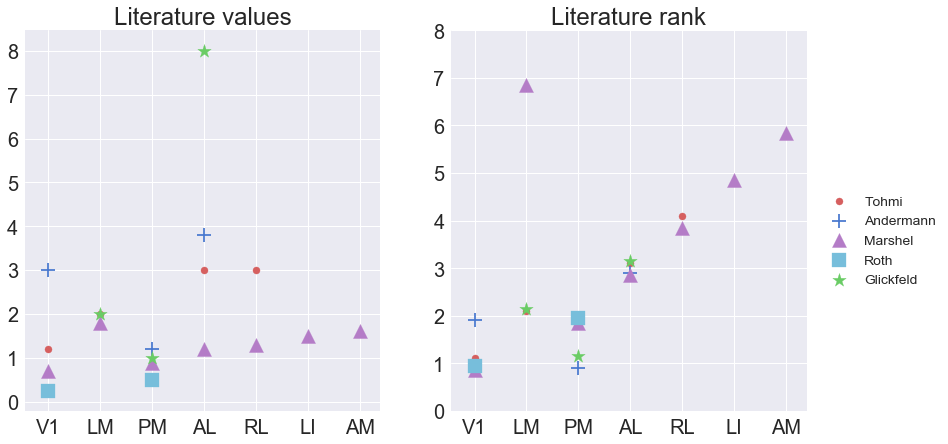

(-1, 6)

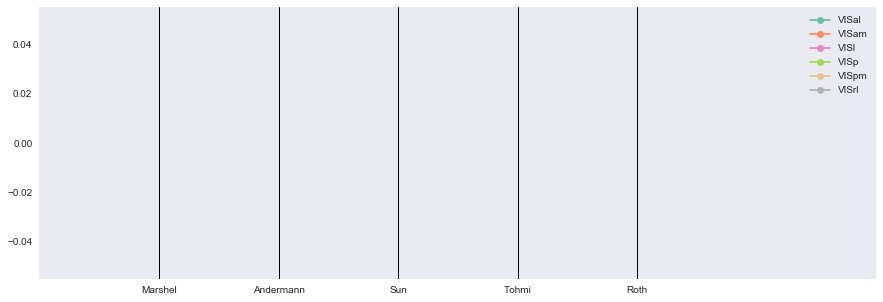

In [75]:
from pandas.tools.plotting import parallel_coordinates
fig, ax = plt.subplots(1,1,figsize = (15,5))
parallel_coordinates(rank_orders_ob.reset_index(), 'index', marker = 'o',colormap=plt.get_cmap("Set2"))

ax.set_xlim(-1, 6)


In [ ]:
figs2

In [ ]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('response_vs_reliability_plots.pdf') as pdf:
    for fig in figs2:
        pdf.savefig(fig)
        fig.clear()
        plt.close(fig)
        del fig
        